In [41]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data Glacier internship/Group_project')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('Train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
train_df.shape

(13647309, 48)

In [ ]:
train_df.head()

fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo antiguedad  indrel  ... ind_hip_fin_ult1 ind_plan_fin_ult1  \
0        0.0          6     1.0  ...                0                 0   
1        0.0         35     1.0  ...                0                 0   
2        0.0         35     1.0  ...                0                 0   
3        0.0         35     1.0  ...                0                 0   
4        0.0         35     1.0  ...                0                 0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

  ind_viv_fin_ult1 ind_nomina_ult1  ind_nom_pens_ult1  ind_recibo_ult1  
0                0             0.0                0.0                0  
1                0             0.0                0.0                0  
2                0             0.0                0.0                0  
3                0             0.0                0.0                0  
4                0             0.0                0.0                0  

[5 rows x 48 columns]

In [ ]:
train_df.isnull().sum() / train_df.shape[0] *100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1         0.000000
ind_cno_fin_ult1    

In [ ]:
train_df.duplicated().sum()

0

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

let's delete rows with a lot of missing values

In [ ]:
del_rows = train_df[train_df.ind_empleado.isnull()].index 

In [ ]:
train_df = train_df.drop(del_rows, axis = 0)

let's delete not-informative columns:

  

*   **ult_fec_cli_1t** and **conyuemp** have 99% null values. According to the instructions  conyuemp feature should contain number 1 if the customer is spouse of an employee. In dataset the feature conyuemp contain (N, S, nan) values. I suppose that N=No, S = Si (Yes). The number of clients with value ‘S’ = 17. We can delete these features because they contain too small info for analysis.
*   the feature **tipodom** we can delete because only 1 row has missing value and other rows have the same value
*   features **cod_prov** and **nomprov** explain the same information. We can delete one of them



In [ ]:
train_df.drop(['ult_fec_cli_1t', 'conyuemp', 'tipodom', 'cod_prov'], axis=1, inplace=True)

# Cleaning and transforming data

cleaning and transforming the features **age** and **antiguedad**

In [ ]:
#change type from object to int

train_df['age'] = train_df['age'].astype(int) 
train_df['antiguedad'] = train_df['antiguedad'].astype(int)

In [ ]:
num_columns = ['age', 'antiguedad', 'renta']

In [ ]:
train_df[num_columns].describe().apply(lambda s: s.apply('{0:.0f}'.format))

age antiguedad     renta
count  13619575   13619575  10852934
mean         40         77    134254
std          17       1672    230620
min           2    -999999      1203
25%          24         23     68711
50%          39         50    101850
75%          50        135    155956
max         164        256  28894396

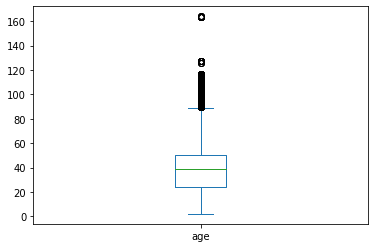

In [ ]:
_, bp = train_df.age.plot.box(return_type='both')

(array([1.494600e+04, 4.160800e+04, 7.323100e+04, 2.636650e+06,
        2.076752e+06, 1.074322e+06, 1.086930e+06, 1.878547e+06,
        1.344313e+06, 9.843010e+05, 7.810910e+05, 4.461980e+05,
        4.384800e+05, 2.723290e+05, 1.773510e+05, 1.600600e+05,
        7.627000e+04, 4.027700e+04, 1.140400e+04, 3.494000e+03,
        9.220000e+02, 7.700000e+01, 3.000000e+00, 8.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.100000e+01]),
 array([  2. ,   7.4,  12.8,  18.2,  23.6,  29. ,  34.4,  39.8,  45.2,
         50.6,  56. ,  61.4,  66.8,  72.2,  77.6,  83. ,  88.4,  93.8,
         99.2, 104.6, 110. , 115.4, 120.8, 126.2, 131.6, 137. , 142.4,
        147.8, 153.2, 158.6, 164. ]),
 <a list of 30 Patch objects>)

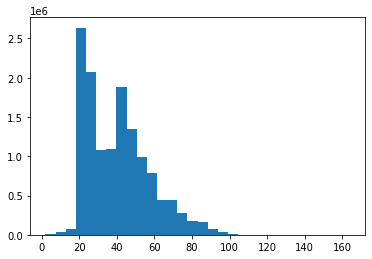

In [ ]:
plt.hist(train_df.age, bins = 30)

The feature **age** has some rows with customers  who are older than 100 years and a few customers who are very young. I think there are a lot of incorrect data. We can see that customers who are older 20 and younger 90  are most. One of the ways to overcome outliers is to unite the youngest and most adult customers into groups.


In [ ]:
train_df['age'] = np.where(train_df['age'] < 20, 19, train_df['age'])
train_df['age'] = np.where(train_df['age'] > 90, 91, train_df['age'])

result after grouping:

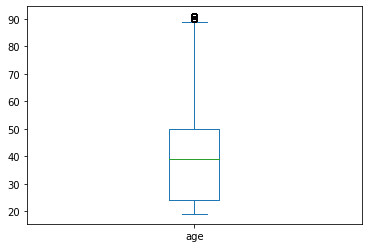

In [ ]:
_, bp = train_df.age.plot.box(return_type='both')

(array([1250237., 1516198., 1554579.,  522173.,  391749.,  507999.,
         358151.,  642805.,  548302.,  628764.,  962029.,  585870.,
         758443.,  434908.,  384038.,  461340.,  258916.,  327376.,
         178919.,  166093.,  233799.,  137017.,  191181.,   99594.,
          83576.,  109055.,   65798.,   82834.,   45366.,  132466.]),
 array([19. , 21.4, 23.8, 26.2, 28.6, 31. , 33.4, 35.8, 38.2, 40.6, 43. ,
        45.4, 47.8, 50.2, 52.6, 55. , 57.4, 59.8, 62.2, 64.6, 67. , 69.4,
        71.8, 74.2, 76.6, 79. , 81.4, 83.8, 86.2, 88.6, 91. ]),
 <a list of 30 Patch objects>)

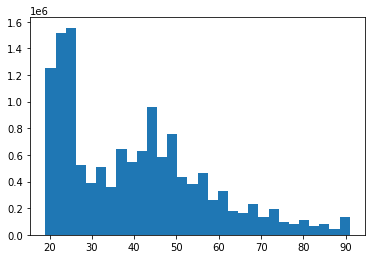

In [ ]:
plt.hist(train_df.age, bins = 30)

The feature 'antiguedad' (Customer seniority (in months)) contains 38 rows with value -99999. It makes the data very skewed. We should delete rows with this value, because it is an unknown value:


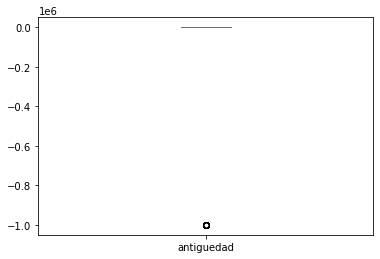

In [ ]:
_, bp = train_df.antiguedad.plot.box(return_type='both')

In [ ]:
unkn_rows = train_df[train_df.antiguedad == -999999].index
train_df = train_df.drop(unkn_rows, axis = 0)

box plot after deleting

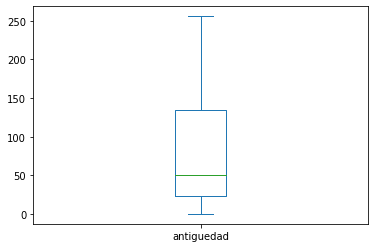

In [ ]:
_, bp = train_df.antiguedad.plot.box(return_type='both')

The feature Renta is also very shifted, because there is 18,9% data much more than 75% quartile.


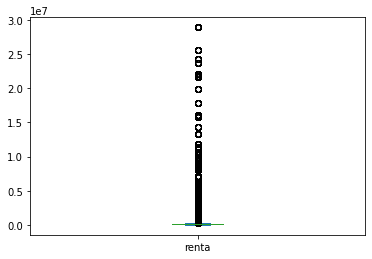

In [ ]:
_, bp = train_df.renta.plot.box(return_type='both')

Almost 19% of data are the outliers. And 20% of data is null. Delete these rows will be incorrect. It is necessary to carry out work on the replacement of zero values and emissions. For NA values it can be mean by segmento feature.
For outliers it will be grouping.
First of all let's fill missing values the mean values by feature **segmento** and **nomprov**.
before that let's input the most popular value in feature **nomprov** and **cod_prov**

In [ ]:
train_df.nomprov.value_counts().head(2)

MADRID       4475419
BARCELONA    1275219
Name: nomprov, dtype: int64

In [ ]:
train_df.nomprov = train_df.nomprov.fillna("MADRID")

In [ ]:
mean_renta = dict(train_df.renta.groupby([train_df.nomprov, train_df.segmento]).mean())

In [ ]:
for key, value in mean_renta.items():
    # print(key)
    train_df.loc[(train_df.nomprov == key[0]) & (train_df.segmento == key[1]) & (train_df.renta.isnull() == True), 'renta'] = value

other null values in feature renta we can input by mean income by province

In [ ]:
train_df.loc[train_df.renta.isnull(), "renta"] = train_df.groupby(train_df.nomprov).renta.transform('mean')

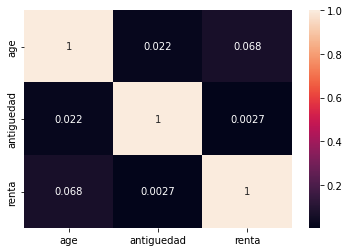

In [ ]:
sns.heatmap(train_df[num_columns].corr(), annot=True)
plt.show()

now we can replace the missing values feature **segmento** based on **renta**. 

In [ ]:
train_df.renta.groupby([train_df.segmento]).mean()

segmento
01 - TOP              173887.182284
02 - PARTICULARES     138889.796082
03 - UNIVERSITARIO    115673.619697
Name: renta, dtype: float64

In [ ]:
train_df[train_df.renta <= 115000].segmento.fillna("03 - UNIVERSITARIO", inplace=True)
train_df[train_df.renta <= 140000].segmento.fillna("02 - фй1PARTICULARES", inplace=True)
train_df.segmento.fillna("01 - TOP", inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


let's work with feature **sexo** 

In [ ]:
train_df.sexo.value_counts()

V    7424214
H    6195253
Name: sexo, dtype: int64

In [ ]:
train_df.sexo.fillna("V", inplace=True)

**indrel_1mes** and **tiprel_1mes**. There are 0.89% NA values. And types of data are different. We will not to make a ML models and for EDA analysis could be useful change values in a text format according to instructions

In [ ]:
train_df.indrel_1mes.value_counts()

1.0    7277589
1.0    4017733
1      2195321
3.0       1804
3.0       1409
3         1137
P          874
2          483
2.0        479
2.0        355
4.0        143
4.0         93
4           70
Name: indrel_1mes, dtype: int64

In [ ]:
#Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner)

map_indrel_1mes = {1: 'First/Primary', 
                   '1.0': 'First/Primary',
                   '1': 'First/Primary',
                   '3.0': 'Former primary',
                   3: 'Former primary',
                   '3': 'Former primary',
                   'P': 'Potential',
                   2: 'Co-owner', 
                   '2.0': 'Co-owner',
                   '2': 'Co-owner',
                   4: 'Former Co-owner', 
                   '4.0': 'Former Co-owner',
                   '4': 'Former Co-owner'}

In [ ]:
train_df.indrel_1mes = train_df.indrel_1mes.map(map_indrel_1mes)

In [ ]:
train_df.indrel_1mes.value_counts()

First/Primary      13490643
Former primary         4350
Co-owner               1317
Potential               874
Former Co-owner         306
Name: indrel_1mes, dtype: int64

In [ ]:
train_df.indrel_1mes.fillna('First/Primary', inplace=True)

In [ ]:
train_df.tiprel_1mes.value_counts()

I    7304875
A    6187085
P       4656
R        870
N          4
Name: tiprel_1mes, dtype: int64

In [ ]:
# A (active), I (inactive), P (former customer),R (Potential)
#what is mean N?

map_tiprel_1mes = {'A': 'Active', 
                   'I': 'Inactive',
                   'P': 'Former customer',
                   'R': 'Potential'}

train_df.tiprel_1mes = train_df.tiprel_1mes.map(map_tiprel_1mes)
train_df.tiprel_1mes.fillna('I', inplace=True)

**canal_entrada**. Let's see which of channel the most popular in different province

In [ ]:
dict_best_chanels = {}
for i in train_df.nomprov.unique():
    dict_best_chanels[i] = train_df[train_df.nomprov == i].canal_entrada.value_counts().head(1).index.to_list()[0]

now we can replace the missing values by the most popular channel in each province  

In [ ]:
for key, value in dict_best_chanels.items():
      train_df.loc[(train_df.nomprov == key) & (train_df.canal_entrada.isnull() == True), 'canal_entrada'] = value

let's change date columns to date format

In [ ]:
train_df.fecha_dato = pd.to_datetime(train_df.fecha_dato, format="%Y-%m-%d")
train_df.fecha_alta = pd.to_datetime(train_df.fecha_alta, format="%Y-%m-%d")

In [ ]:
train_df.ind_nuevo.value_counts()

0.0    12808330
1.0      811207
Name: ind_nuevo, dtype: int64

indrel - 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month). No NA values. If you build an ML model, it could be better to change 99 on 0 because it is scaled for ML models.

In [ ]:
train_df.indrel.value_counts()

1.0     13594744
99.0       24793
Name: indrel, dtype: int64

In [ ]:
train_df.indresi.value_counts()

S    13553673
N       65864
Name: indresi, dtype: int64

In [ ]:
train_df.indext.value_counts()

N    12974801
S      644736
Name: indext, dtype: int64

In [ ]:
train_df.indfall.value_counts()

N    13584775
S       34762
Name: indfall, dtype: int64

In [ ]:
train_df.ind_actividad_cliente.value_counts()

0.0    7384373
1.0    6235164
Name: ind_actividad_cliente, dtype: int64

Other features describe the product and customer's product availability.


In [ ]:
train_df.ind_nomina_ult1.value_counts()

0.0    12873585
1.0      745735
Name: ind_nomina_ult1, dtype: int64

In [ ]:
train_df.ind_nom_pens_ult1.value_counts()

0.0    12809481
1.0      809839
Name: ind_nom_pens_ult1, dtype: int64

In [ ]:
train_df.ind_nom_pens_ult1.fillna(0, inplace=True)
train_df.ind_nomina_ult1.fillna(0, inplace=True)

In [ ]:
train_df.isnull().sum() / train_df.shape[0] *100

fecha_dato               0.0
ncodpers                 0.0
ind_empleado             0.0
pais_residencia          0.0
sexo                     0.0
age                      0.0
fecha_alta               0.0
ind_nuevo                0.0
antiguedad               0.0
indrel                   0.0
indrel_1mes              0.0
tiprel_1mes              0.0
indresi                  0.0
indext                   0.0
canal_entrada            0.0
indfall                  0.0
nomprov                  0.0
ind_actividad_cliente    0.0
renta                    0.0
segmento                 0.0
ind_ahor_fin_ult1        0.0
ind_aval_fin_ult1        0.0
ind_cco_fin_ult1         0.0
ind_cder_fin_ult1        0.0
ind_cno_fin_ult1         0.0
ind_ctju_fin_ult1        0.0
ind_ctma_fin_ult1        0.0
ind_ctop_fin_ult1        0.0
ind_ctpp_fin_ult1        0.0
ind_deco_fin_ult1        0.0
ind_deme_fin_ult1        0.0
ind_dela_fin_ult1        0.0
ind_ecue_fin_ult1        0.0
ind_fond_fin_ult1        0.0
ind_hip_fin_ul

let's save the clean data

In [ ]:
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data Glacier internship/Group_project/clean_data.csv', index=False, header=True)

Now we are ready to make EDA analysis. 

## EDA ANALYSIS


In [3]:
pd.set_option("display.max_columns", None)

I downoland already prepared dataset - without NA values, outliers and duplicates.

In [4]:
train_df = pd.read_csv('clean_data.csv')

In [5]:
train_df.head()

fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo  antiguedad  indrel    indrel_1mes tiprel_1mes indresi indext  \
0        0.0           6     1.0  First/Primary      Active       S      N   
1        0.0          35     1.0  First/Primary    Inactive       S      S   
2        0.0          35     1.0  First/Primary    Inactive       S      N   
3        0.0          35     1.0  First/Primary    Inactive       S      N   
4        0.0          35     1.0  First/Primary      Active       S      N   

  canal_entrada indfall      nomprov  ind_actividad_cliente          renta  \
0           KHL       N       MALAGA                    1.0   87218.100000   
1           KHE       N  CIUDAD REAL                    0.0   35548.740000   
2           KHE       N  CIUDAD REAL                    0.0  122179.110000   
3           KHD       N     ZARAGOZA                    0.0  119775.540000   
4           KHE       N     ZARAGOZA                    1.0  110927.085837   

             segmento  ind_ahor_fin_ult1  ind_aval_fin_ult1  ind_cco_fin_ult1  \
0   02 - PARTICULARES                  0                  0                 1   
1  03 - UNIVERSITARIO                  0                  0                 1   
2  03 - UNIVERSITARIO                  0                  0                 1   
3  03 - UNIVERSITARIO                  0                  0                 0   
4  03 - UNIVERSITARIO                  0                  0                 1   

   ind_cder_fin_ult1  ind_cno_fin_ult1  ind_ctju_fin_ult1  ind_ctma_fin_ult1  \
0                  0                 0                  0                  0   
1                  0                 0                  0                  0   
2                  0                 0                  0                  0   
3                  0                 0                  0                  0   
4                  0                 0                  0                  0   

   ind_ctop_fin_ult1  ind_ctpp_fin_ult1  ind_deco_fin_ult1  ind_deme_fin_ult1  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  1                  0   
4                  0                  0                  0                  0   

   ind_dela_fin_ult1  ind_ecue_fin_ult1  ind_fond_fin_ult1  ind_hip_fin_ult1  \
0                  0                  0                  0                 0   
1                  0                  0                  0                 0   
2                  0                  0                  0                 0   
3                  0                  0                  0                 0   
4                  0                  0                  0                 0   

   ind_plan_fin_ult1  ind_pres_fin_ult1  ind_reca_fin_ult1  ind_tjcr_fin_ult1  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   ind_valo_fin_ult1  ind_viv_fin_ult1  ind_nomina_ult1  ind_nom_pens_ult1  \
0                  0                 0              0.0                0.0   
1                

In [6]:
len(train_df.ncodpers.unique())

949612

In [7]:
train_df.shape[0]

13619537

In [9]:
len(train_df.ncodpers.unique())

949612

we can see that we have information about 949612 clients, but the number of rows is 13619537

In [10]:
#change column's name

train_df.rename(columns={'ncodpers': 'customer_code', 
                         'ind_empleado': 'employee_ind',
                         'pais_residencia': 'cust_country_residence',
                         'sexo': 'sex',
                         'ind_nuevo': 'new_cust_index',
                         'antiguedad': 'customer_seniority',
                         'indresi': 'residence_ind',
                         'indext': 'foreigner_ind',
                         'conyuemp': 'spouse_index',
                         'canal_entrada': 'channel',
                         'indfall': 'deceased_ind',
                         'tipodom': 'addres_type',
                         'nomprov': 'province_name',
                         'ind_actividad_cliente': 'activity_index',
                         'renta': 'income',
                         'segmento': 'segment',
                         'ind_ahor_fin_ult1': 'Saving_Account',
                         'ind_aval_fin_ult1': 'Guarantees',
                         'ind_cco_fin_ult1': 'Current_Accounts',
                         'ind_cder_fin_ult1': 'Derivada_Account',
                         'ind_cno_fin_ult1': 'Payroll_Account',
                         'ind_ctju_fin_ult1': 'Junior_Account',
                         'ind_ctma_fin_ult1': 'Más_particular_Account',
                         'ind_ctop_fin_ult1': 'Particular_Account',
                         'ind_ctpp_fin_ult1': 'Particular_Plus_Account',
                         'ind_deco_fin_ult1': 'Short_term_deposits',
                         'ind_deme_fin_ult1': 'Medium_term_deposits',
                         'ind_dela_fin_ult1': 'Long_term_deposits',
                         'ind_ecue_fin_ult1': 'e_account',
                         'ind_fond_fin_ult1': 'Funds',
                         'ind_hip_fin_ult1': 'Mortgage',
                         'ind_plan_fin_ult1': 'Pensions',
                         'ind_pres_fin_ult1': 'Loans',
                         'ind_reca_fin_ult1': 'Taxes',
                         'ind_tjcr_fin_ult1': 'Credit_Card',
                         'ind_valo_fin_ult1': 'Securities',
                         'ind_viv_fin_ult1': 'Home_Account',
                         'ind_nomina_ult1': 'Payroll',
                         'ind_nom_pens_ult1': 'Pensions_2',
                         'ind_recibo_ult1': 'Direct_Debit'}, inplace=True)

In [11]:
num_columns = ['age', 'customer_seniority', 'income']

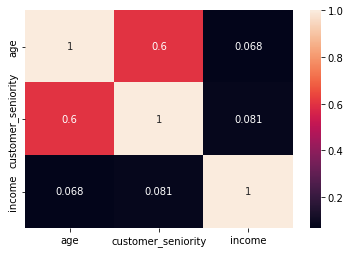

In [12]:
sns.heatmap(train_df[num_columns].corr(), annot=True)
plt.show()

In [13]:
products = ['Saving_Account', 'Guarantees',
       'Current_Accounts', 'Derivada_Account', 'Payroll_Account',
       'Junior_Account', 'Más_particular_Account', 'Particular_Account',
       'Particular_Plus_Account', 'Short_term_deposits',
       'Medium_term_deposits', 'Long_term_deposits', 'e_account', 'Funds',
       'Mortgage', 'Pensions', 'Loans', 'Taxes', 'Credit_Card', 'Securities',
       'Home_Account', 'Payroll', 'Pensions_2', 'Direct_Debit']

In [14]:
train_df['total_products'] = train_df[products].sum(axis=1)

In [15]:
for prod in products:
    num_cl = train_df['customer_code'][train_df[prod] == 1].nunique()
    per_cl = train_df['customer_code'][train_df[prod] == 1].nunique() / train_df['customer_code'].nunique() * 100
    print(f'Number of clients who have {prod} = {num_cl} or {round(per_cl, 5)}% of all customers')

Number of clients who have Saving_Account = 89 or 0.00937% of all customers
Number of clients who have Guarantees = 23 or 0.00242% of all customers
Number of clients who have Current_Accounts = 619653 or 65.25328% of all customers
Number of clients who have Derivada_Account = 407 or 0.04286% of all customers
Number of clients who have Payroll_Account = 85061 or 8.95745% of all customers
Number of clients who have Junior_Account = 8754 or 0.92185% of all customers
Number of clients who have Más_particular_Account = 17544 or 1.84749% of all customers
Number of clients who have Particular_Account = 107642 or 11.33537% of all customers
Number of clients who have Particular_Plus_Account = 37032 or 3.8997% of all customers
Number of clients who have Short_term_deposits = 6521 or 0.6867% of all customers
Number of clients who have Medium_term_deposits = 1846 or 0.1944% of all customers
Number of clients who have Long_term_deposits = 47251 or 4.97582% of all customers
Number of clients who hav

we can see that Current_Accounts is a popular product, 65% of clients have it. Next product is Direct_Debit (16%), then is particular_account (11%).

In [16]:
total_prod_by_cust = train_df.groupby('customer_code')[products].sum()

In [17]:
for prod in products:
    total_prod_by_cust[prod] = total_prod_by_cust[prod].apply(lambda x: 1 if x > 0 else 0)

In [18]:
total_prod_by_cust['total_products'] = total_prod_by_cust.sum(axis=1)

In [19]:
#delete customers without any products
total_prod_by_cust = total_prod_by_cust.drop(total_prod_by_cust[total_prod_by_cust.total_products == 0].index)
train_df = train_df.drop(train_df[train_df.total_products == 0].index)

Text(0.5, 1.0, 'Products distribution')

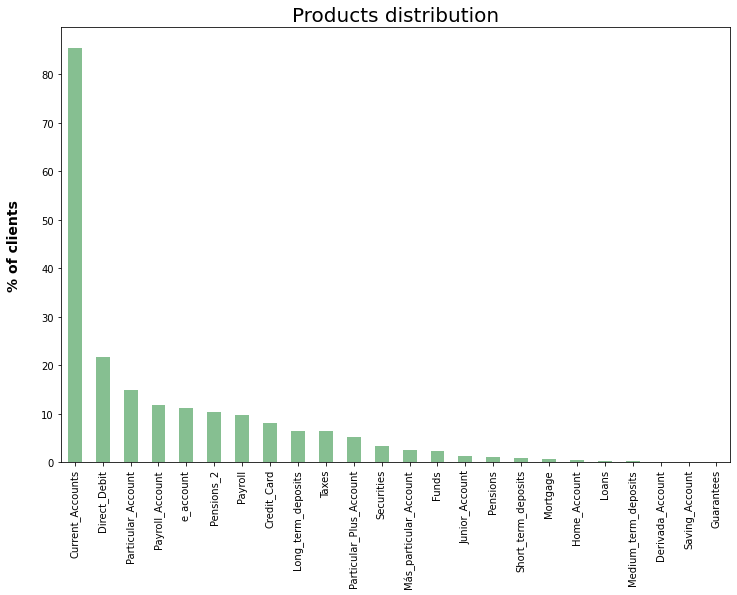

In [20]:
data = total_prod_by_cust[products].sum().sort_values(ascending=False) / total_prod_by_cust.shape[0] * 100 #).plot(kind='bar').set_title('Products distribution')

ax = data.plot(kind='bar', grid=False, figsize=(12,8), color='#86bf91', zorder=2)
ax.set_ylabel("% of clients", labelpad=20, weight='bold', size=14)
ax.set_title("Products distribution", size=20)

In [21]:
dict_products = {'Credit_Card': 58615,
                'Current_Accounts': 619653,
                'Direct_Debit': 156755,
                'Funds': 17294,
                'Long_term_deposits': 47251,
                'Más_particular_Account': 17544,
                'Particular_Account': 107642,
                'Particular_Plus_Account': 37032,
                'Payroll': 70257,
                'Payroll_Account': 85061,
                'Pensions_2': 75400,
                'Securities': 24029,
                'Taxes': 45894,
                'e_account': 81384,
                 'other': 36156}


I would like to see, which products the most popular in each group(age, salary, province etc.)

Let's create a new column - age group and see which product the most popular in each age group

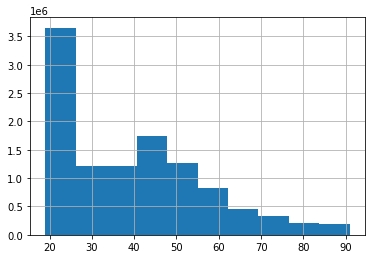

In [22]:
train_df.age.hist()

In [23]:
def func_ages_group(x):
    if x <= 20:
        return "<21"
    elif x >= 21 and x <= 40:
        return "21-40"
    elif x >= 41 and x <= 65:
        return "41-65"
    else:
        return ">65"


train_df['age_group']  = train_df['age'].apply(func_ages_group)

In [24]:
total_prod_by_cust = total_prod_by_cust.reset_index(level=0)
total_prod_by_cust = total_prod_by_cust.merge(train_df[['customer_code','age_group']], on='customer_code')
total_prod_by_cust.drop_duplicates(inplace=True)

In [25]:
def pie_plot(data, figsize, title, fontsize):

    pie, ax = plt.subplots(figsize=figsize)
    labels = data.keys()
    plt.pie(x=data, autopct="%.1f%%", labels=list(labels), pctdistance=0.5)
    plt.title(title, fontsize=fontsize)
    # pie.savefig("Total_users.png")

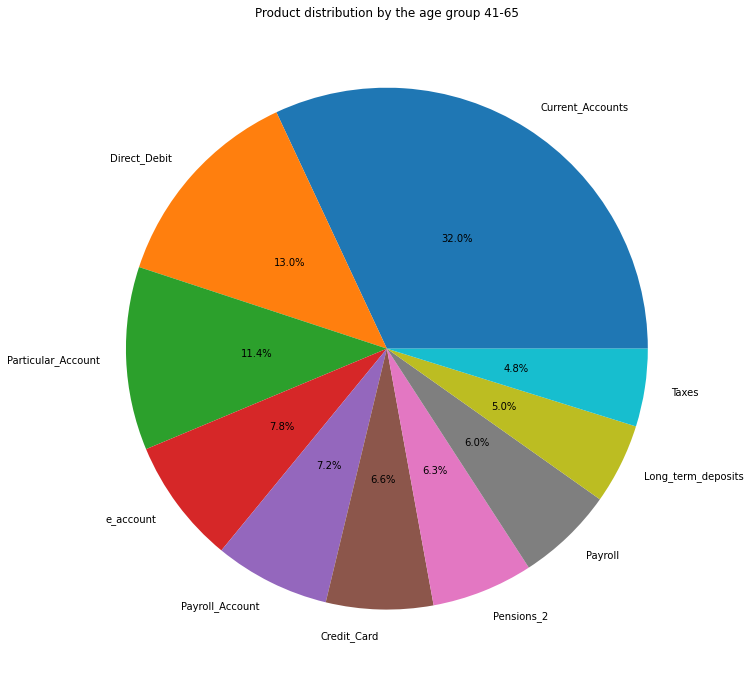

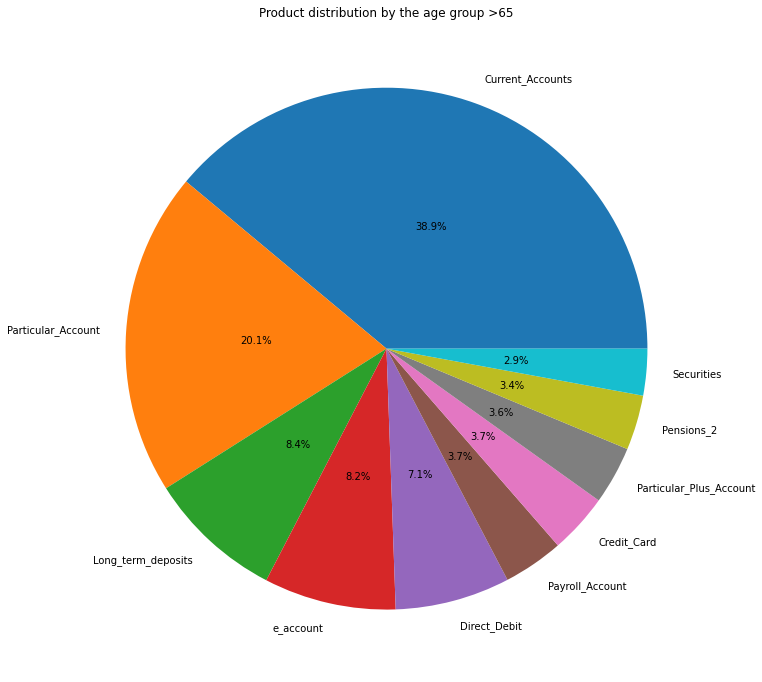

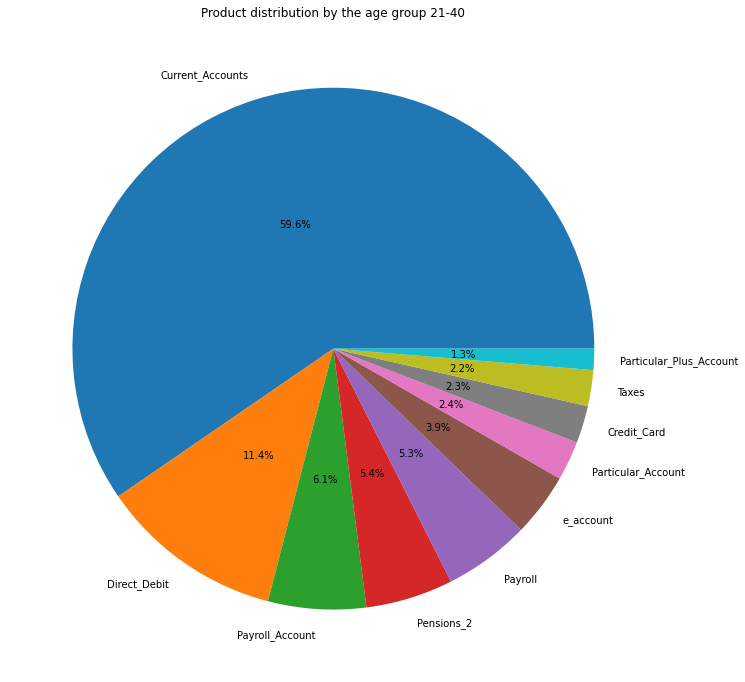

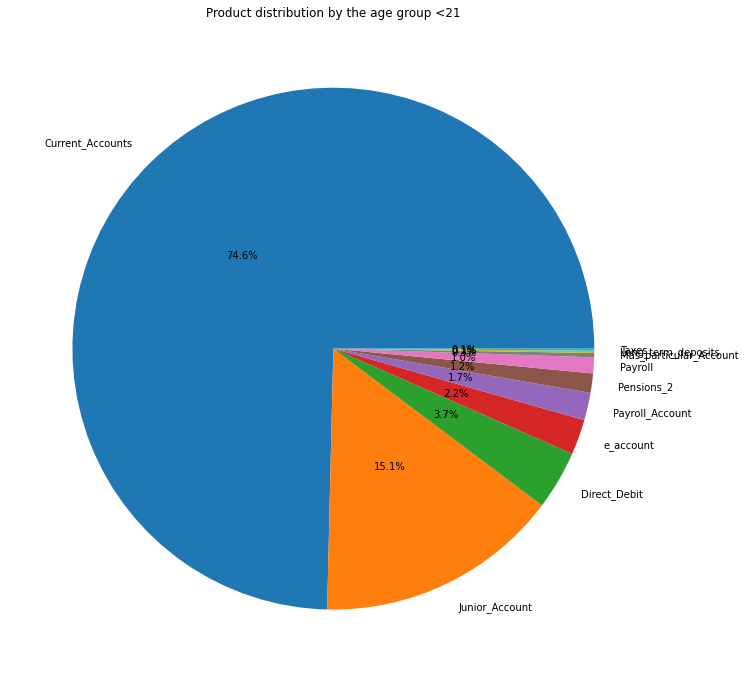

In [26]:
age_groups = total_prod_by_cust.age_group.unique()
for gr in age_groups:
    data = total_prod_by_cust[products][total_prod_by_cust.age_group == gr].sum().sort_values(ascending=False).head(10)
    pie_plot(data, [20,12], f'Product distribution by the age group {gr}', 12)

we can see that people in each group prefer a bit different a set of services or products. we can use this info for recommendations

let's see the most popular products by the segment, but I would like segment customers by myself


In [27]:
def func_segment_group(x):
    if x <= 50000:
        return "income less 50 000"
    elif x > 50000 and x <= 300000:
        return "income 50 000 - 300 000"
    elif x > 300000 and x <= 500000:
        return "income 300 000 - 500 000"
    else:
        return "income more than 500 000"


train_df['income_group']  = train_df['income'].apply(func_segment_group)

In [28]:
df_for_merge = train_df[['customer_code','income_group']].drop_duplicates()

In [29]:
total_prod_by_cust = total_prod_by_cust.merge(df_for_merge, on='customer_code')

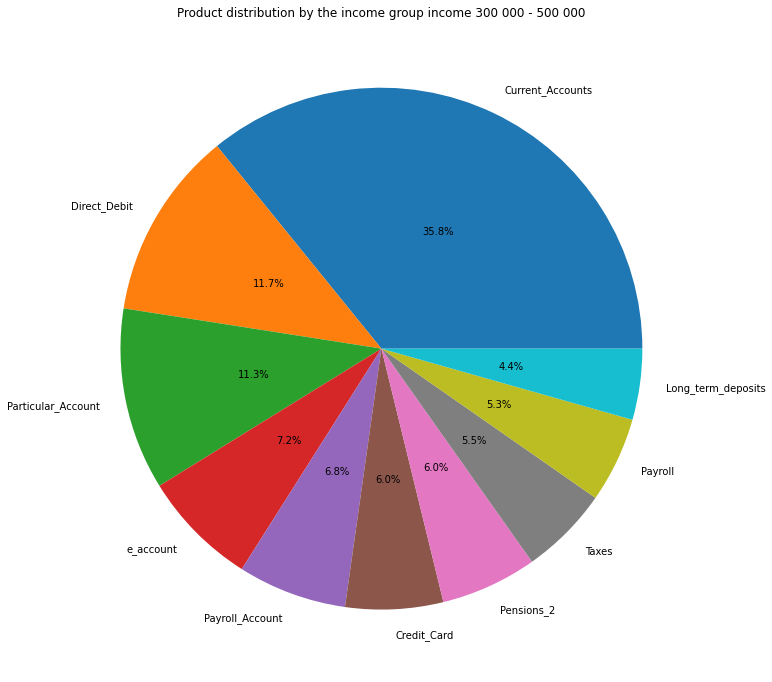

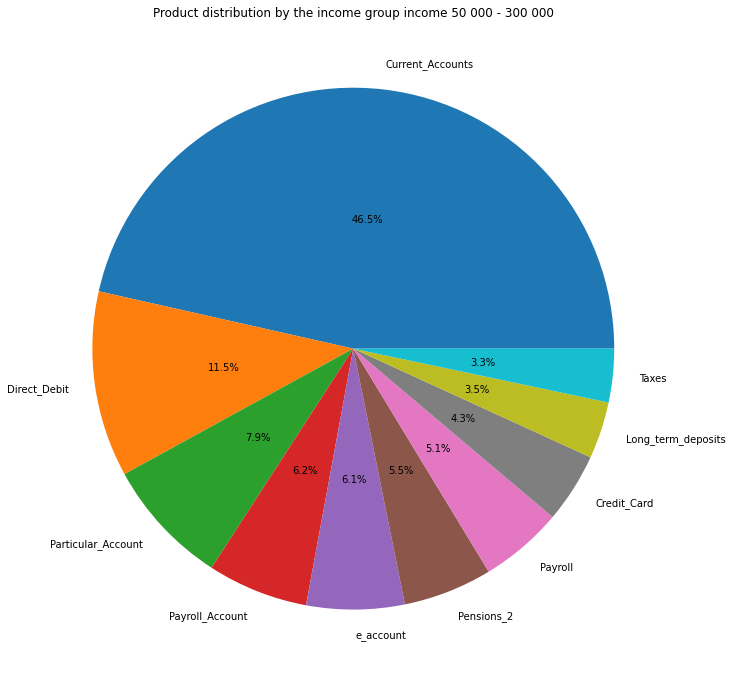

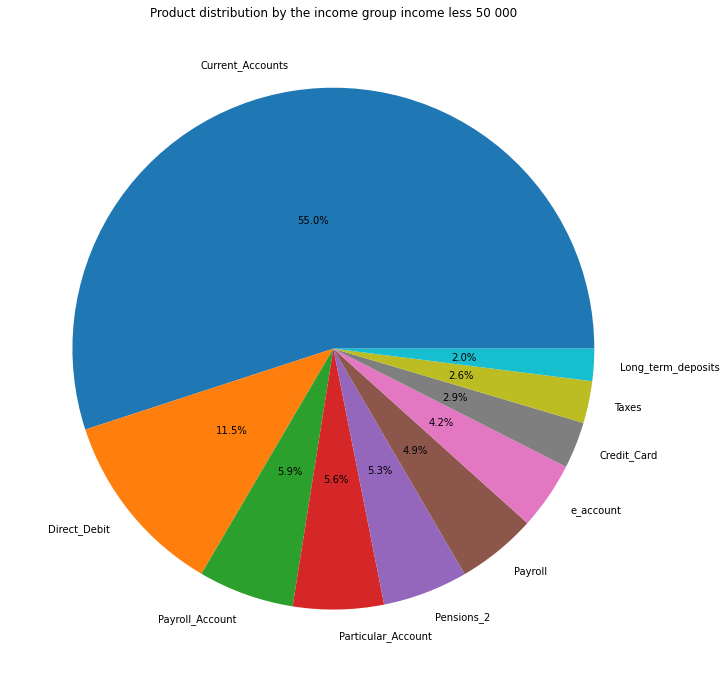

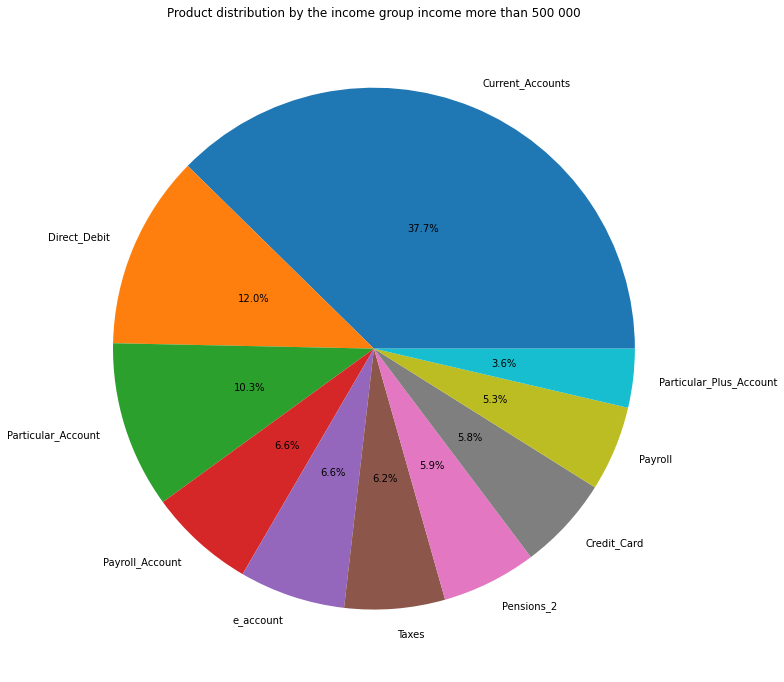

In [30]:
segm_groups = total_prod_by_cust.income_group.unique()
for gr in segm_groups:
    data = total_prod_by_cust[products][total_prod_by_cust.income_group == gr].sum().sort_values(ascending=False).head(10)
    pie_plot(data, [20,12], f'Product distribution by the income group {gr}', 12)

we can see that set of the services in each segment is almost similar.It is mean that income don't have an impact on the set of services.

next let's see distribution by province

In [31]:
df_for_merge = train_df[['customer_code','province_name']].drop_duplicates()
total_prod_by_cust = total_prod_by_cust.merge(df_for_merge, on='customer_code')

In [32]:
total_prod_by_cust.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


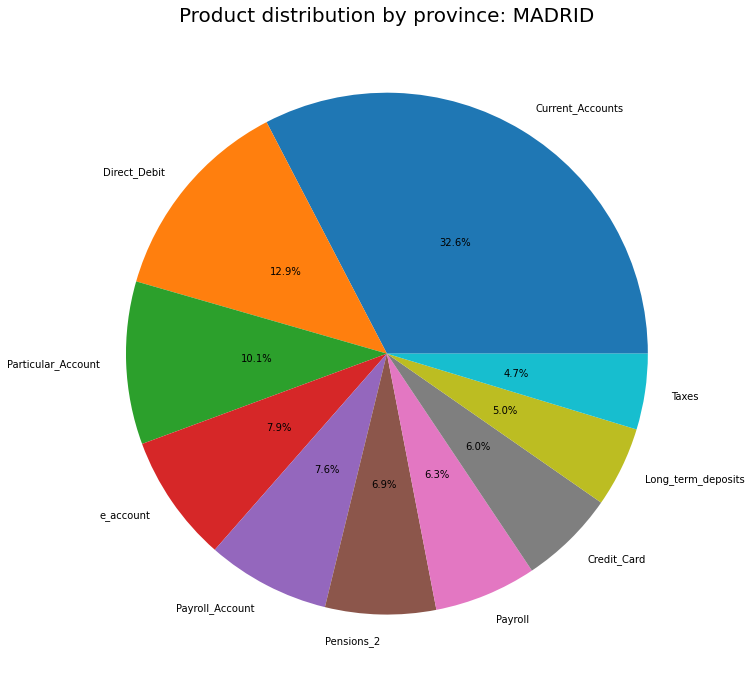

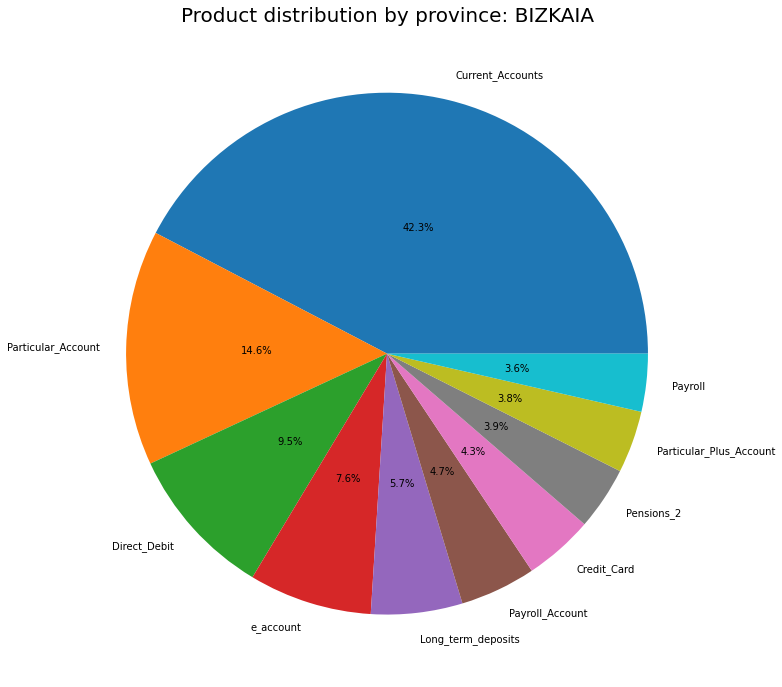

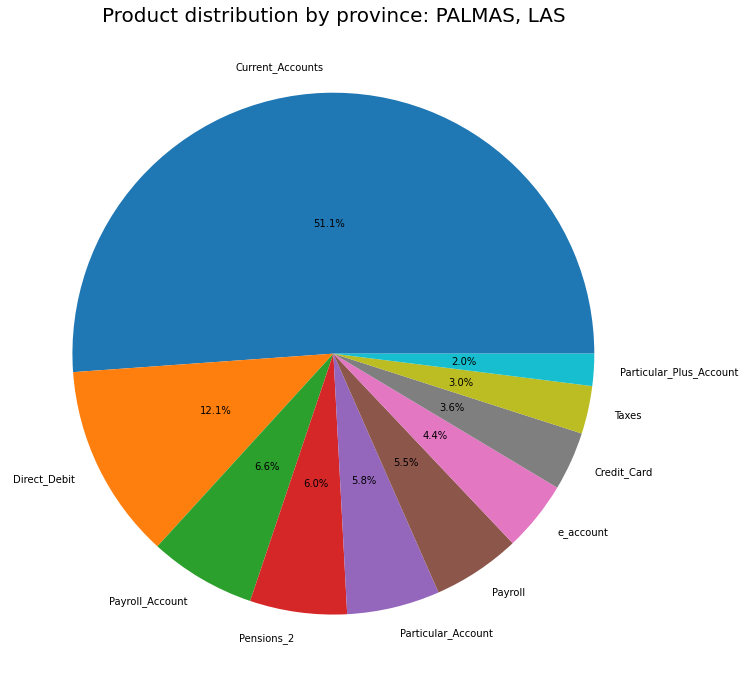

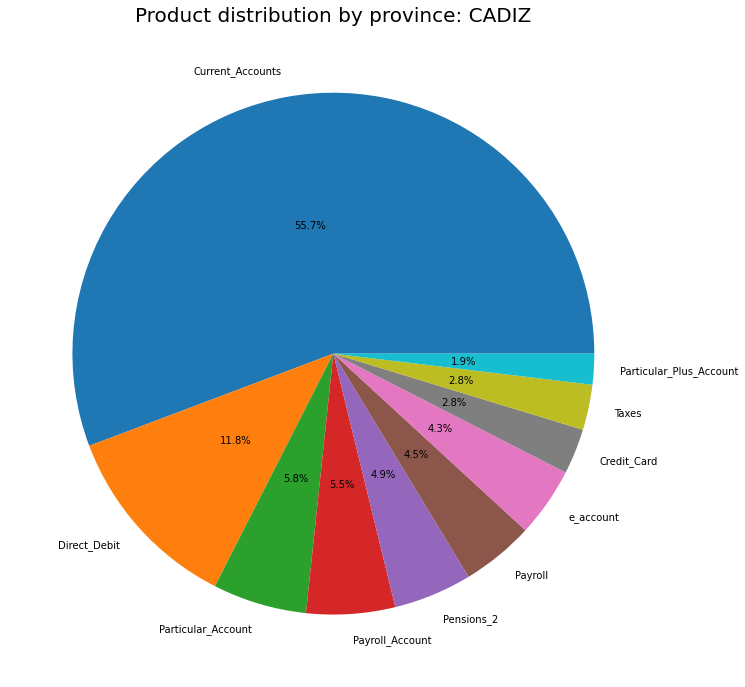

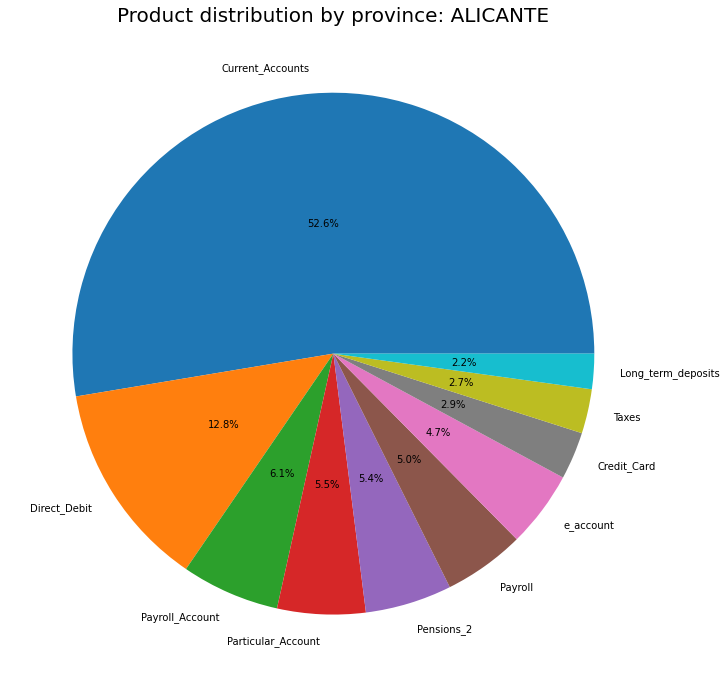

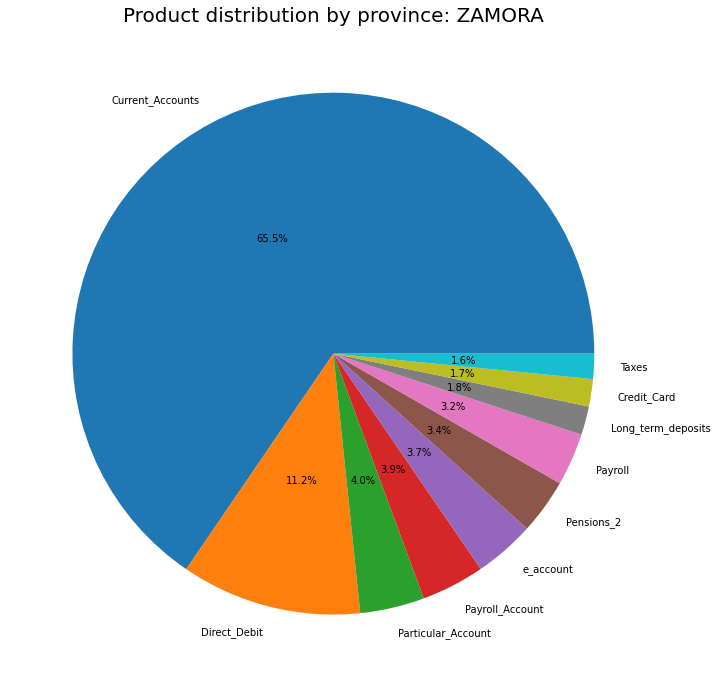

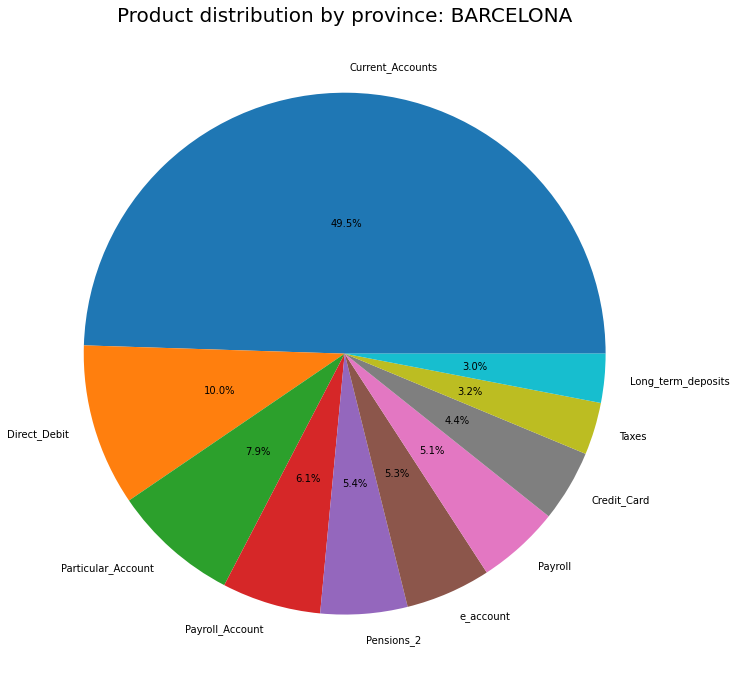

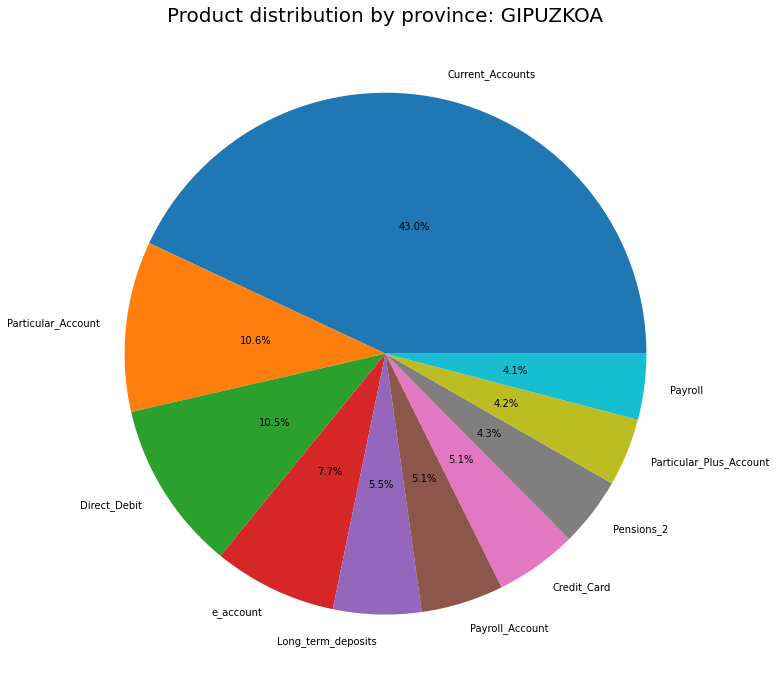

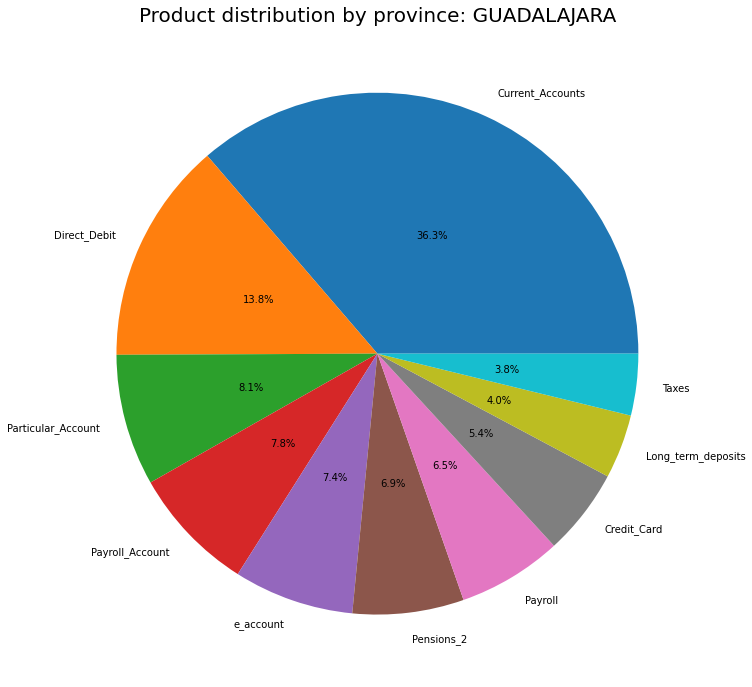

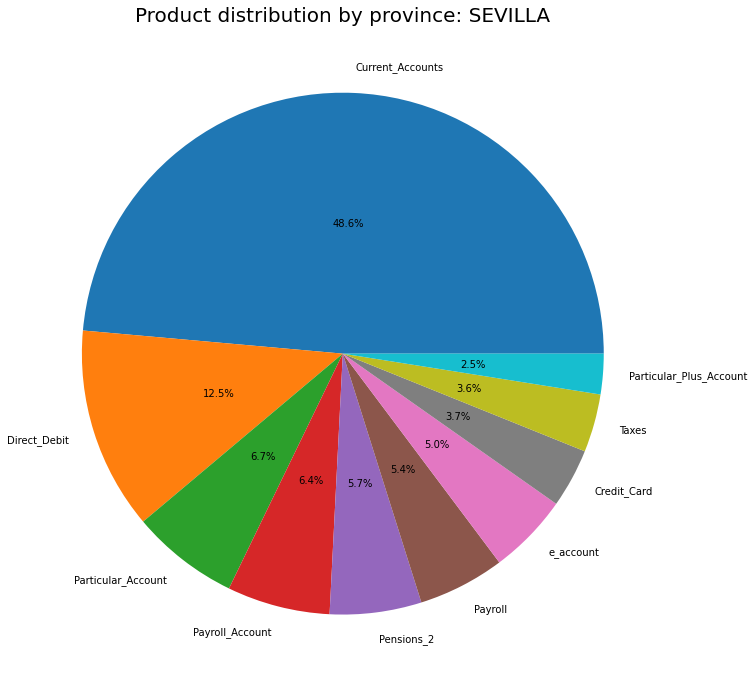

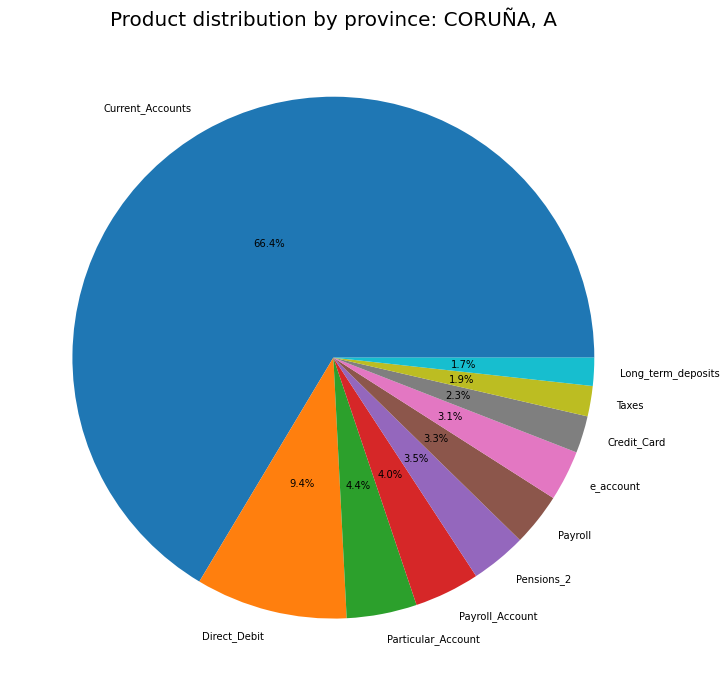

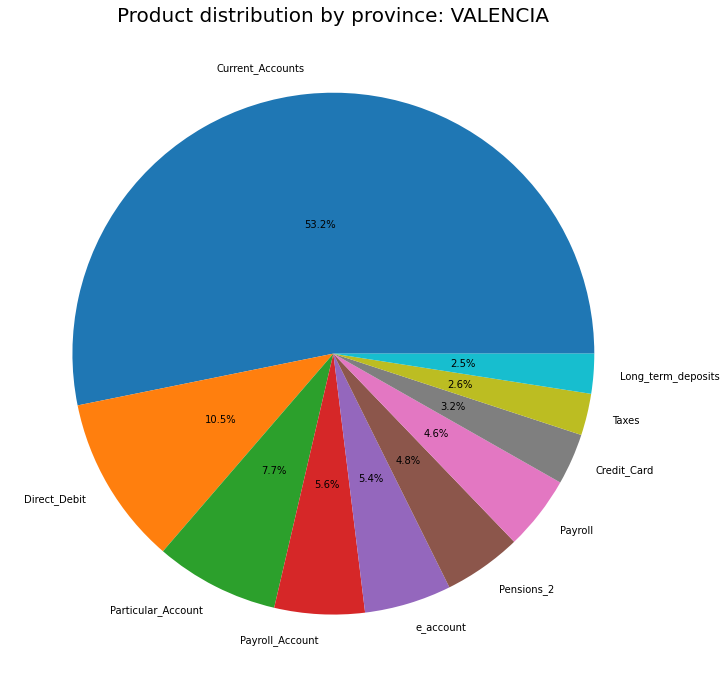

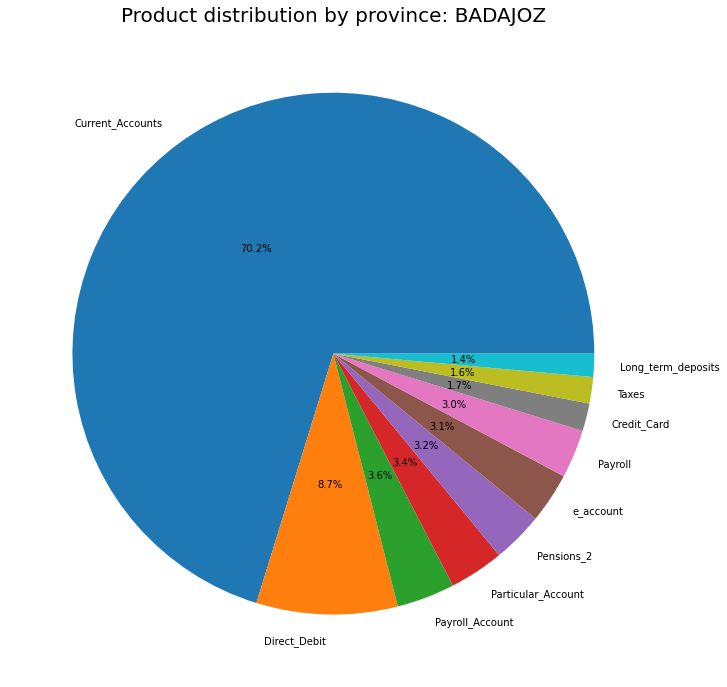

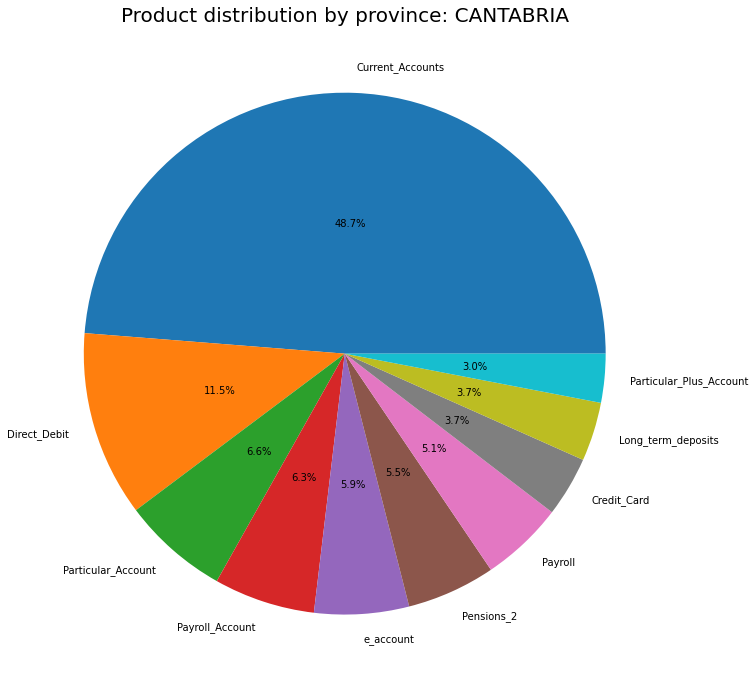

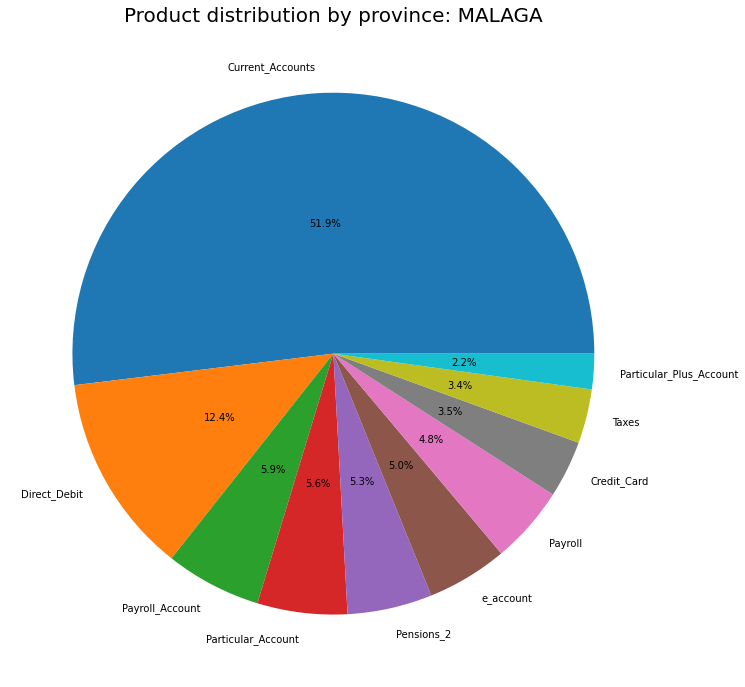

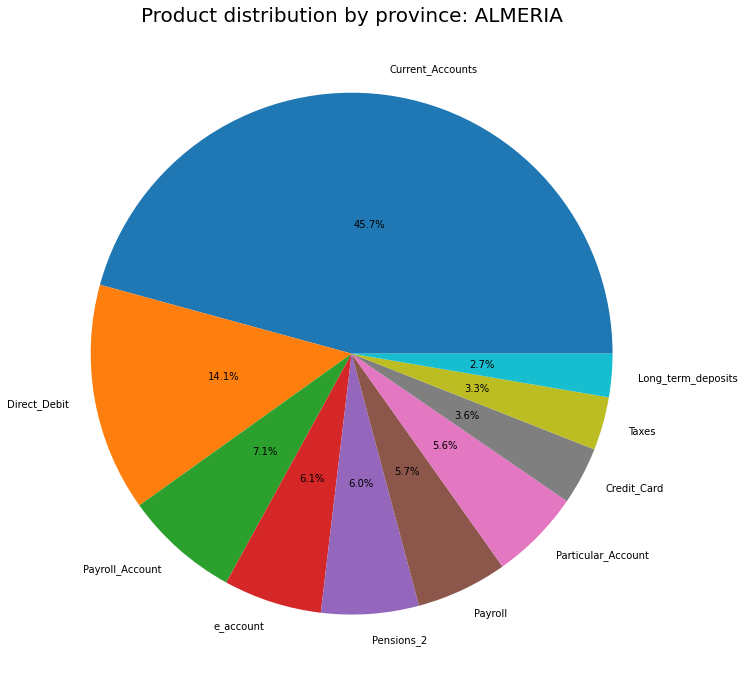

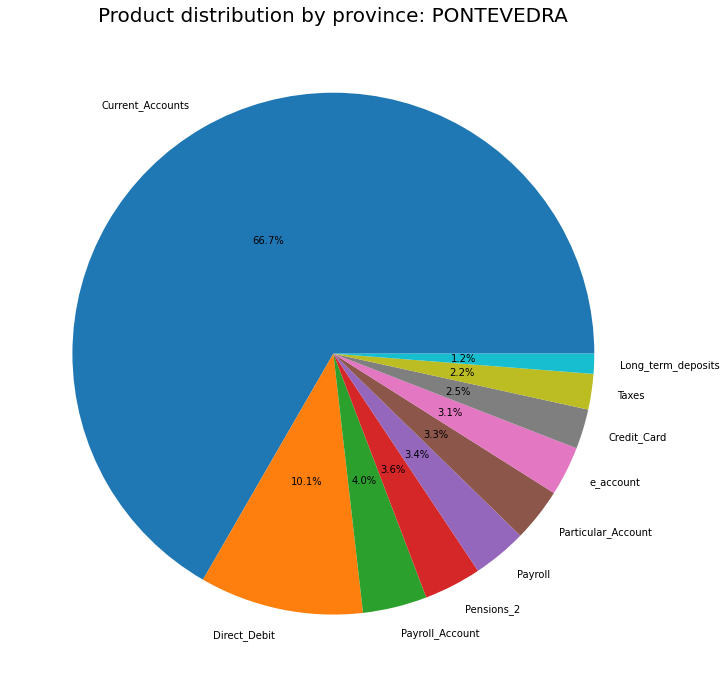

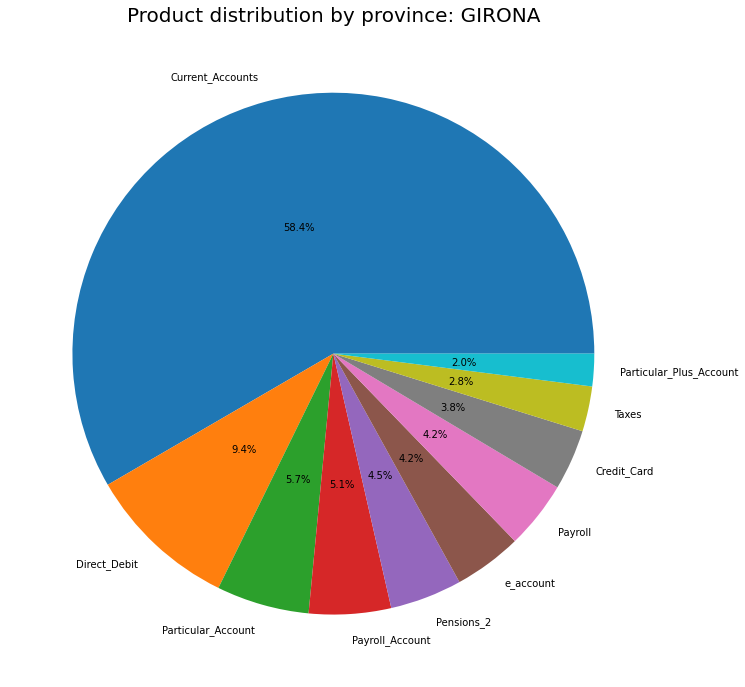

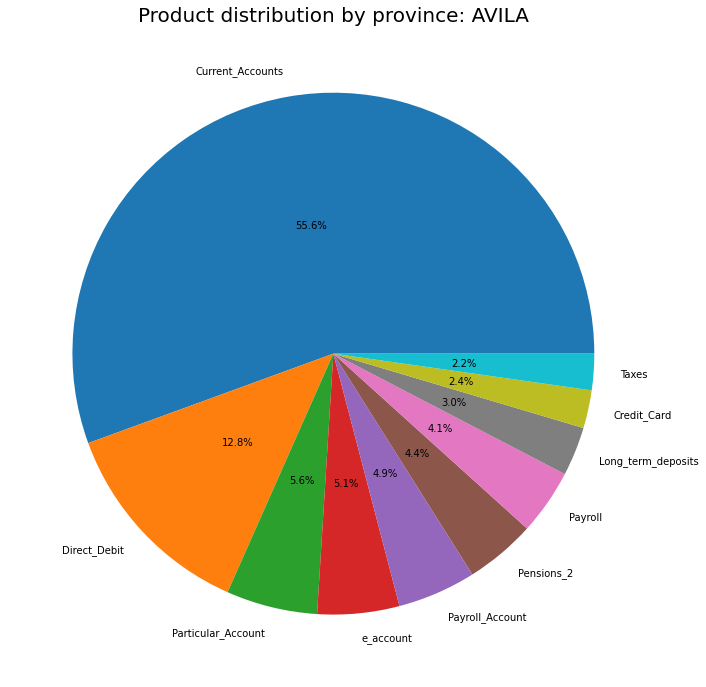

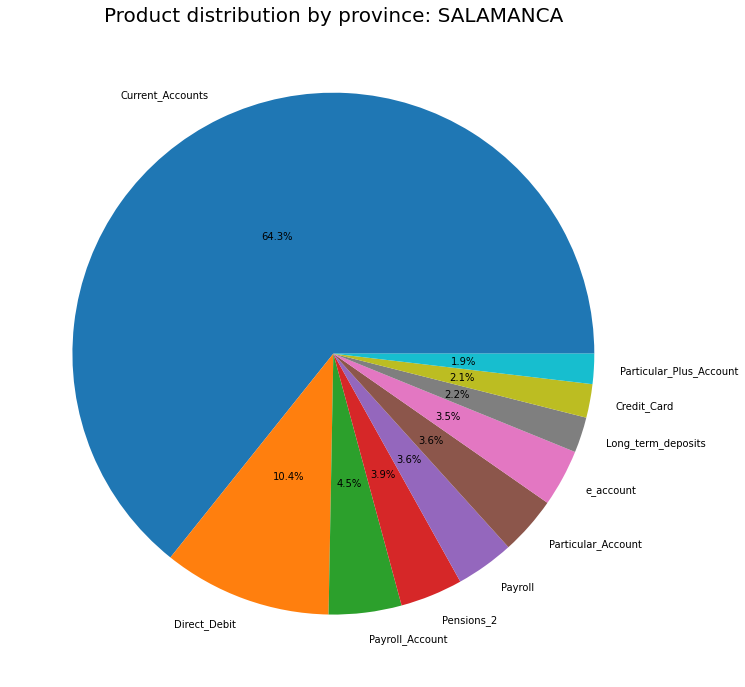

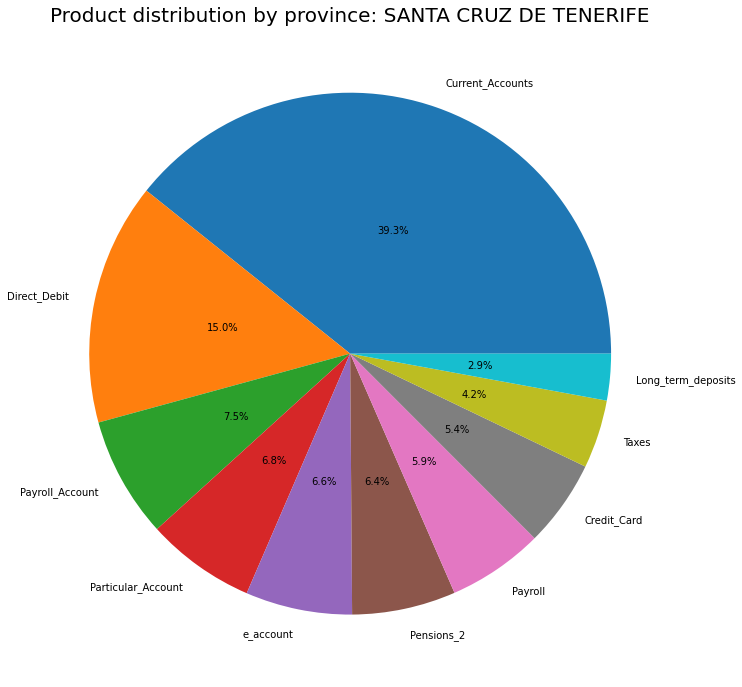

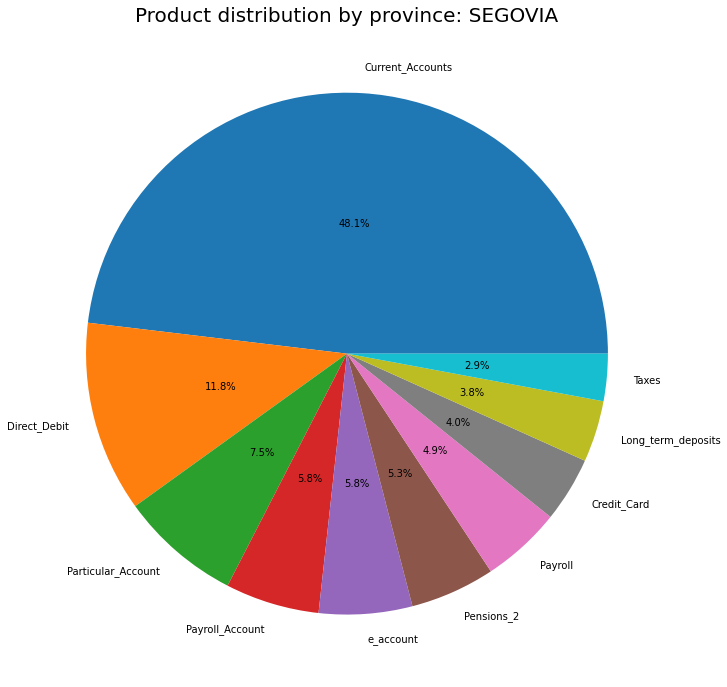

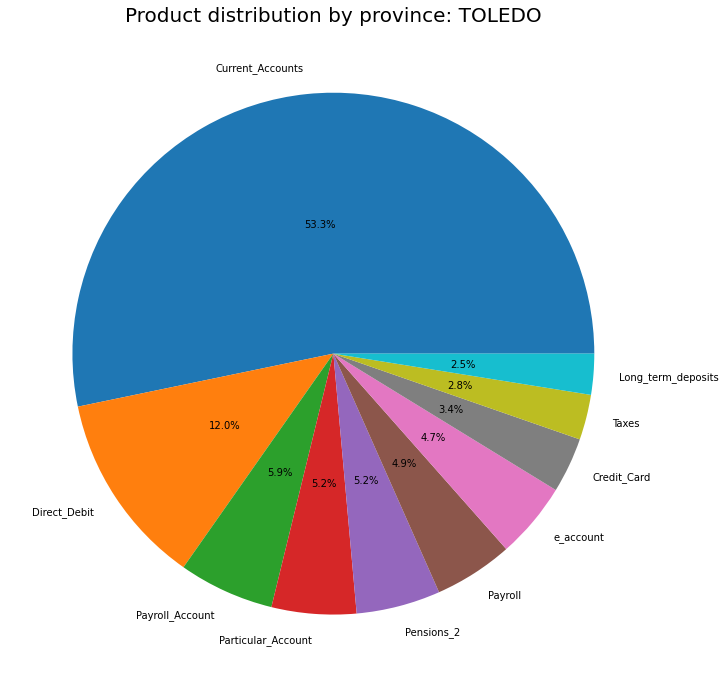

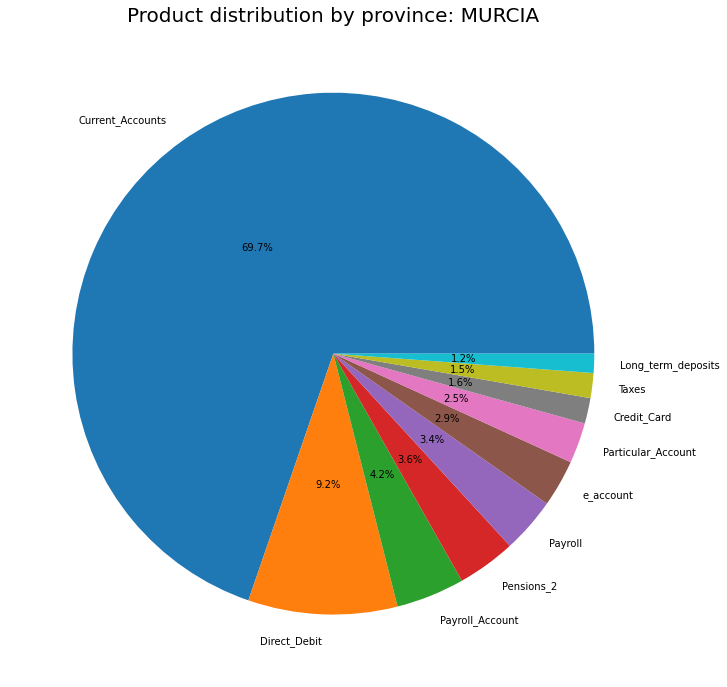

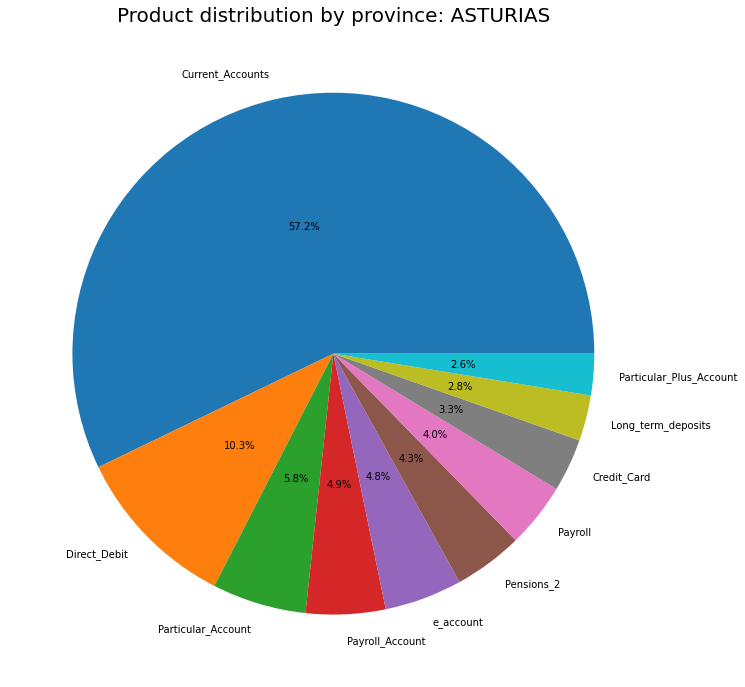

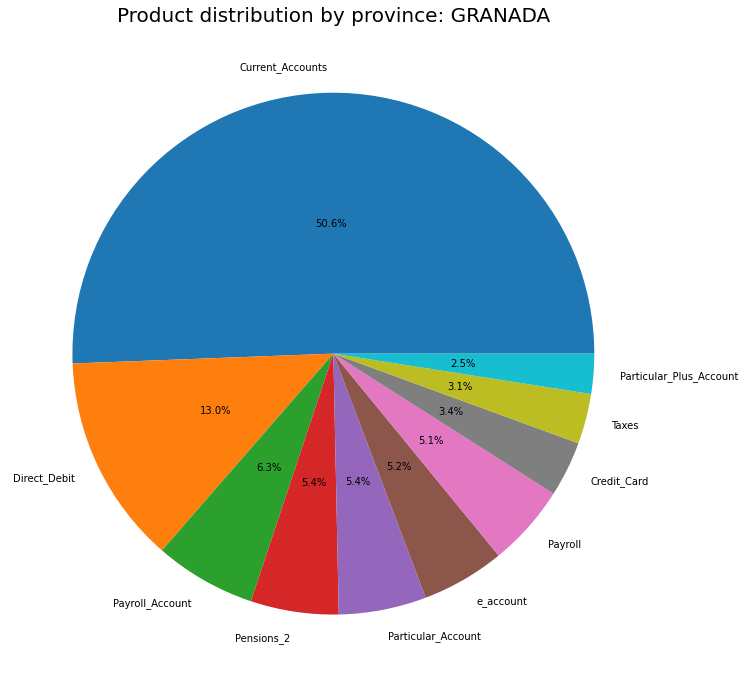

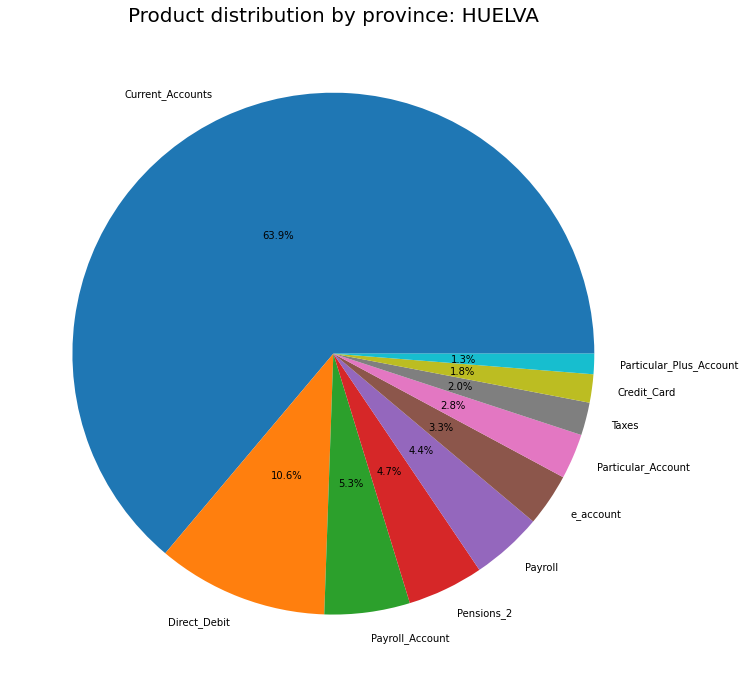

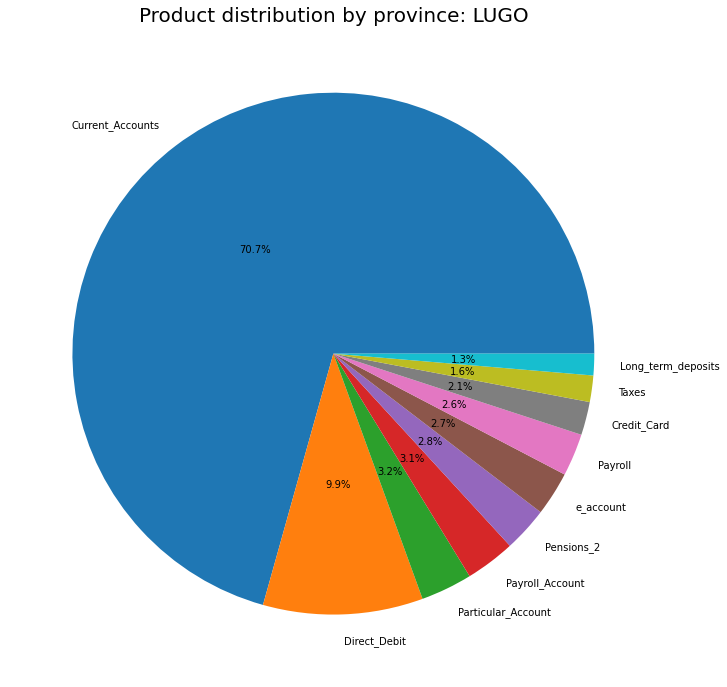

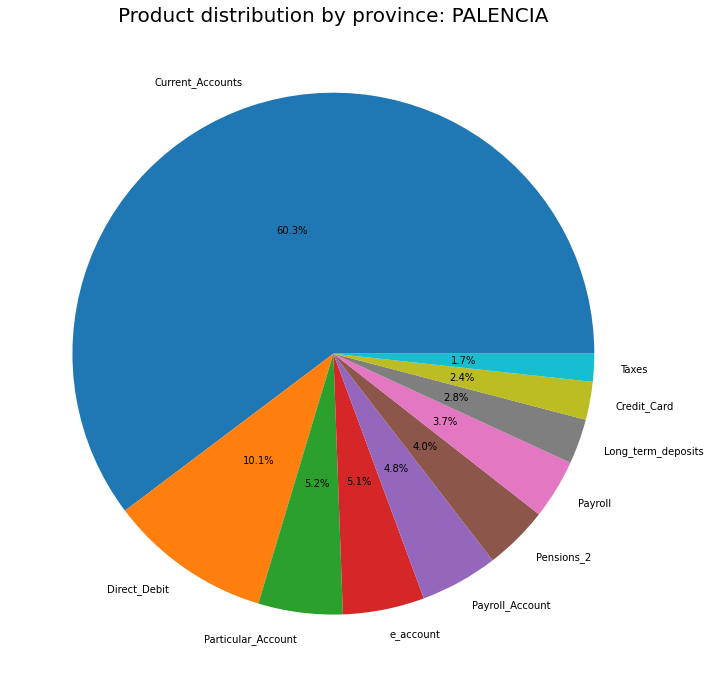

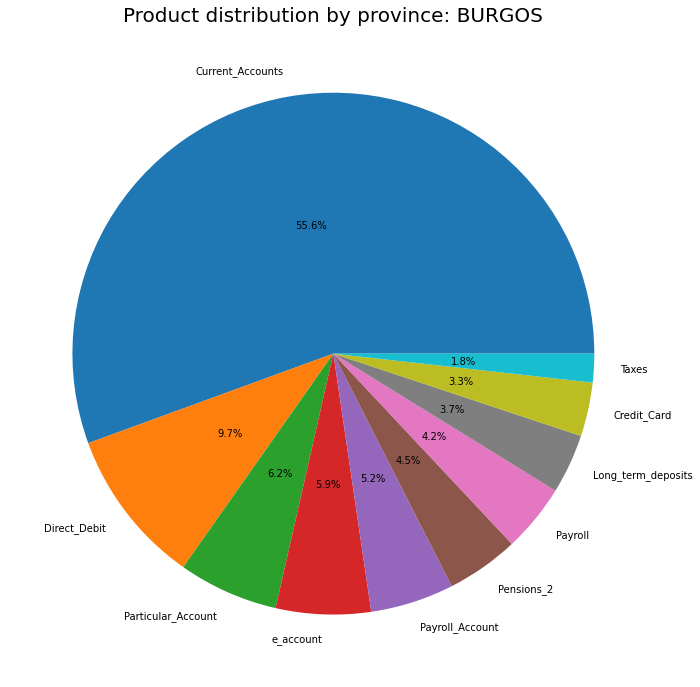

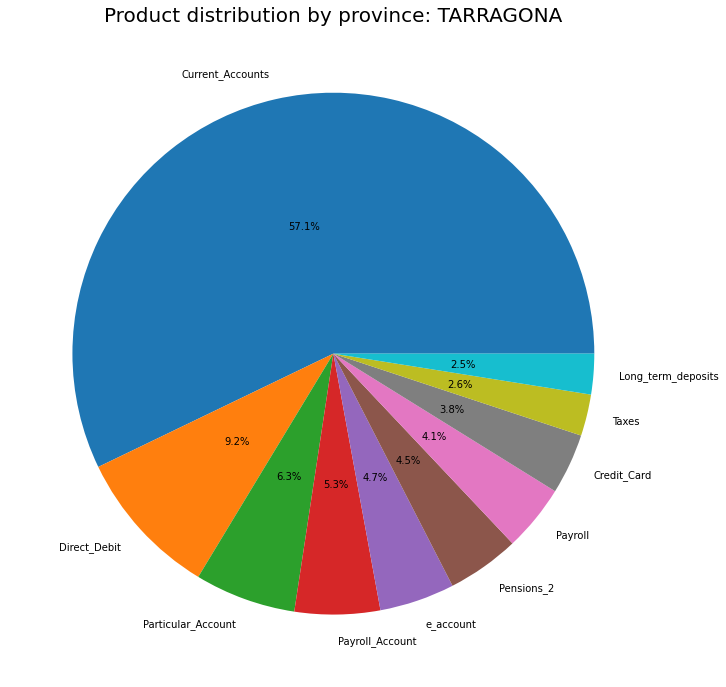

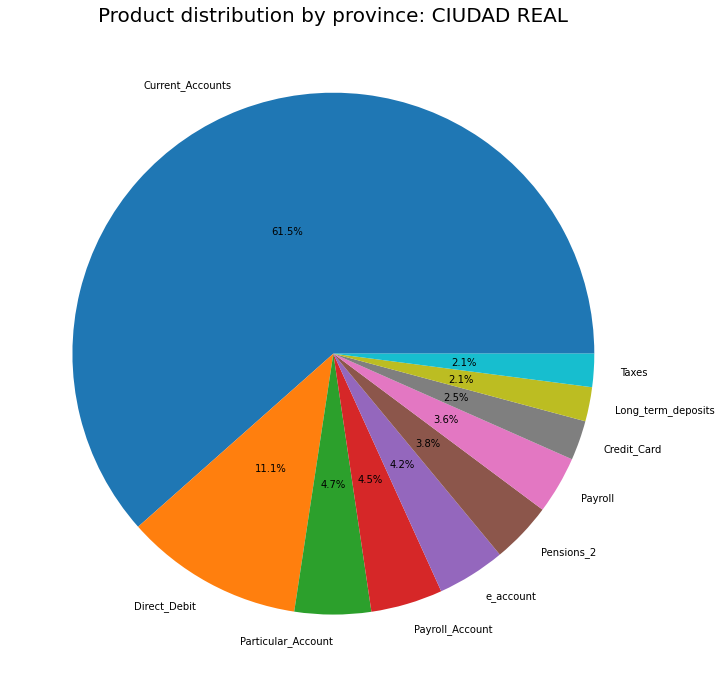

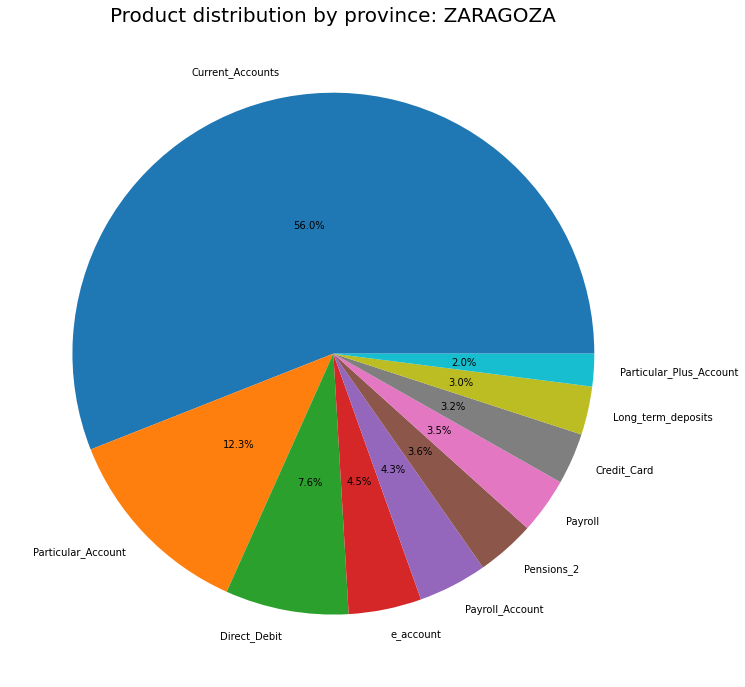

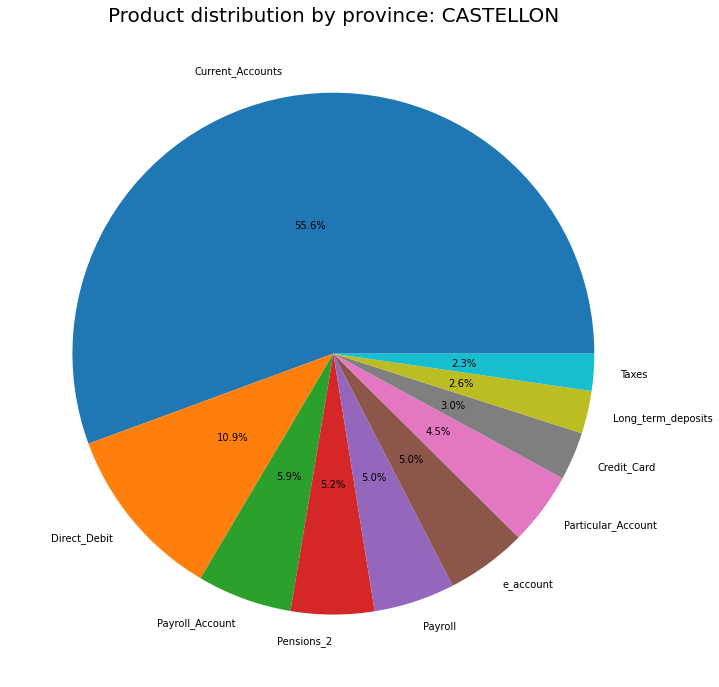

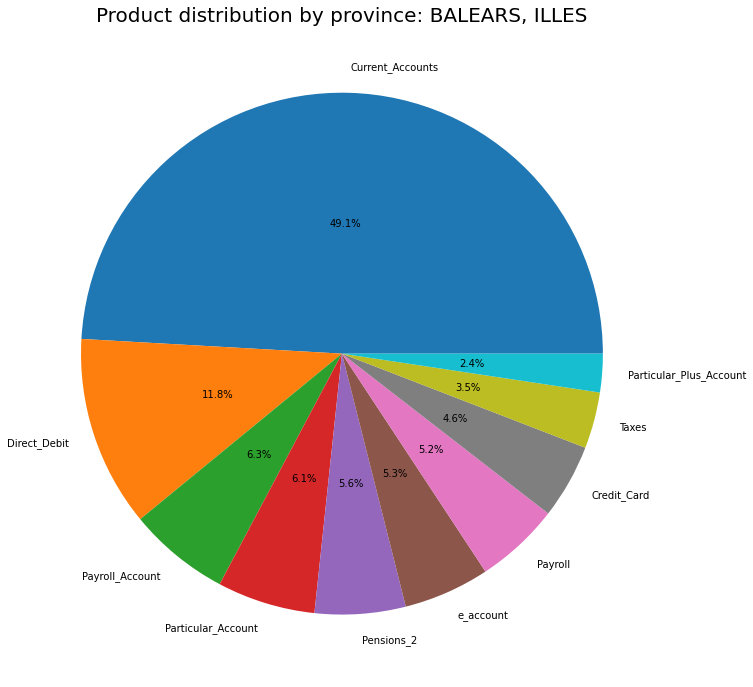

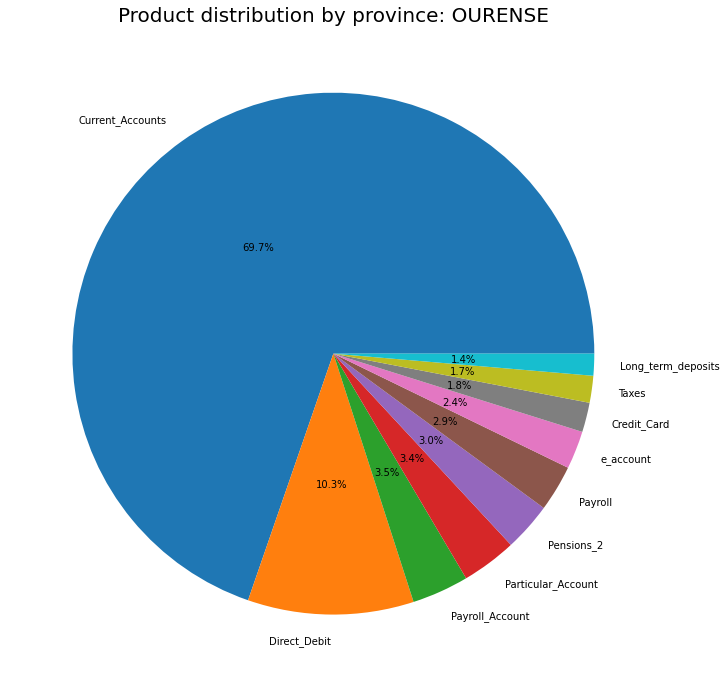

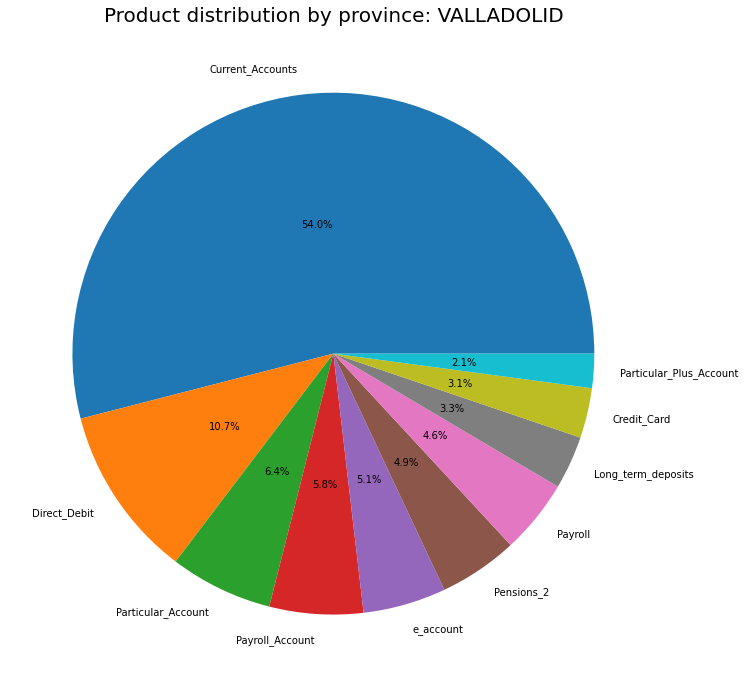

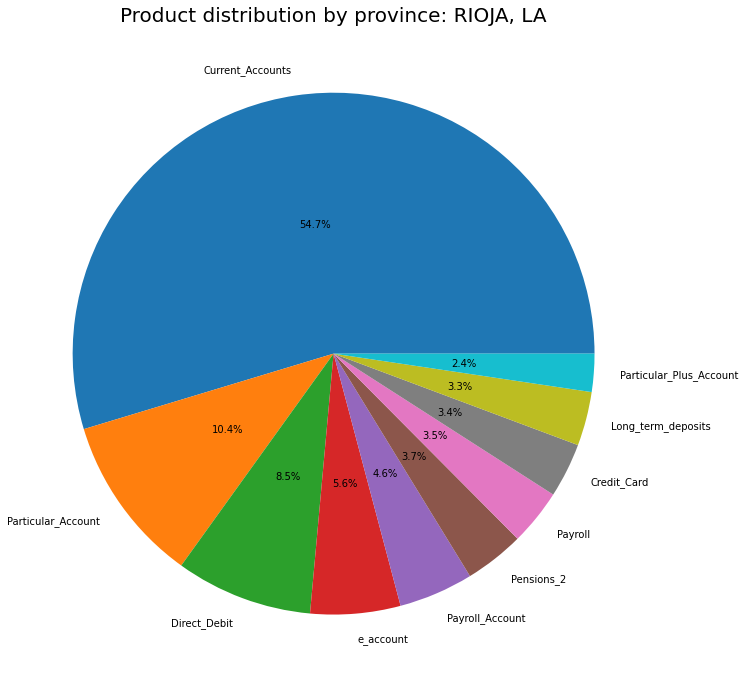

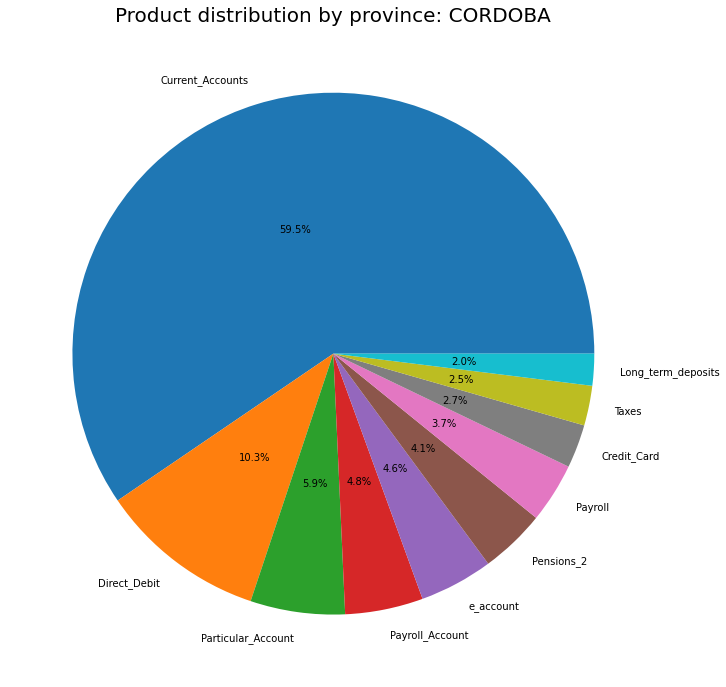

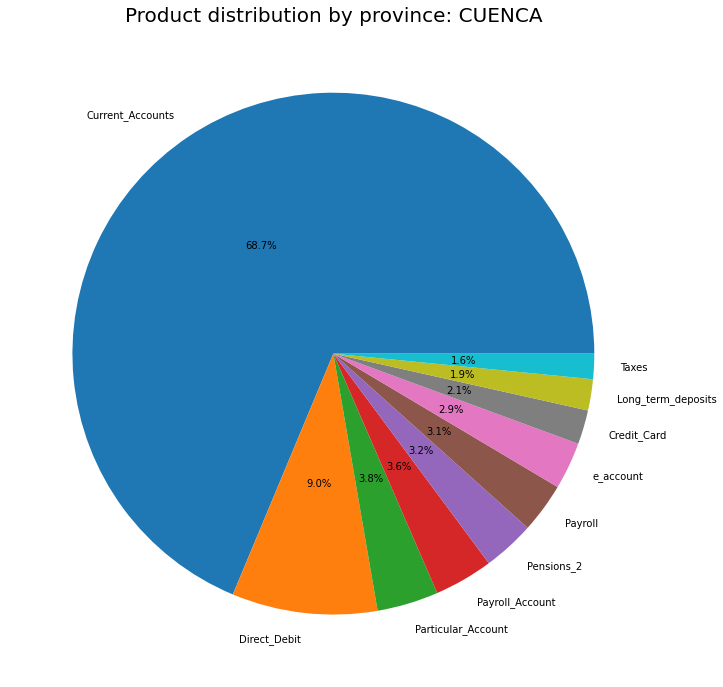

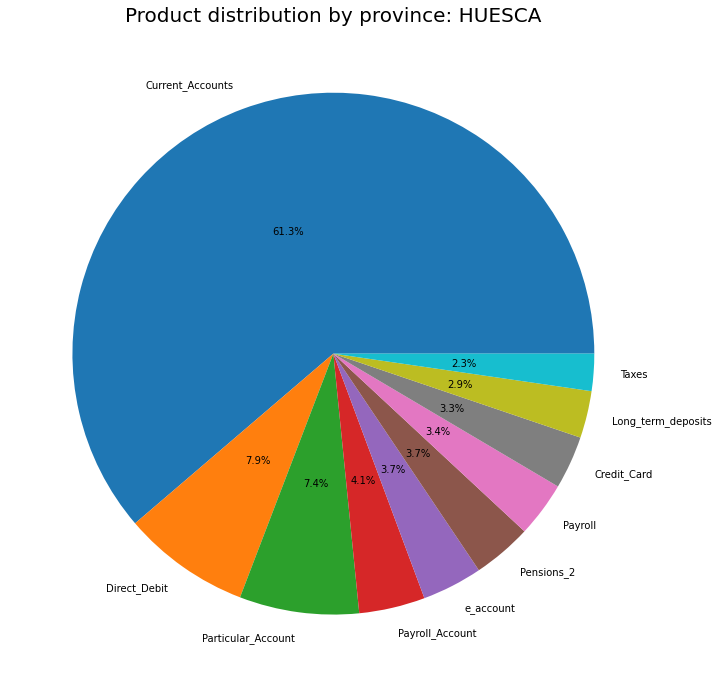

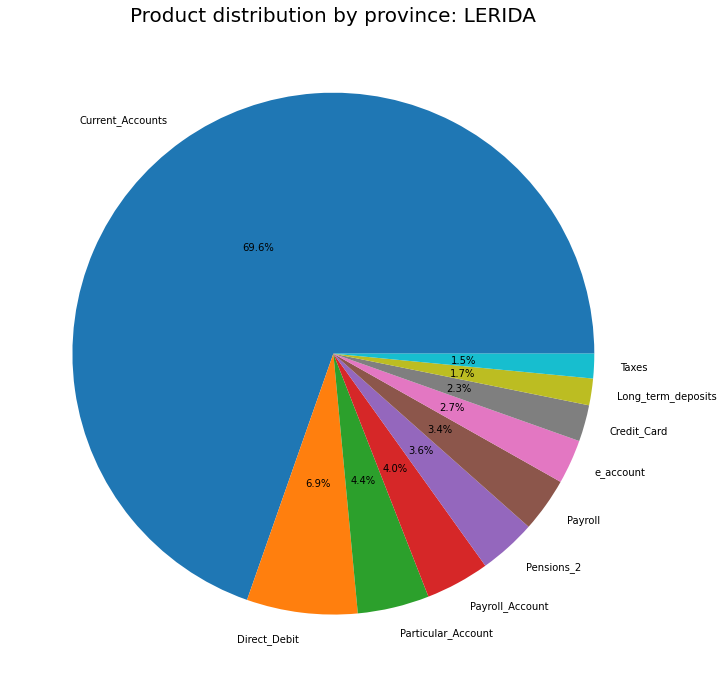

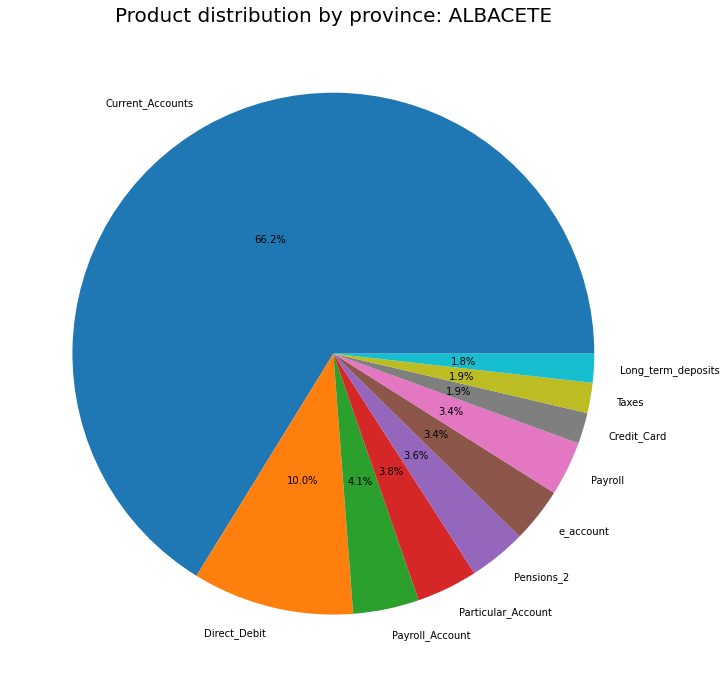

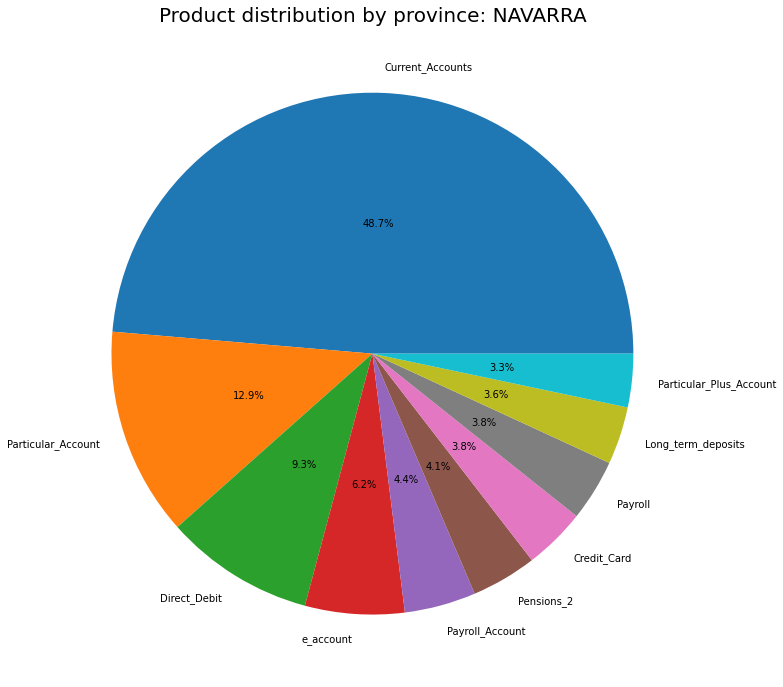

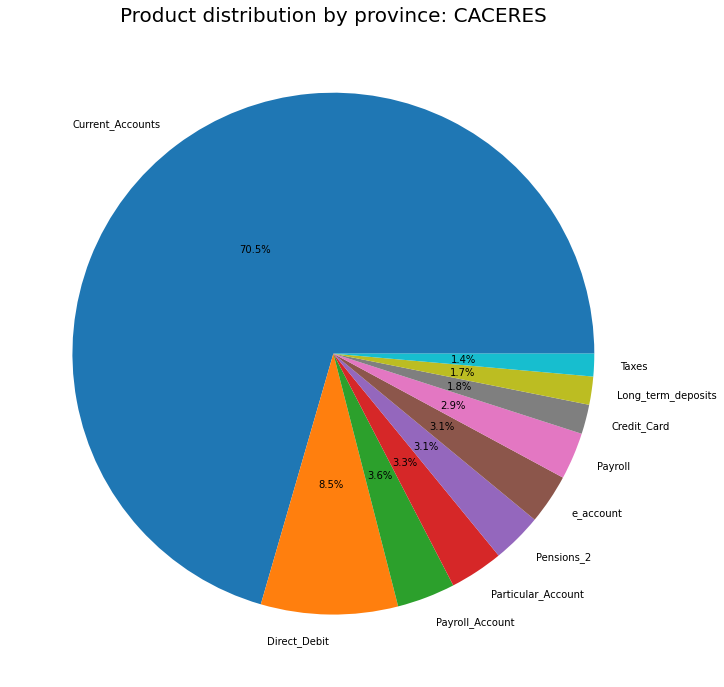

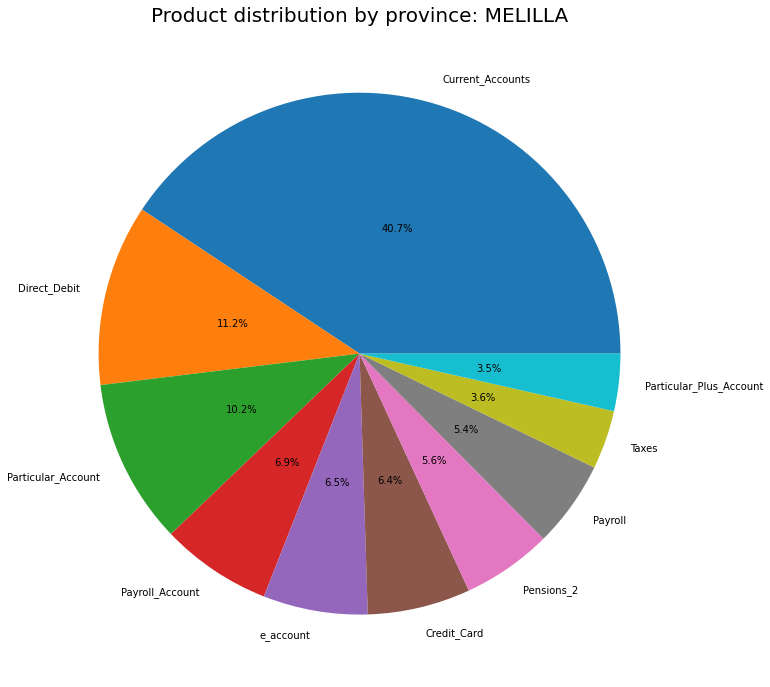

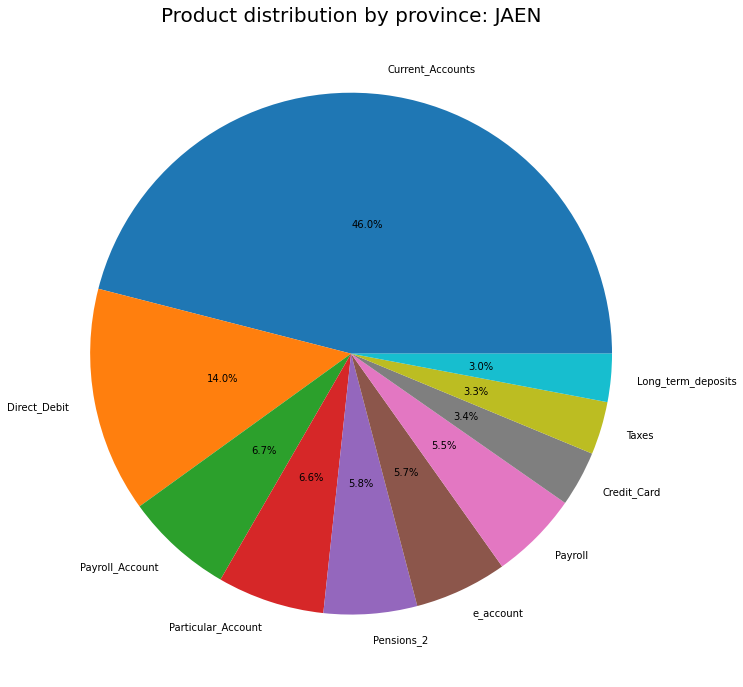

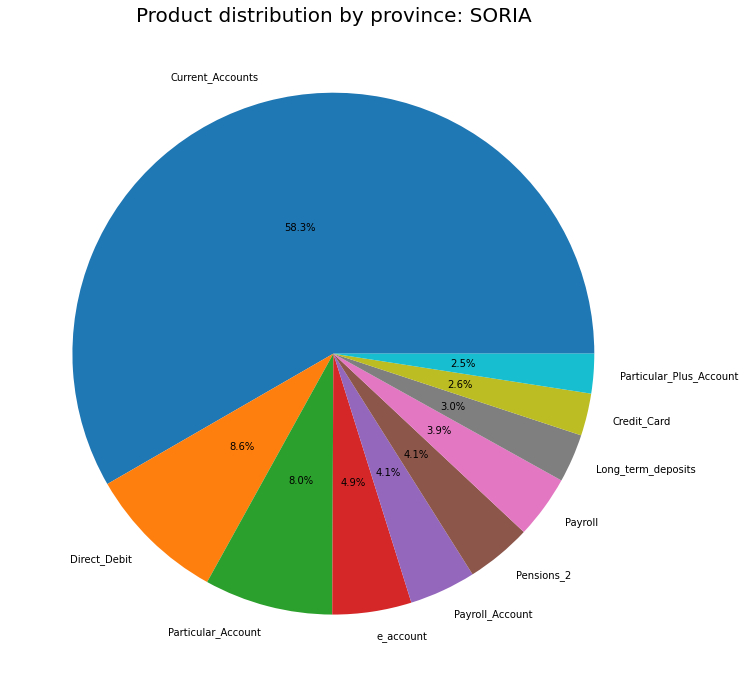

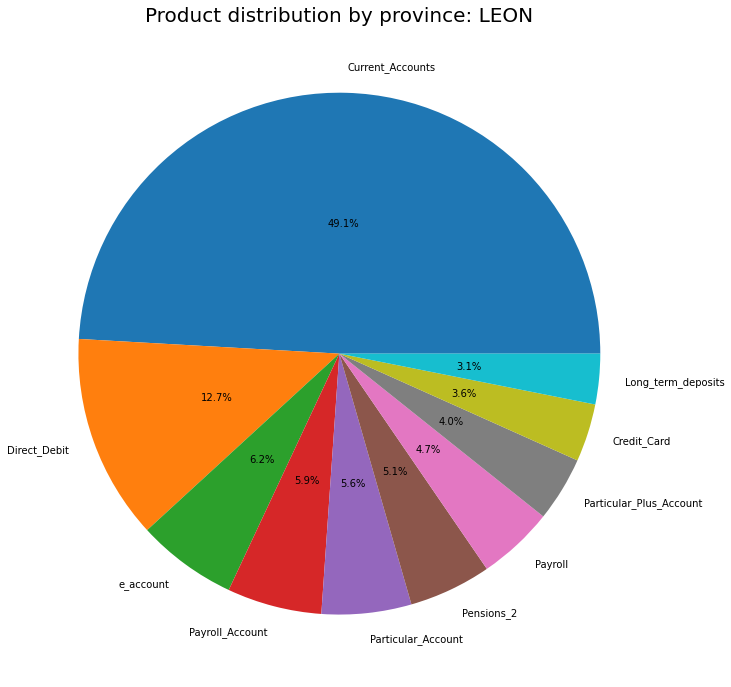

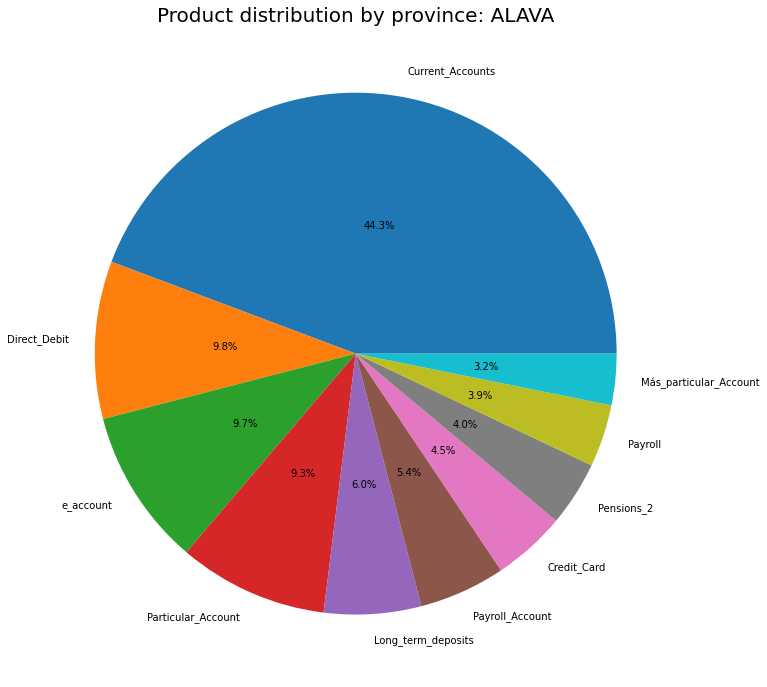

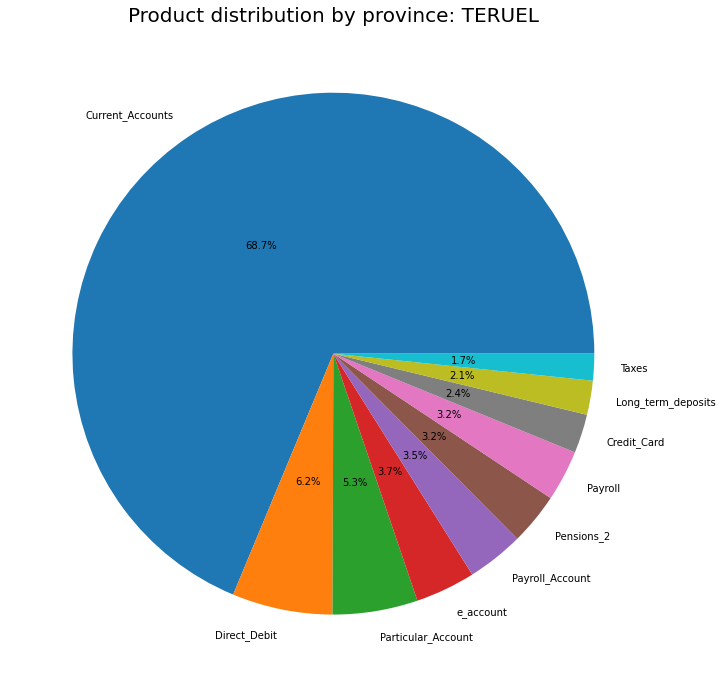

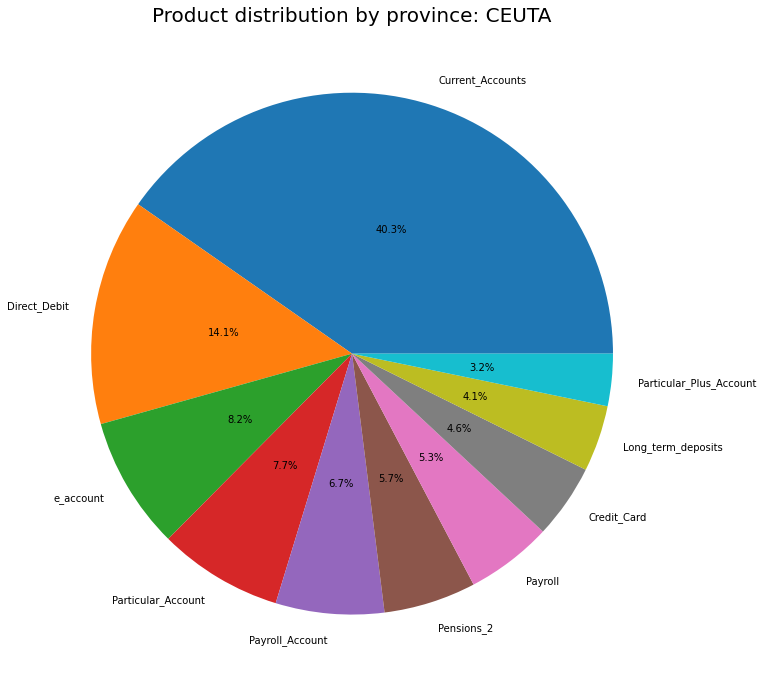

In [33]:
segm_groups = total_prod_by_cust.province_name.unique()
for province in segm_groups:
    data = total_prod_by_cust[products][total_prod_by_cust.province_name == province].sum().sort_values(ascending=False).head(10)
    pie_plot(data, [20,12], f'Product distribution by province: {province}', 20)

let's see each product by groups:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


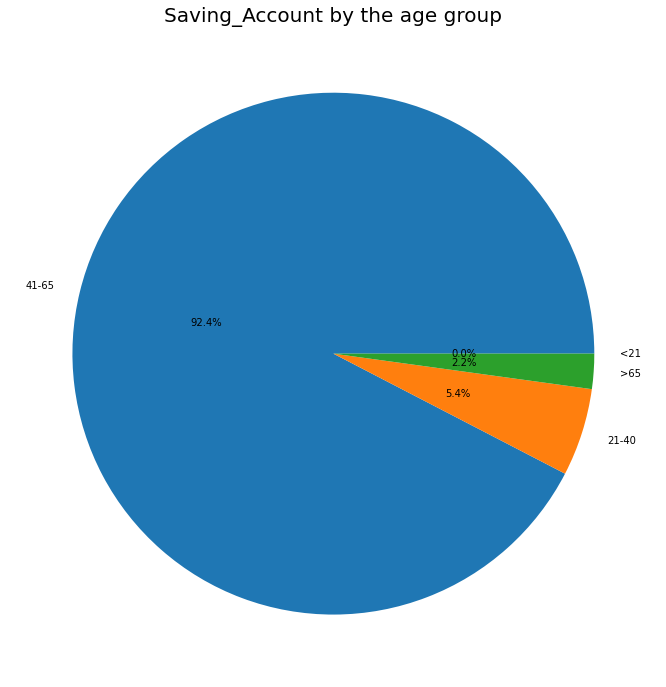

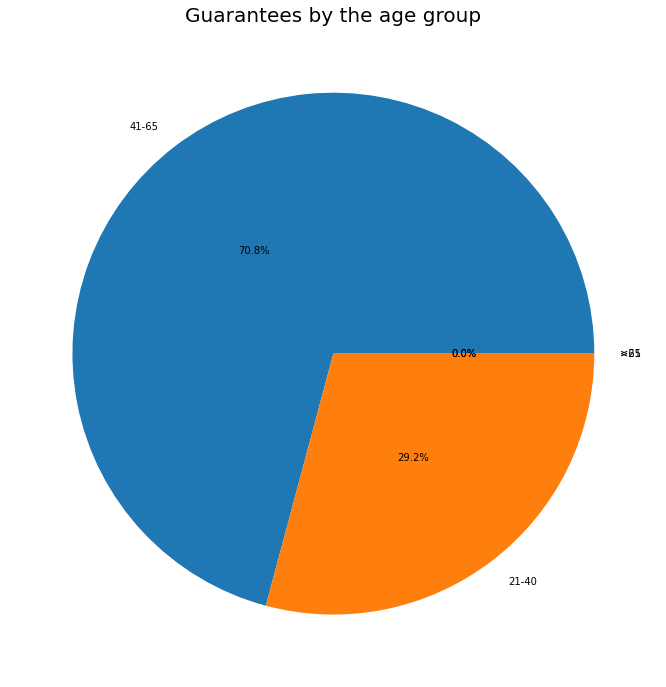

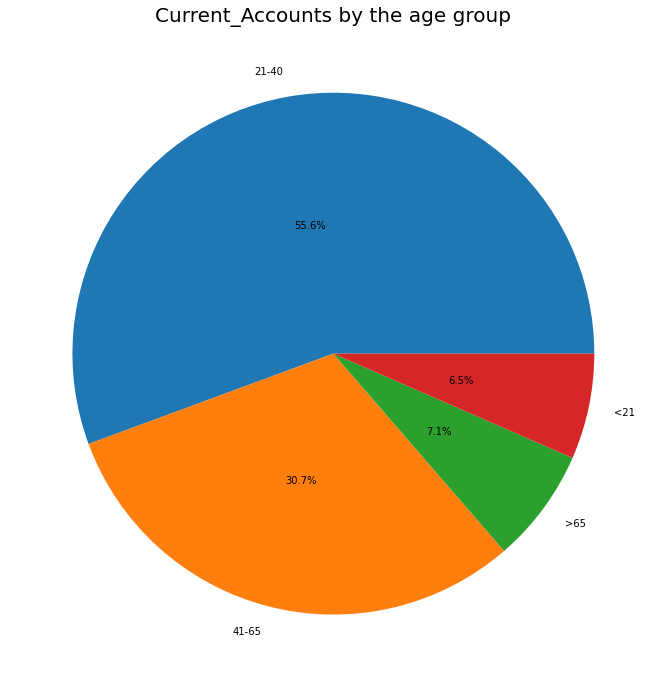

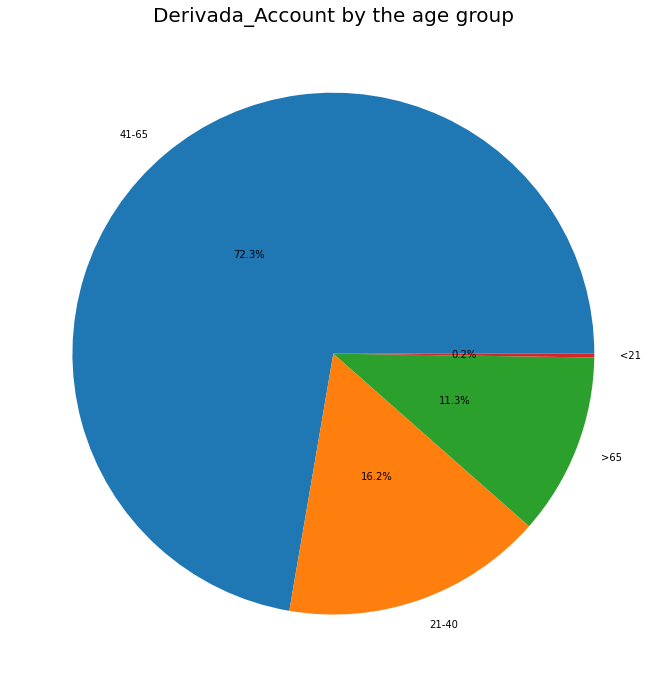

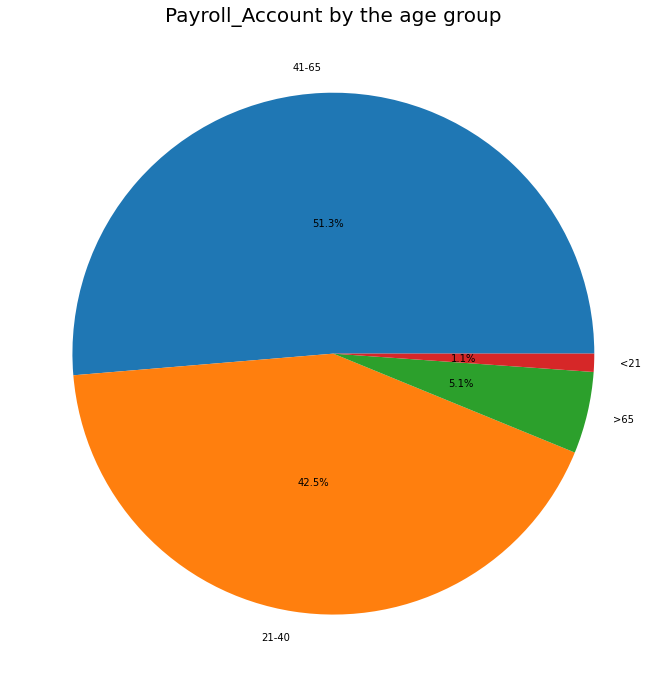

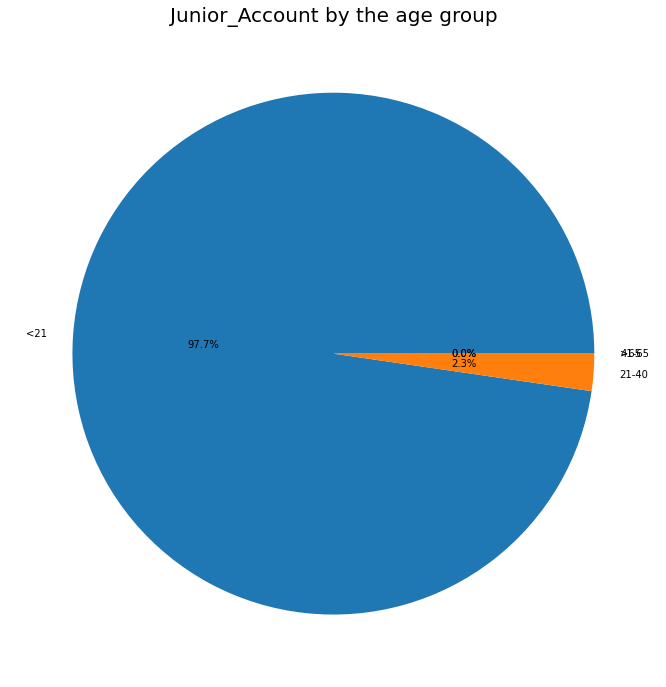

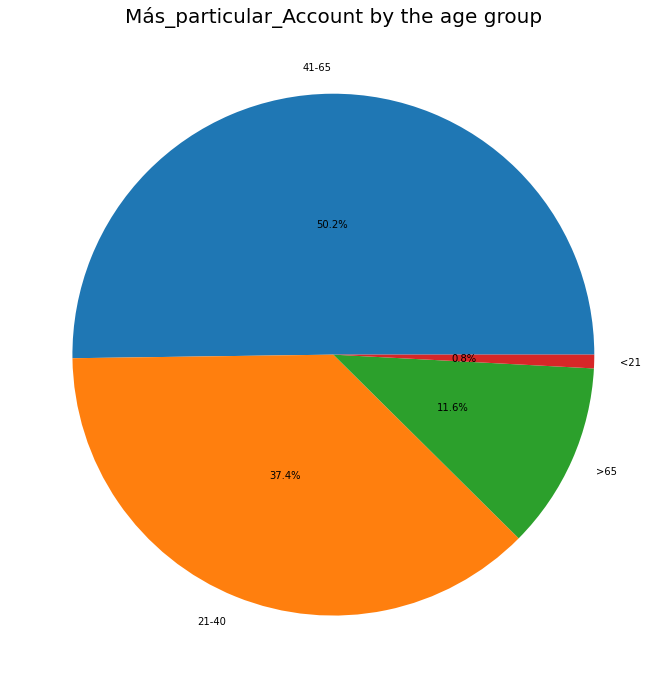

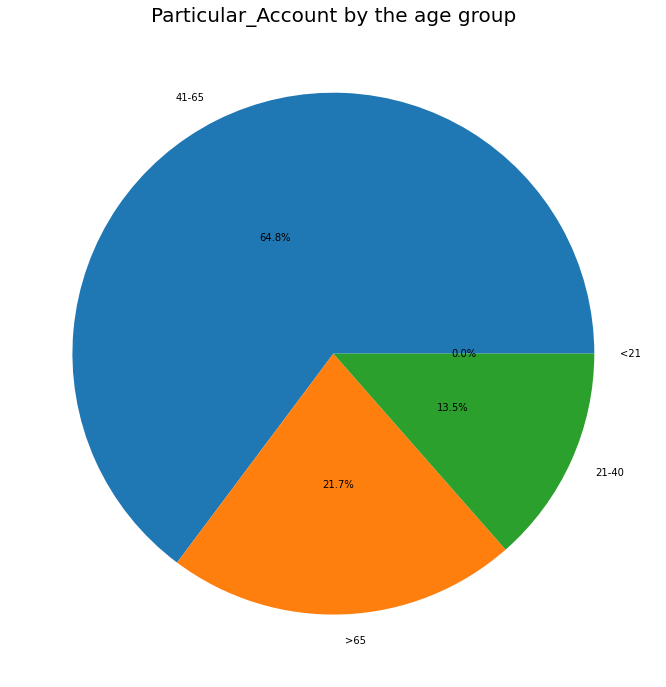

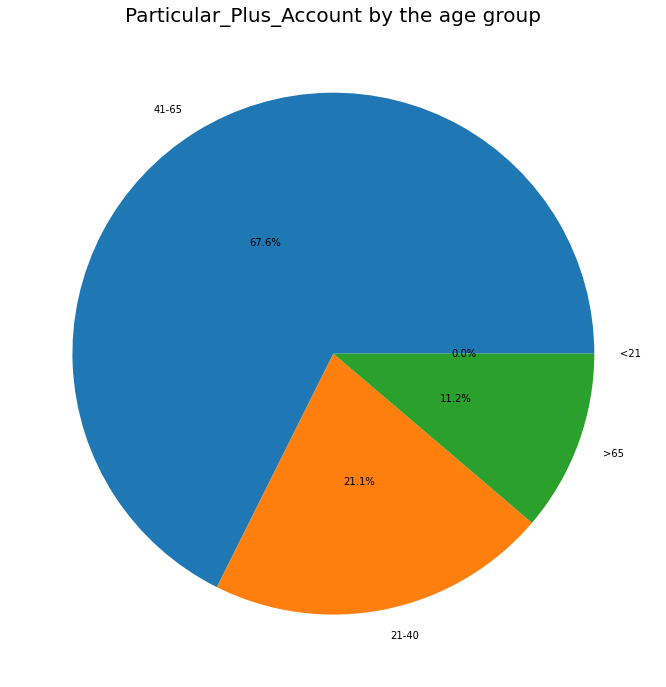

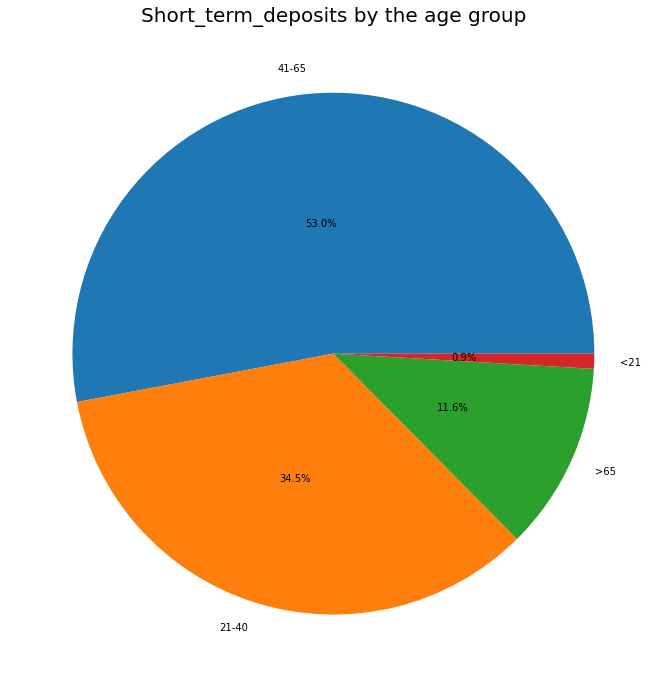

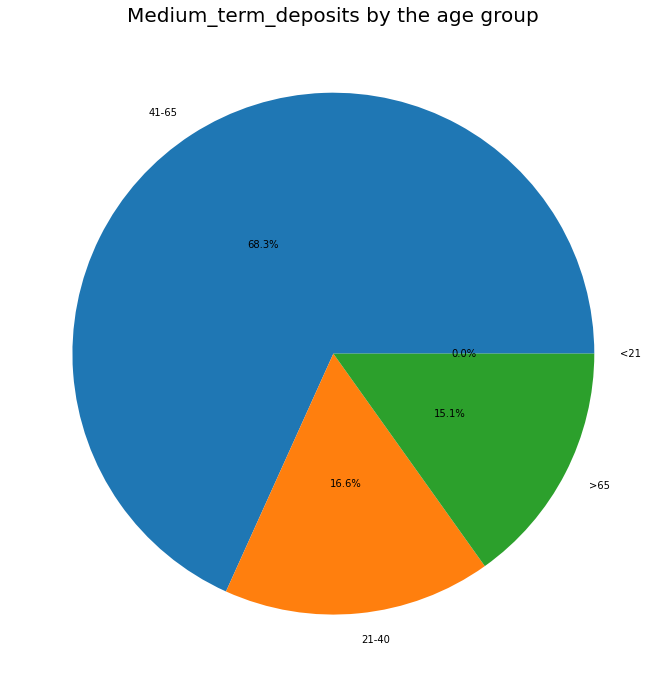

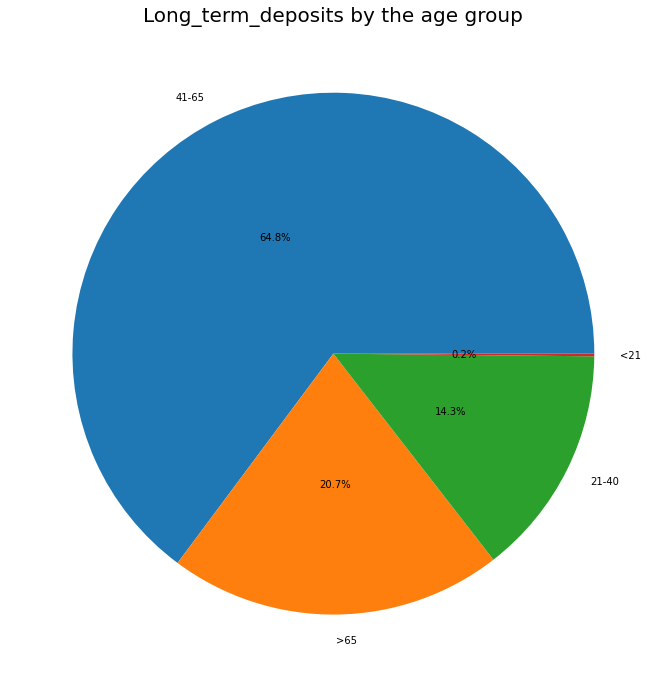

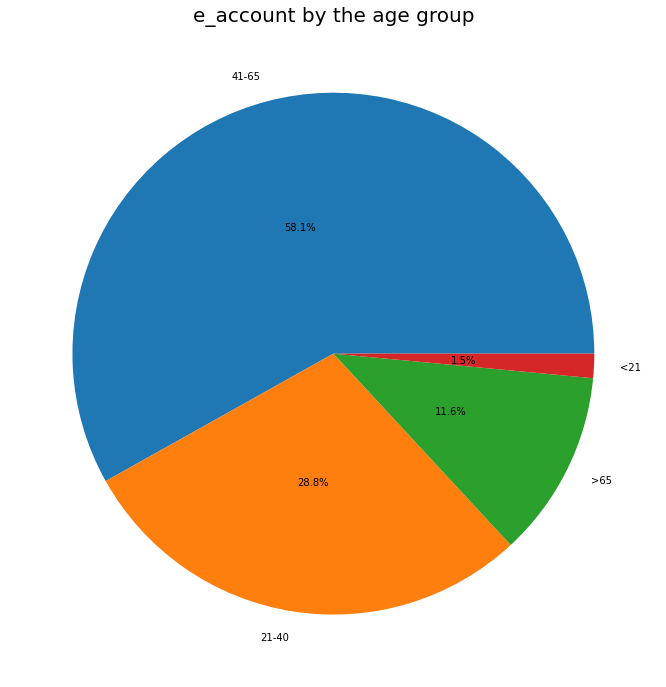

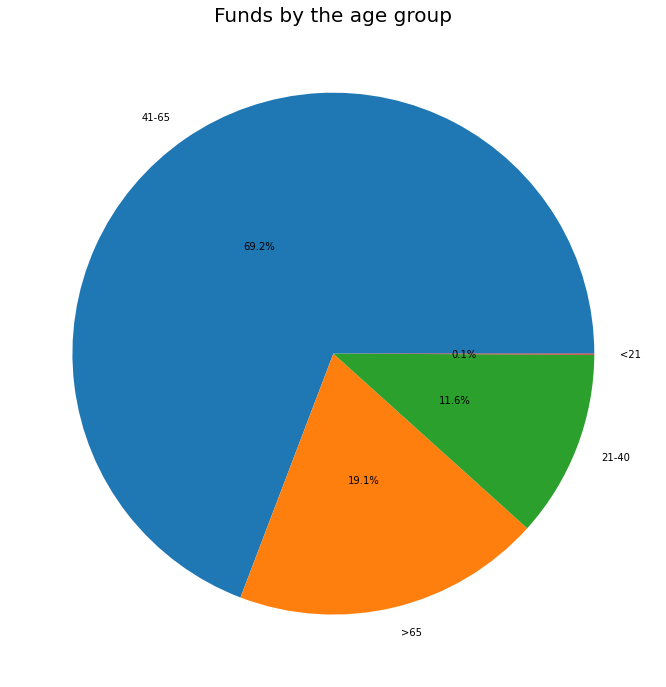

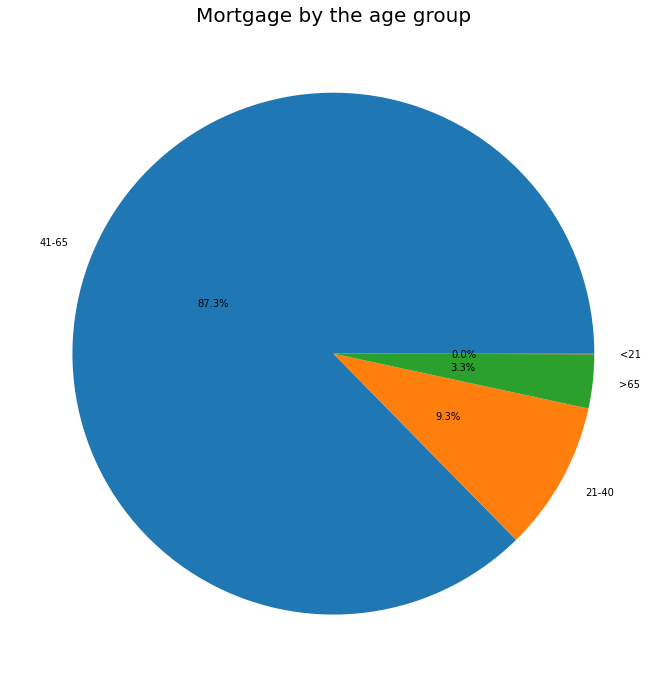

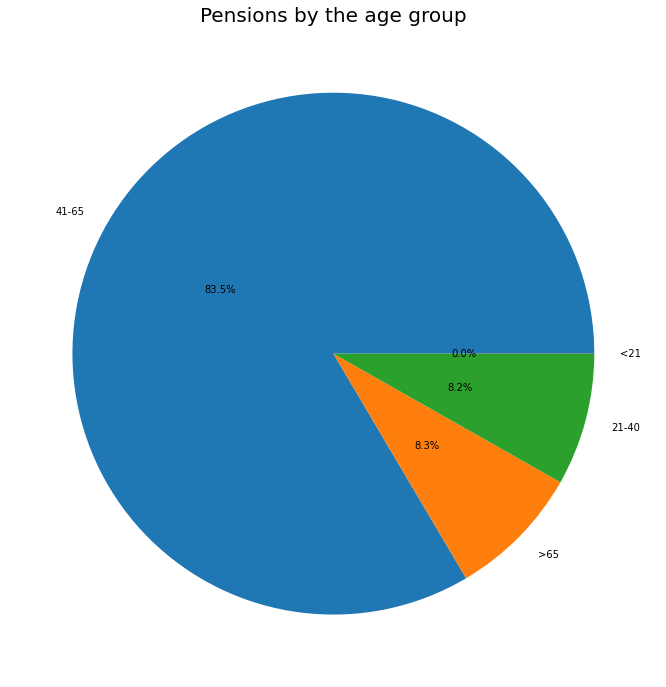

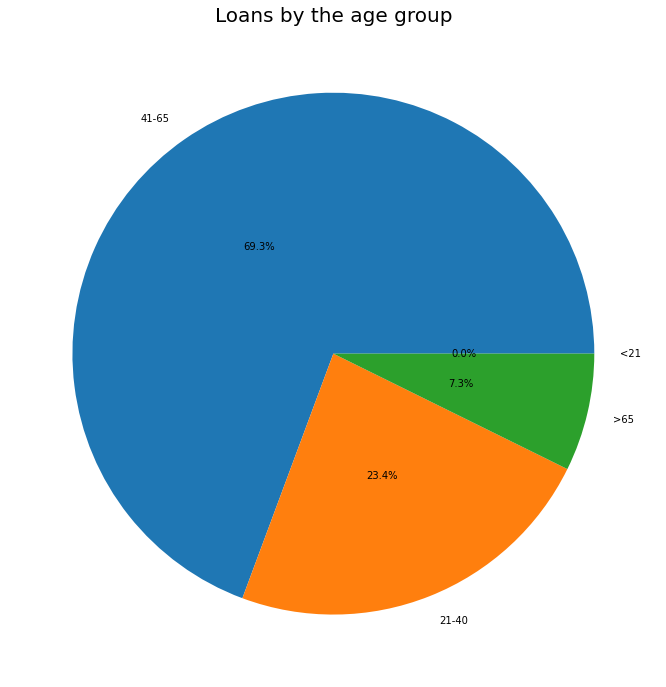

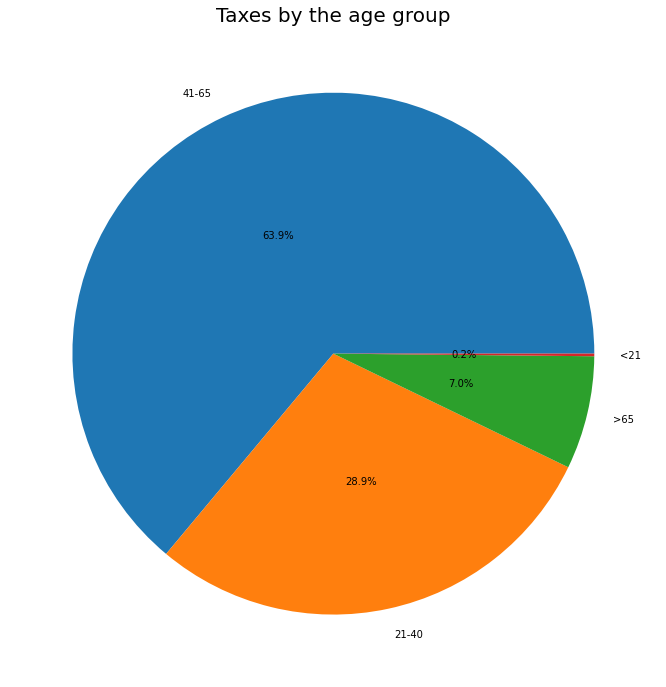

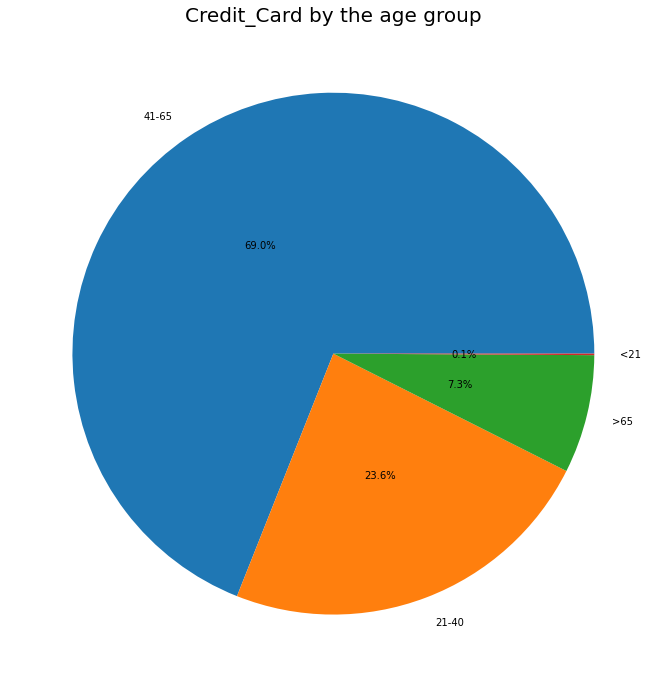

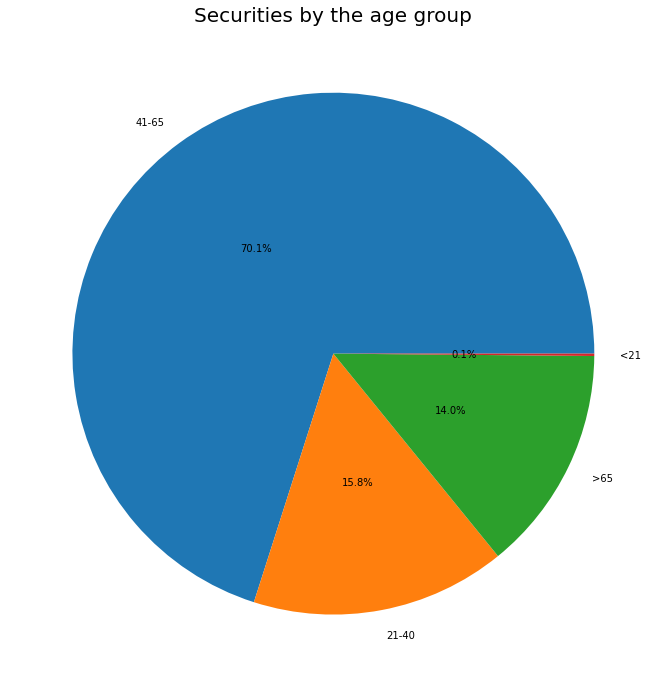

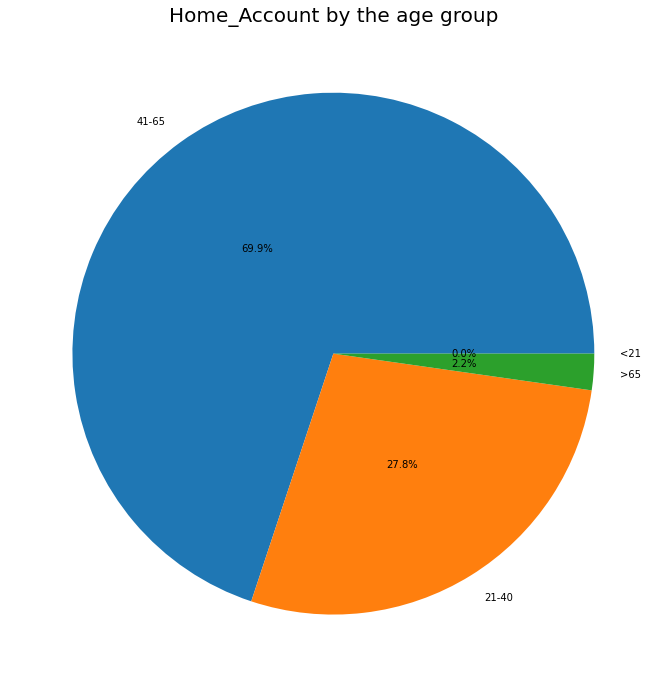

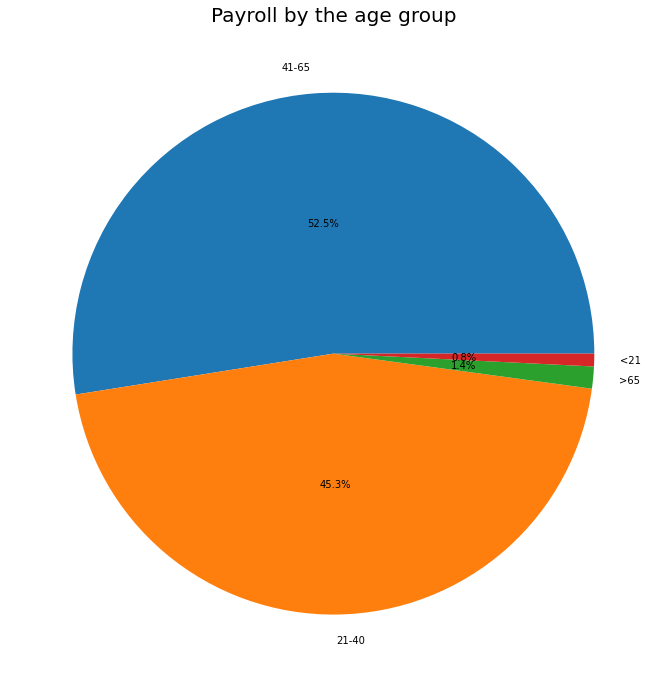

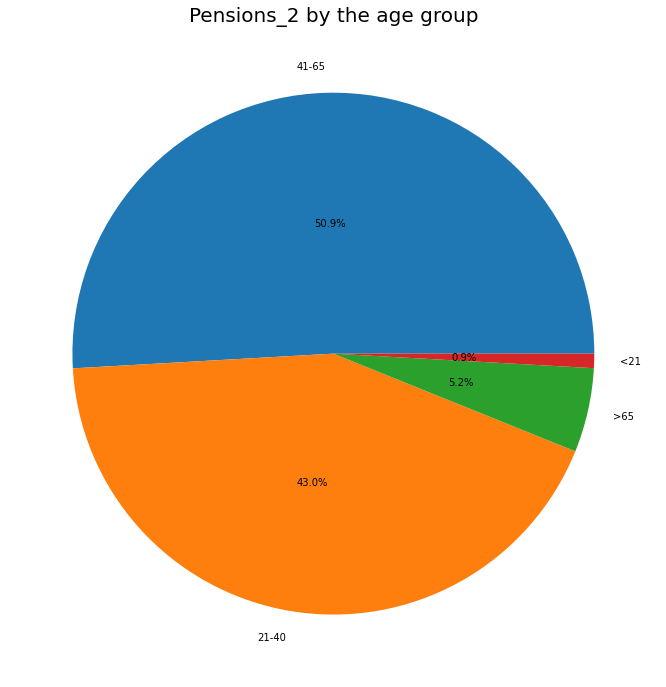

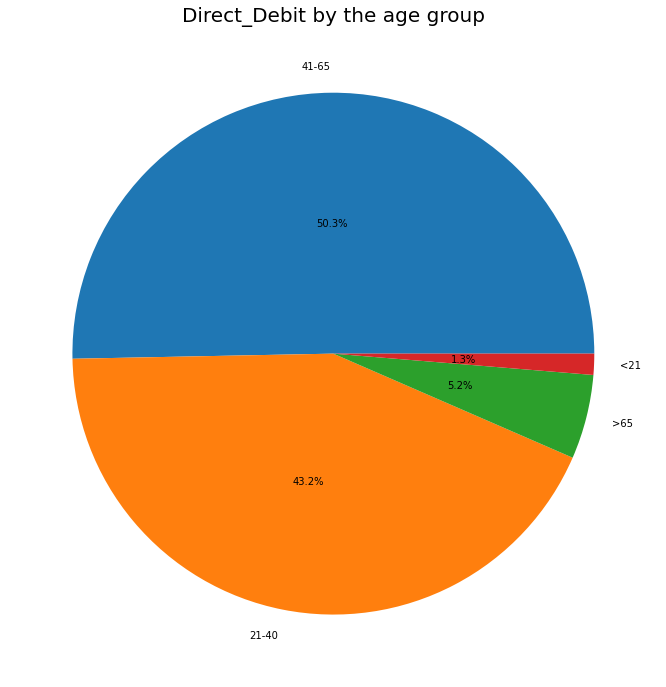

In [34]:
for prod in products:
    data = total_prod_by_cust[prod].groupby(total_prod_by_cust['age_group']).sum().sort_values(ascending=False)
    pie_plot(data, [20,12], f'{prod} by the age group', 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


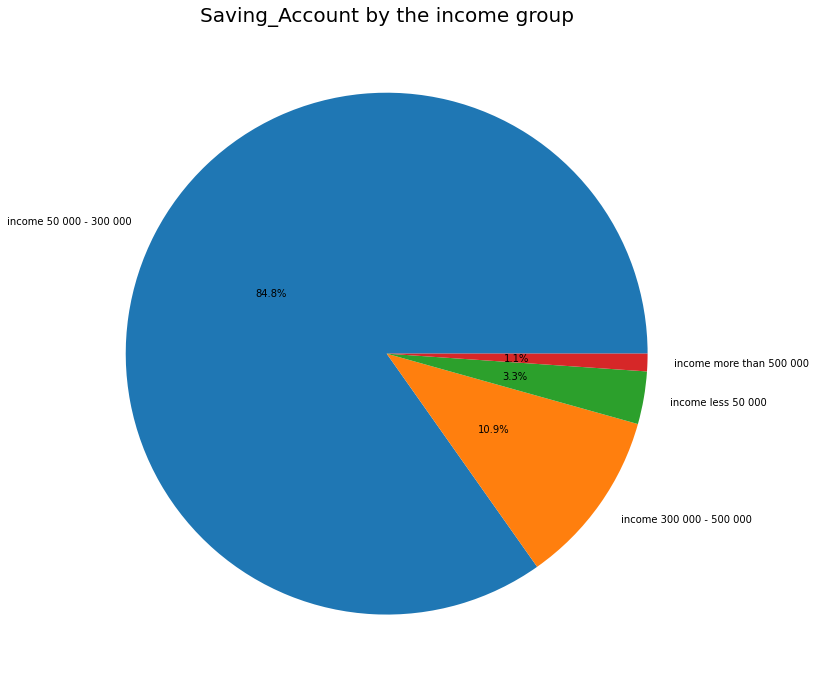

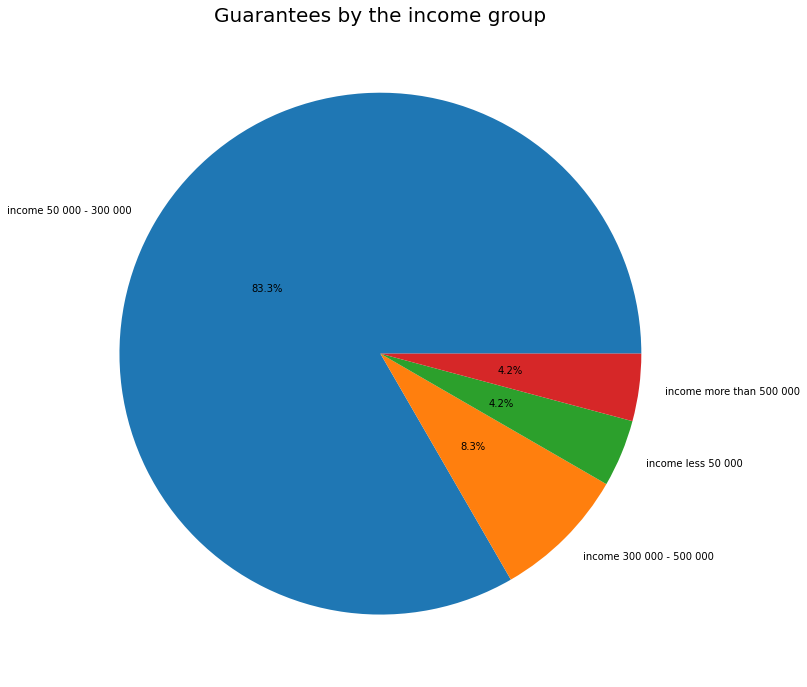

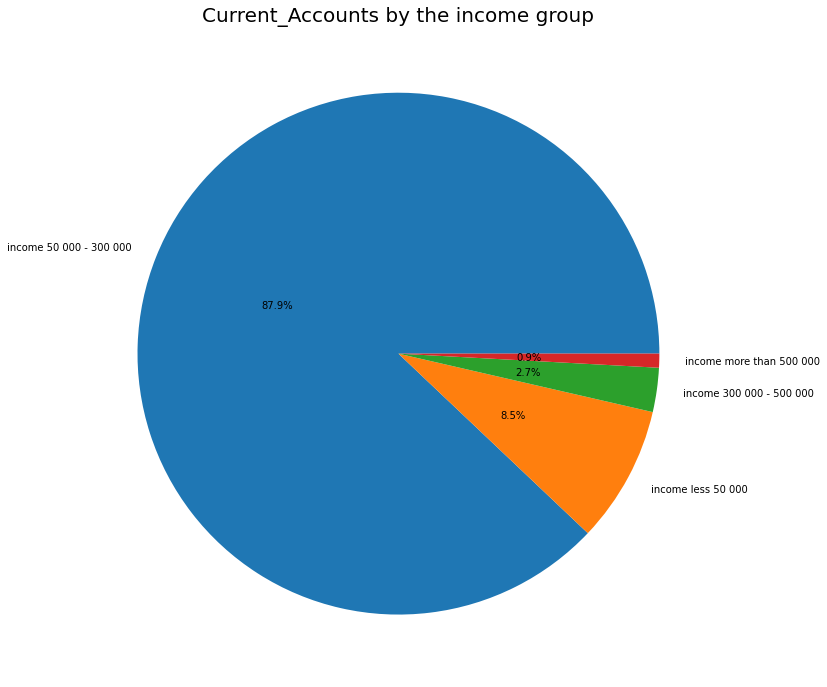

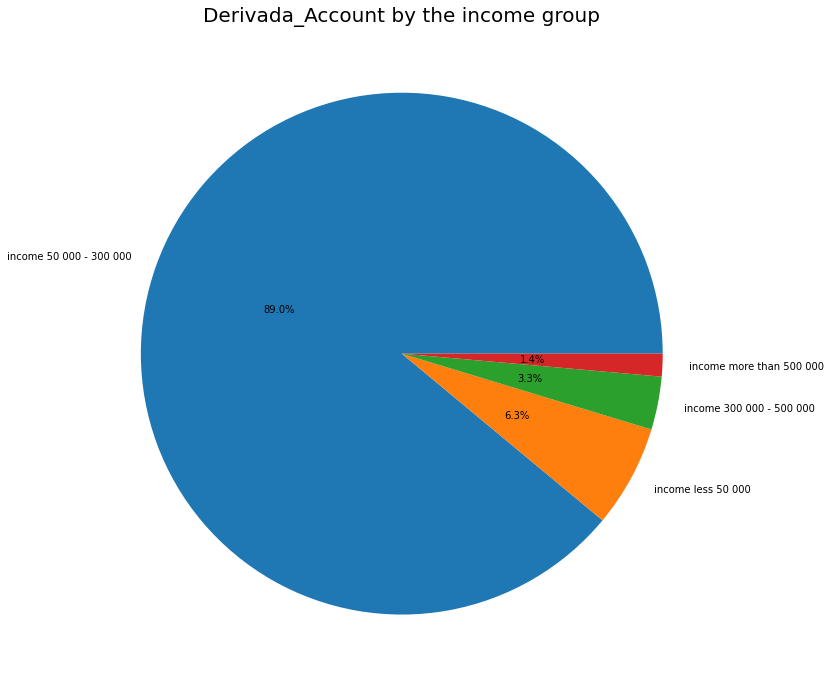

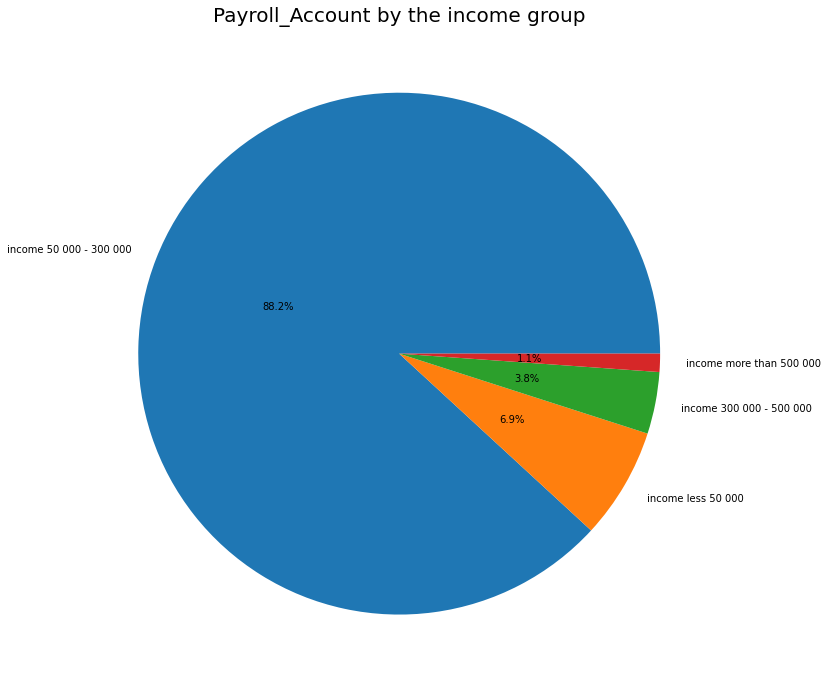

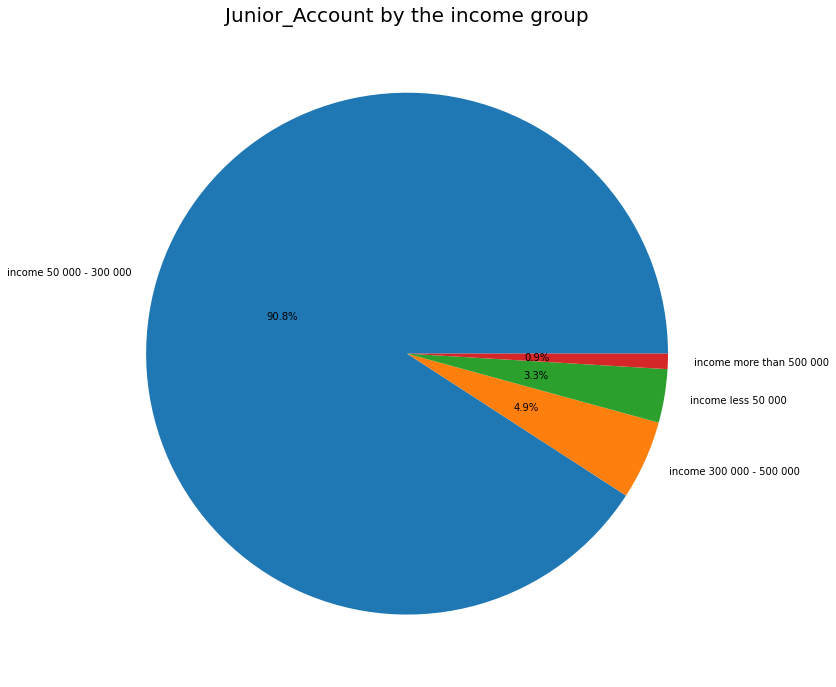

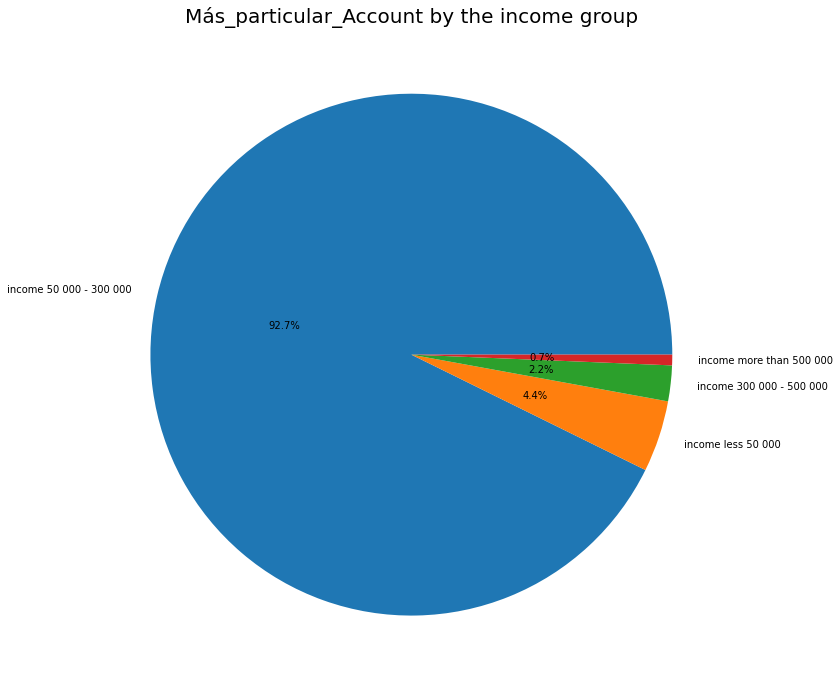

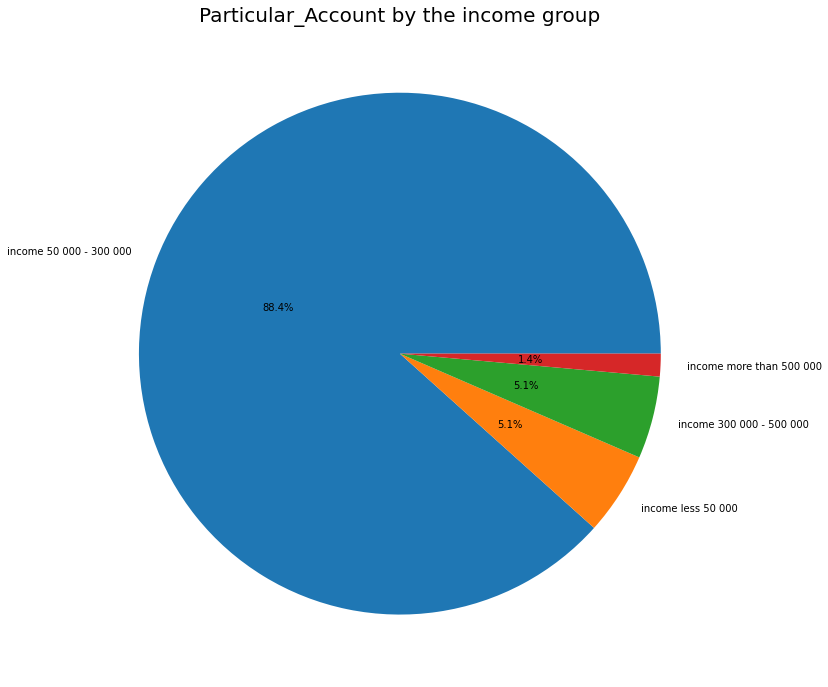

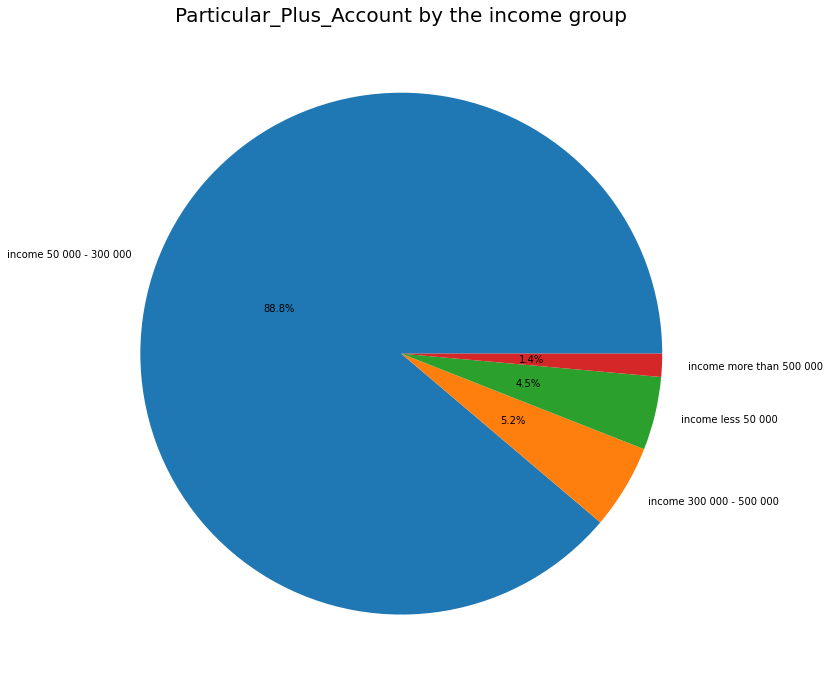

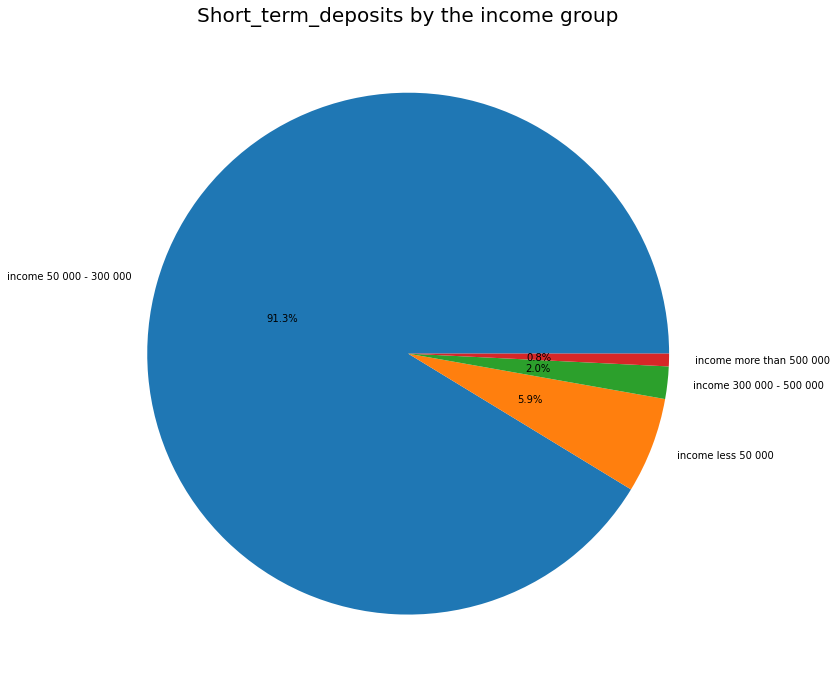

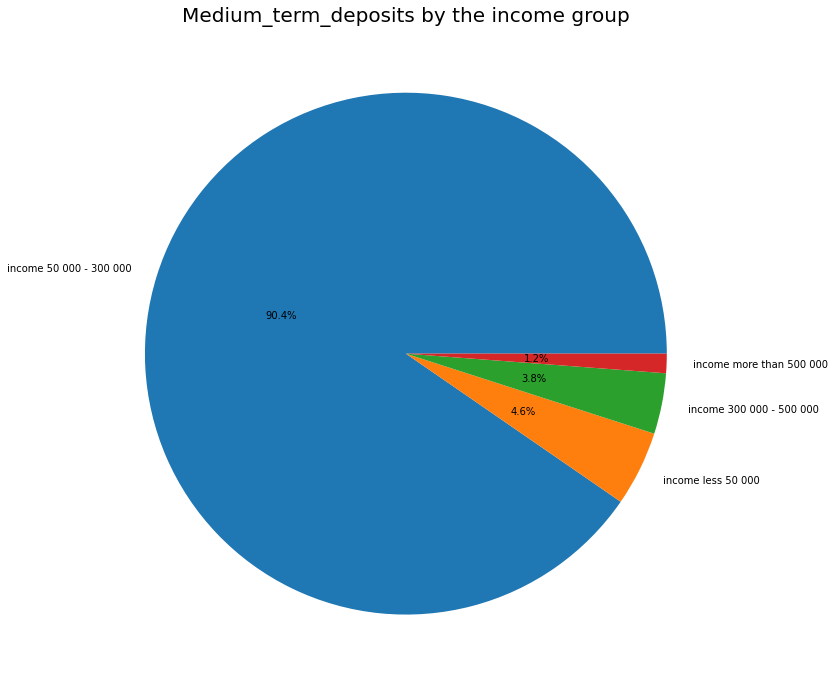

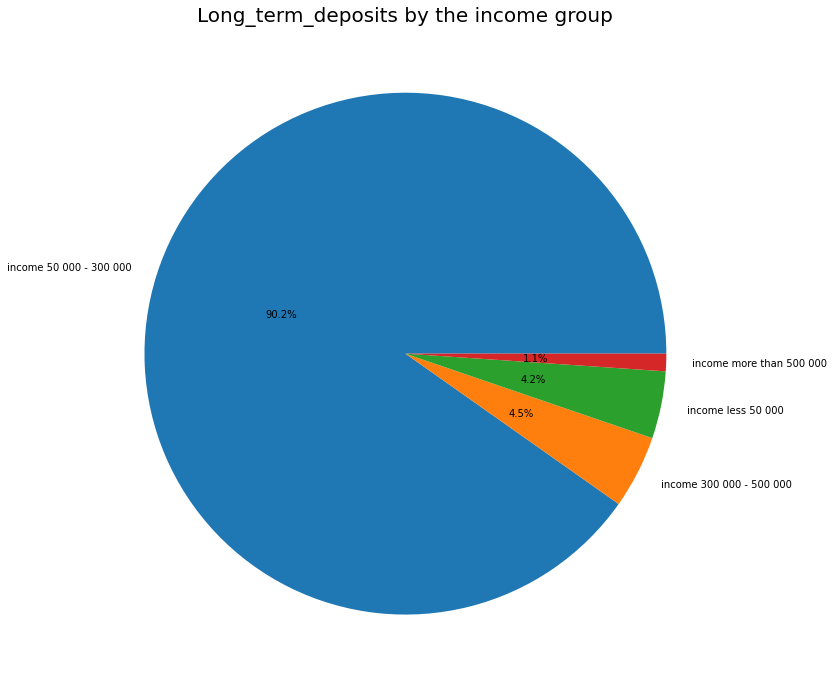

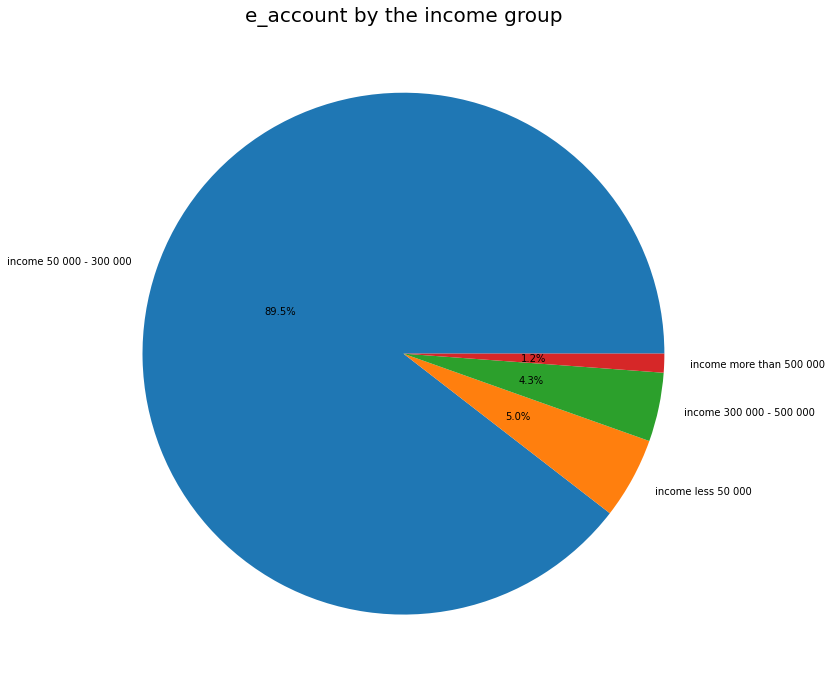

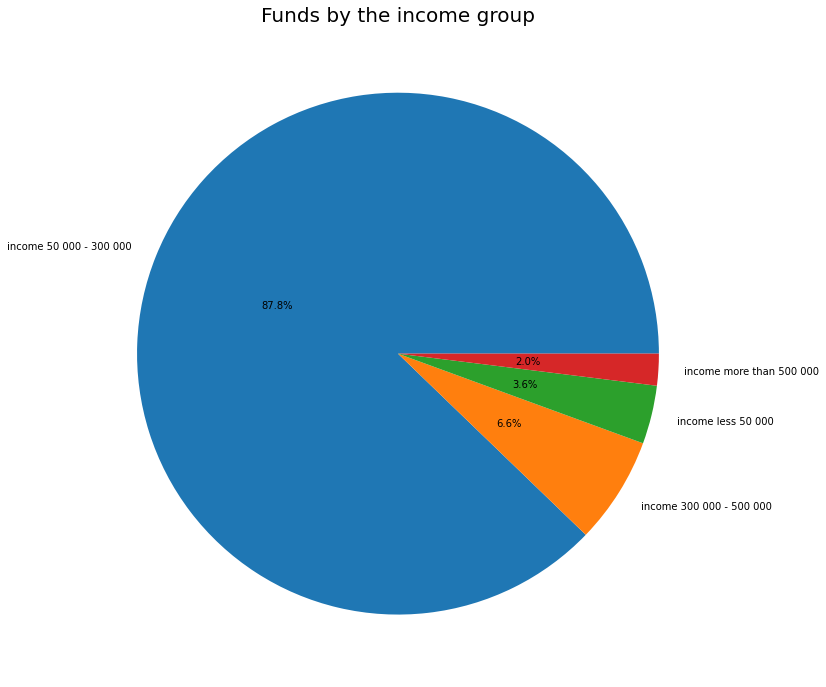

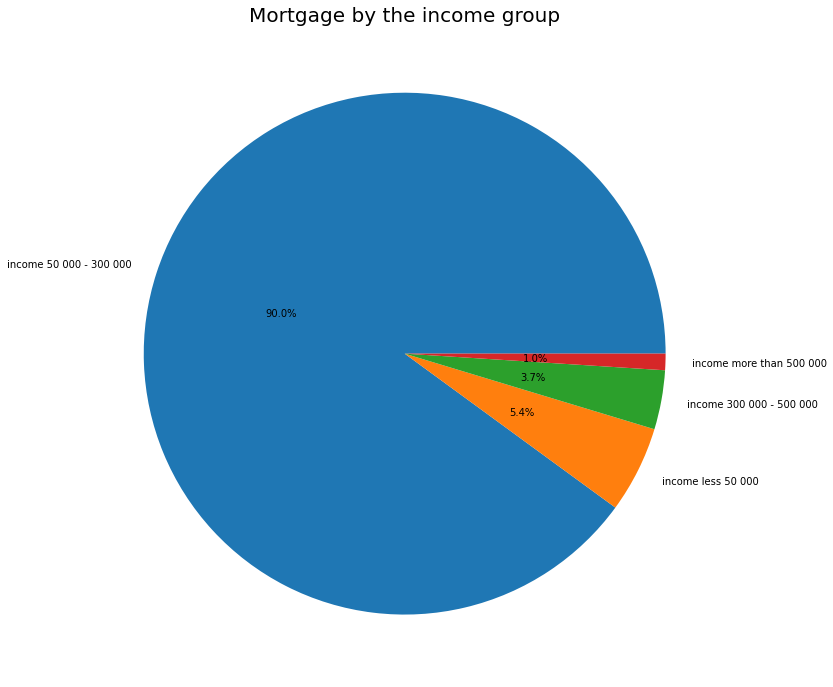

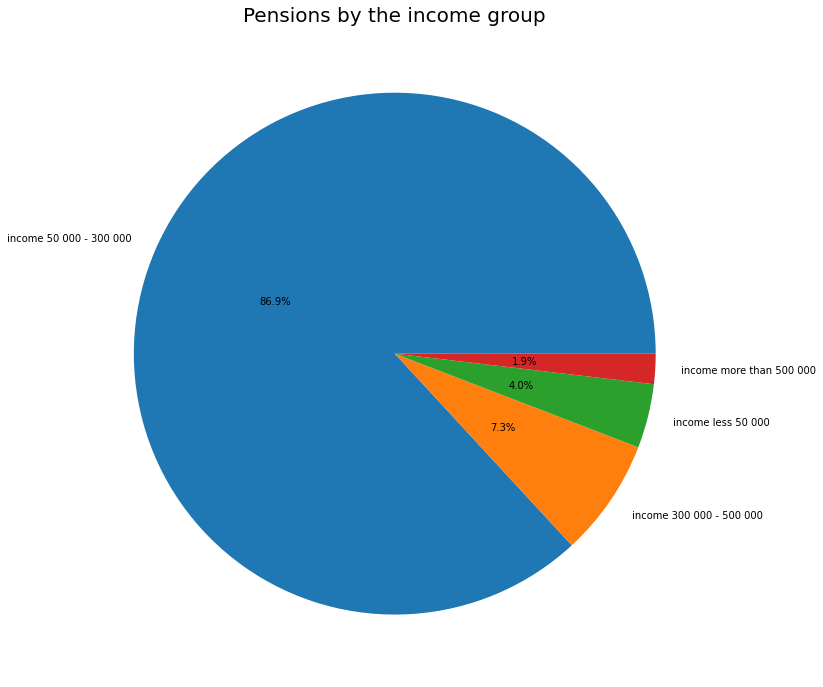

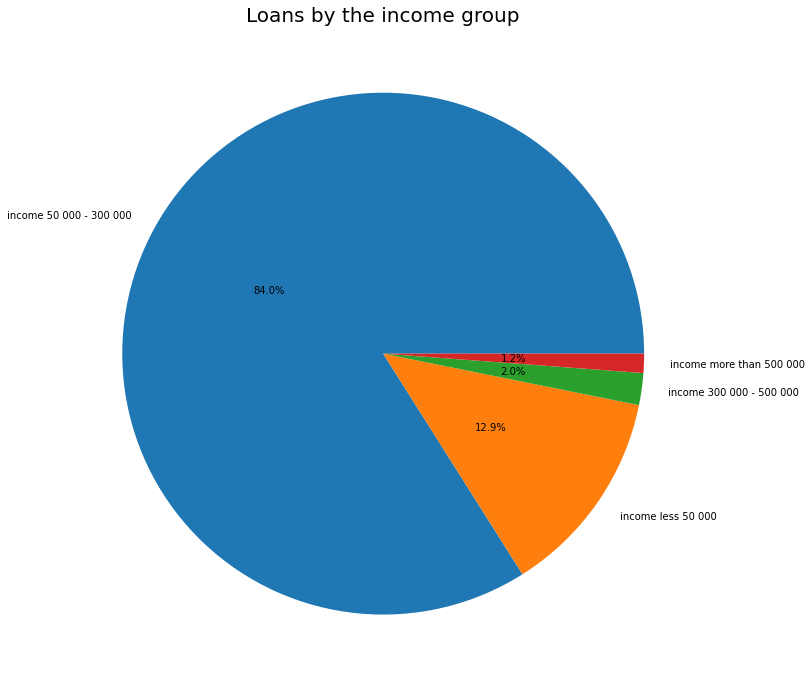

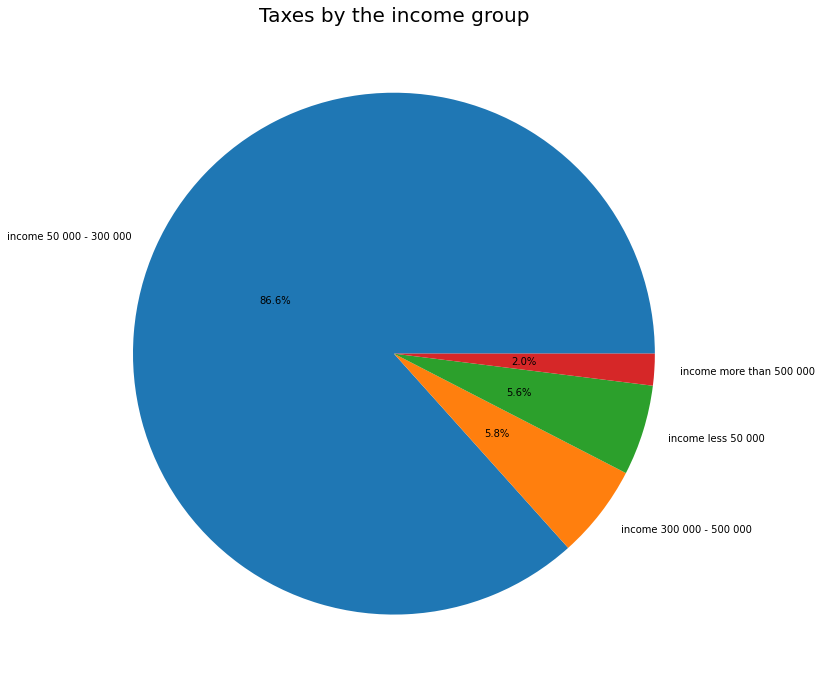

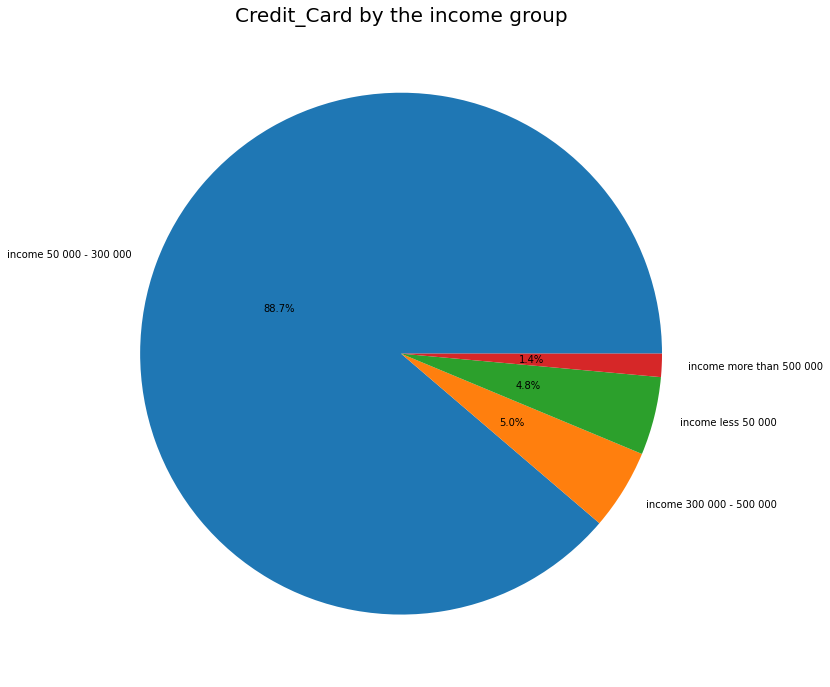

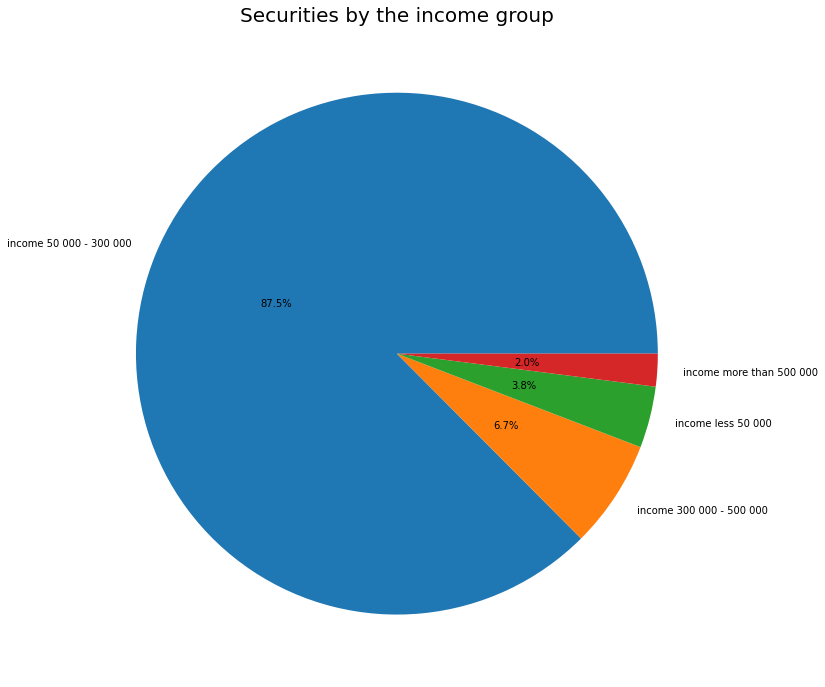

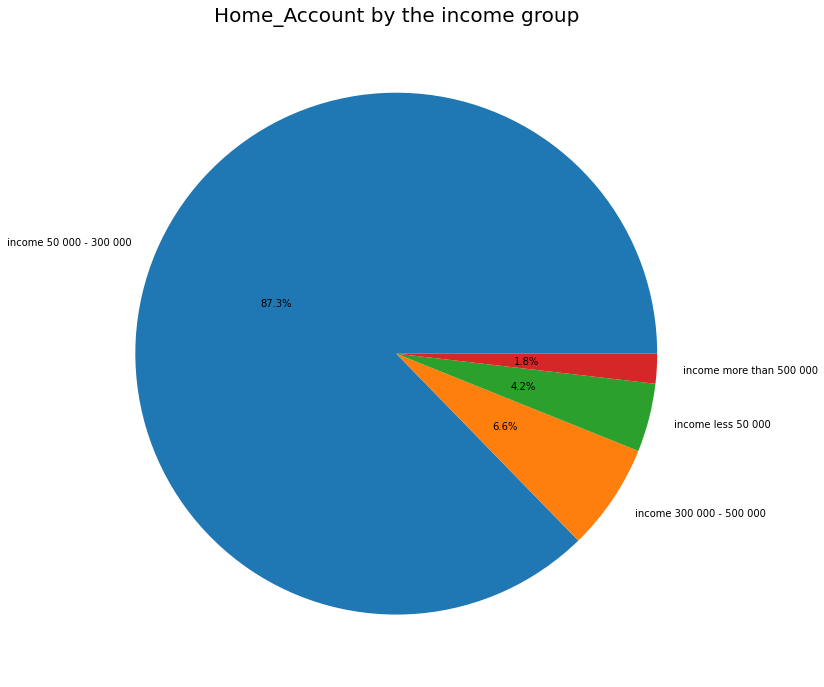

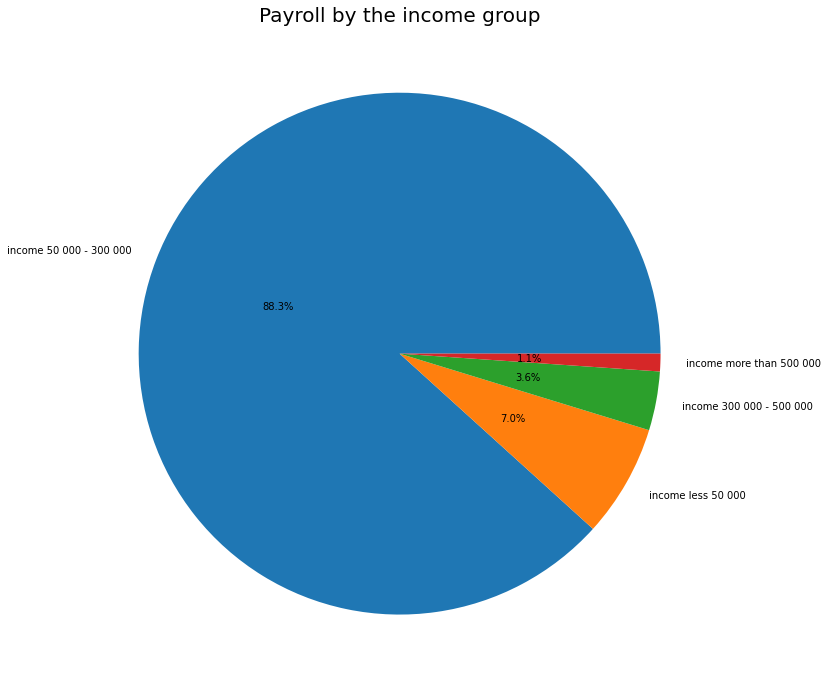

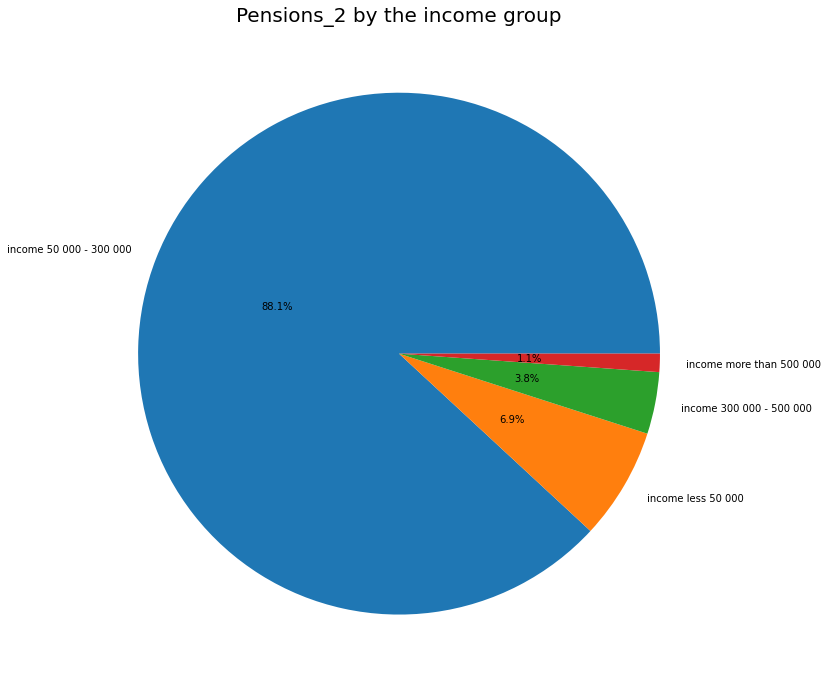

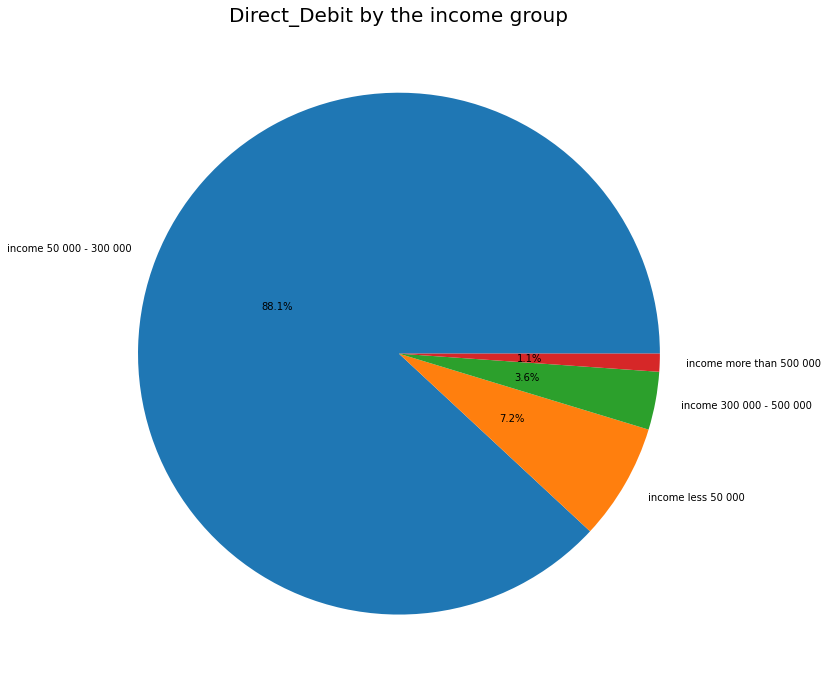

In [35]:
for prod in products:
    data = total_prod_by_cust[prod].groupby(total_prod_by_cust['income_group']).sum().sort_values(ascending=False)
    pie_plot(data, [20,12], f'{prod} by the income group', 20)

Let's see which products the most popular for people who have saving account, guarantee etc.

In [36]:
for num, prod in enumerate(products):
    data = dict(total_prod_by_cust[total_prod_by_cust[prod] == 1][products[:num]+products[num+1:]].sum().sort_values(ascending=False).head(5))
    print(prod, data.keys())

Saving_Account dict_keys(['Current_Accounts', 'Particular_Account', 'Direct_Debit', 'Taxes', 'Particular_Plus_Account'])
Guarantees dict_keys(['Direct_Debit', 'e_account', 'Pensions_2', 'Payroll_Account', 'Payroll'])
Current_Accounts dict_keys(['Direct_Debit', 'Particular_Account', 'e_account', 'Payroll_Account', 'Long_term_deposits'])
Derivada_Account dict_keys(['Current_Accounts', 'Direct_Debit', 'Securities', 'Particular_Account', 'e_account'])
Payroll_Account dict_keys(['Pensions_2', 'Direct_Debit', 'Payroll', 'Current_Accounts', 'Credit_Card'])
Junior_Account dict_keys(['e_account', 'Current_Accounts', 'Payroll_Account', 'Pensions_2', 'Direct_Debit'])
Más_particular_Account dict_keys(['Current_Accounts', 'e_account', 'Direct_Debit', 'Payroll_Account', 'Pensions_2'])
Particular_Account dict_keys(['Current_Accounts', 'Direct_Debit', 'Credit_Card', 'Payroll_Account', 'Long_term_deposits'])
Particular_Plus_Account dict_keys(['Current_Accounts', 'Direct_Debit', 'Payroll_Account', 'Pens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


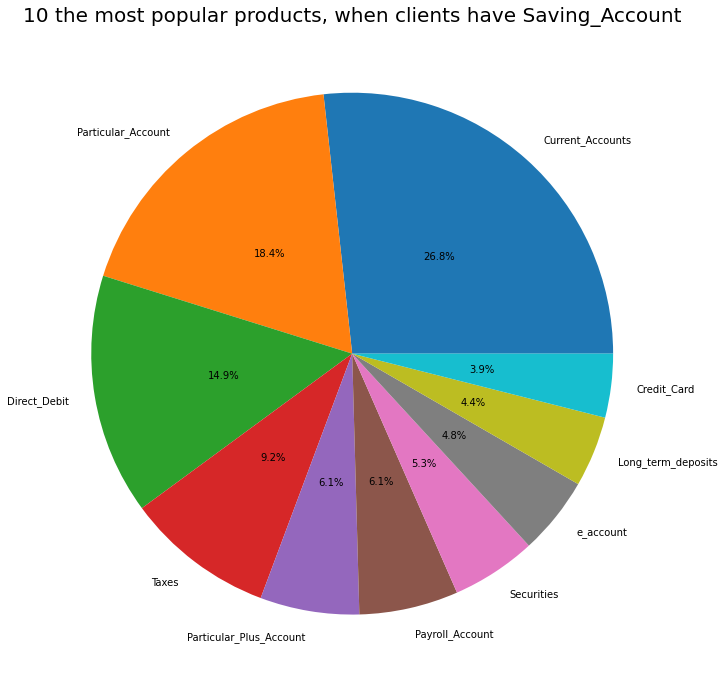

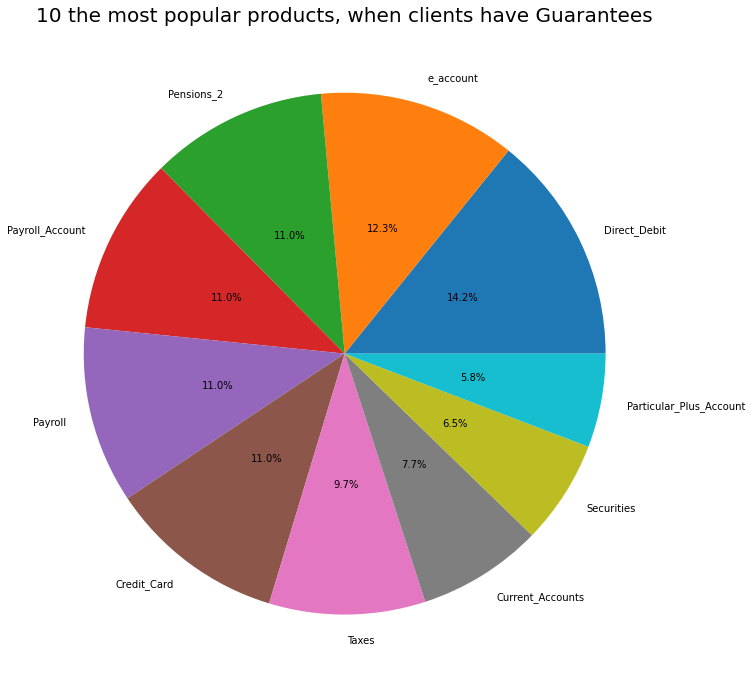

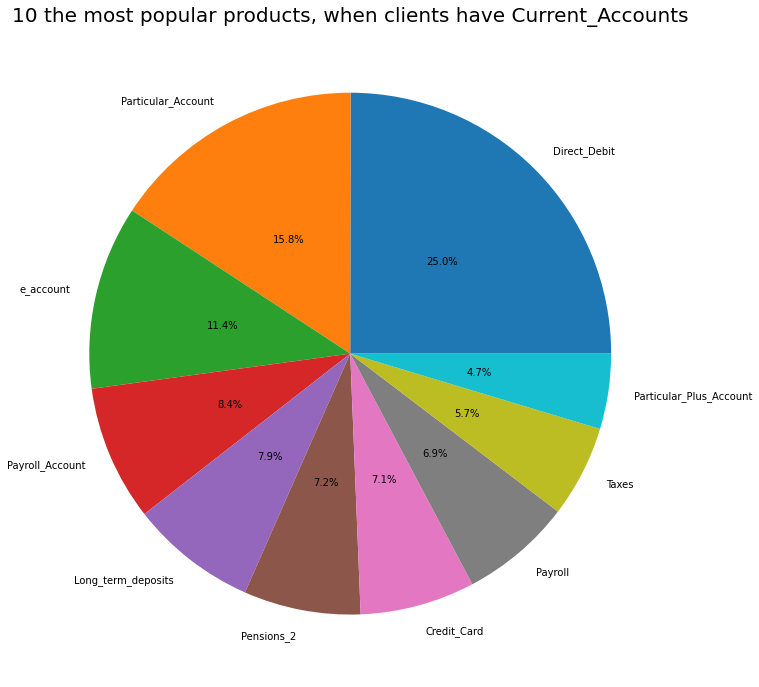

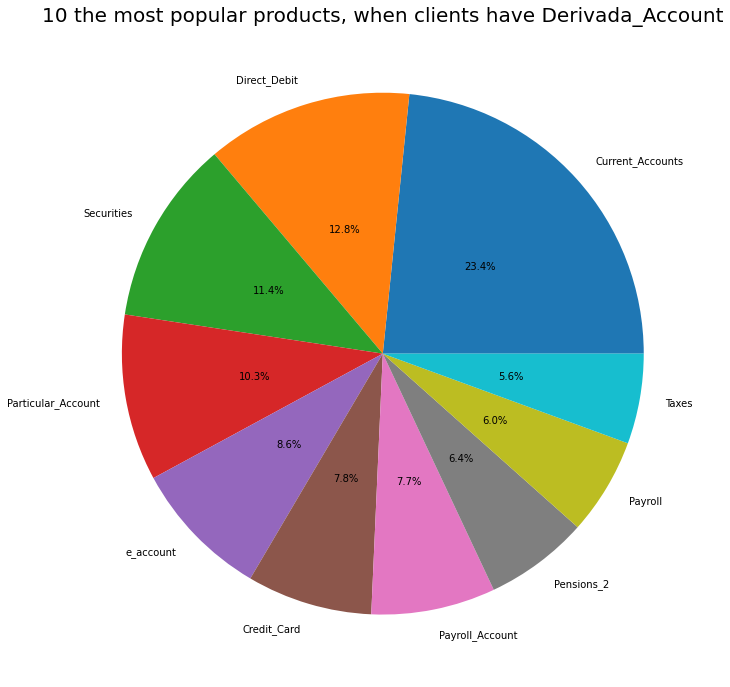

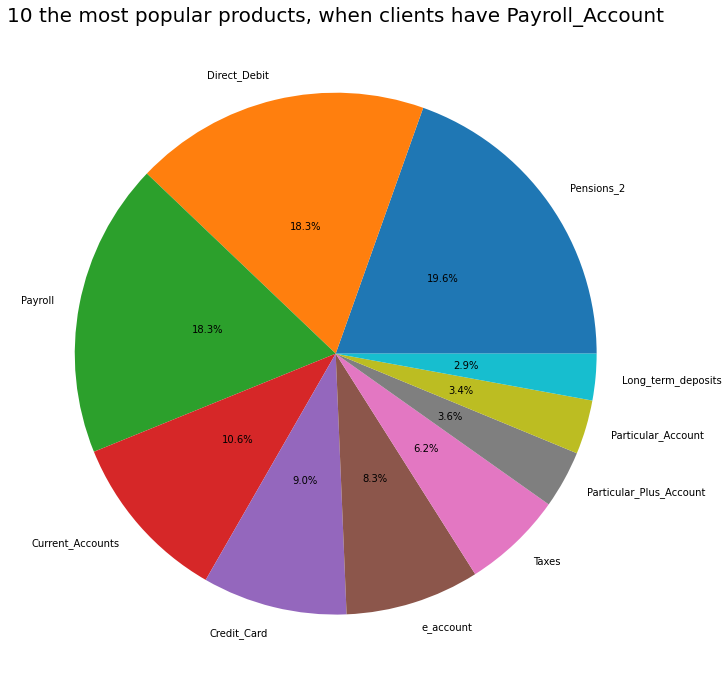

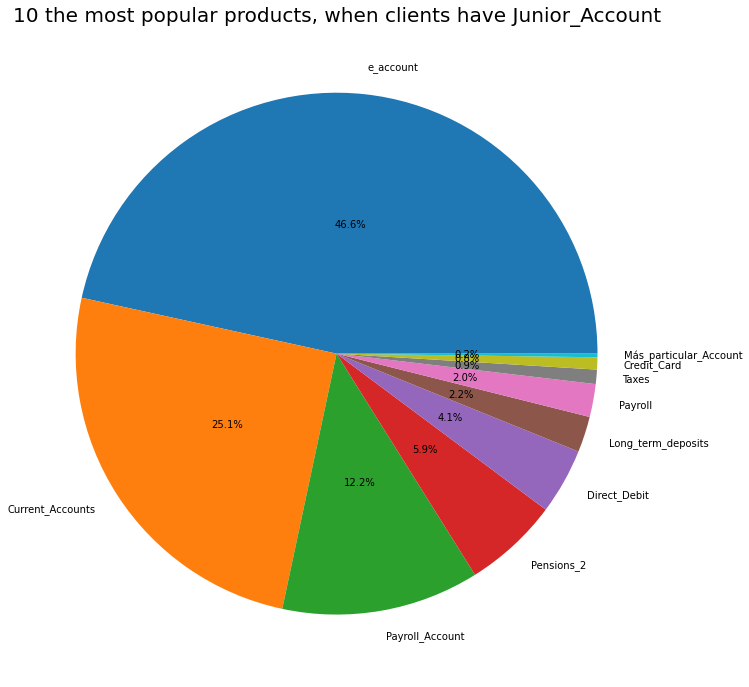

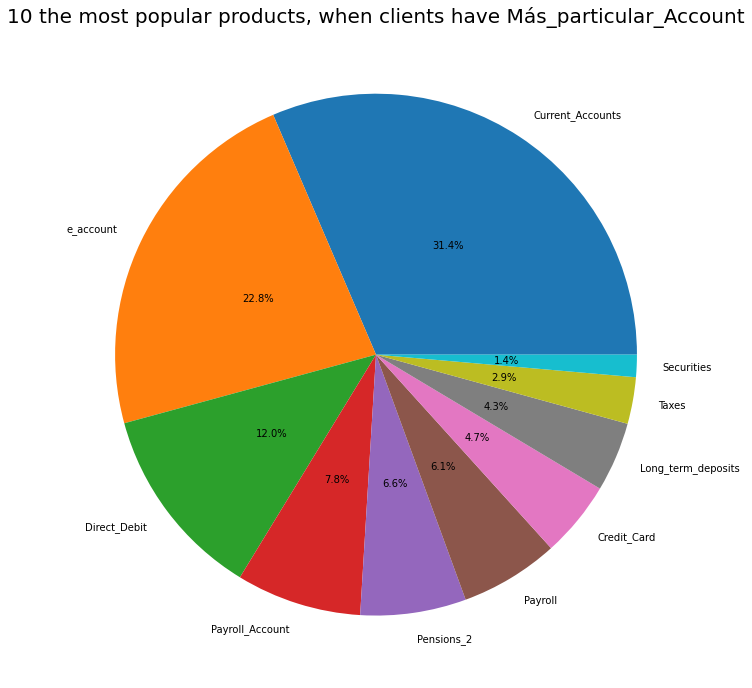

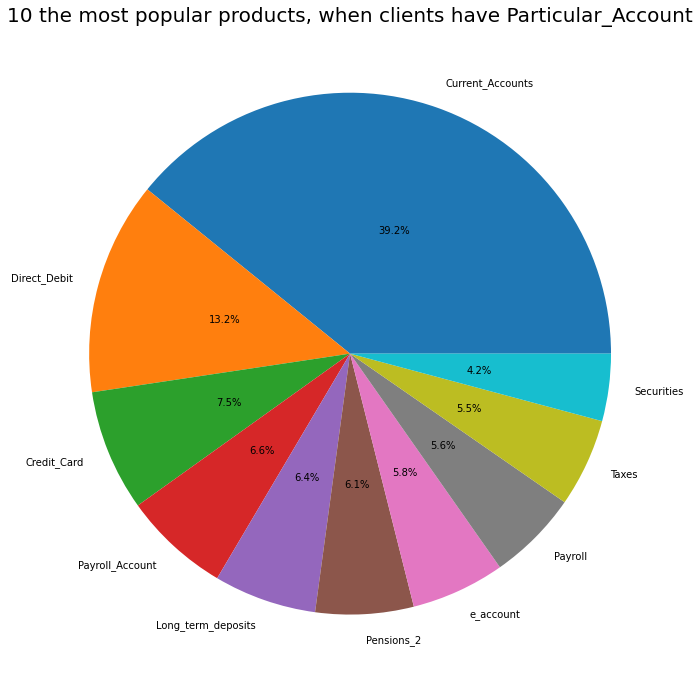

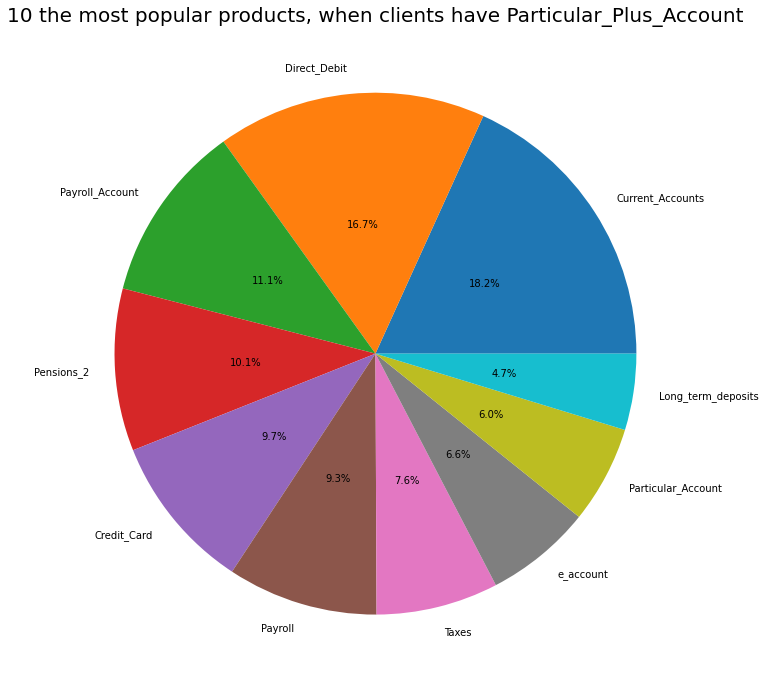

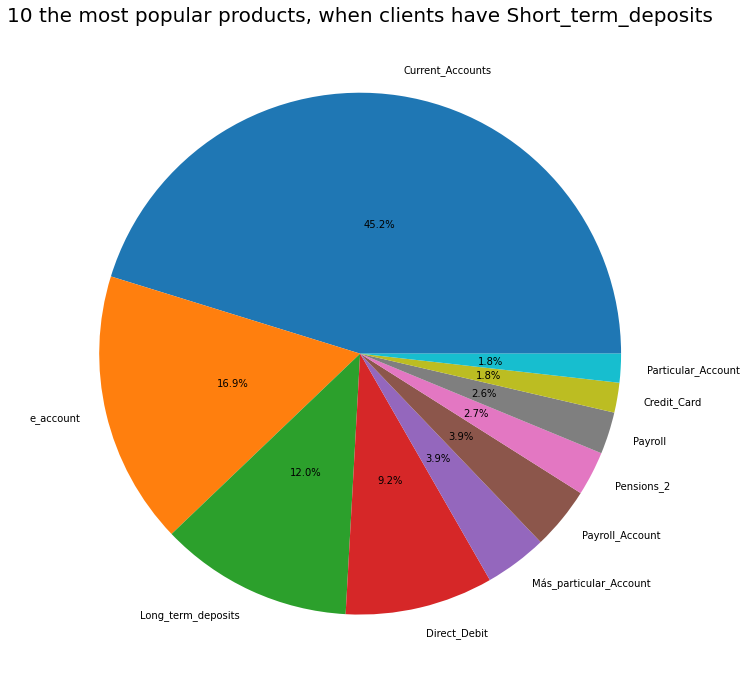

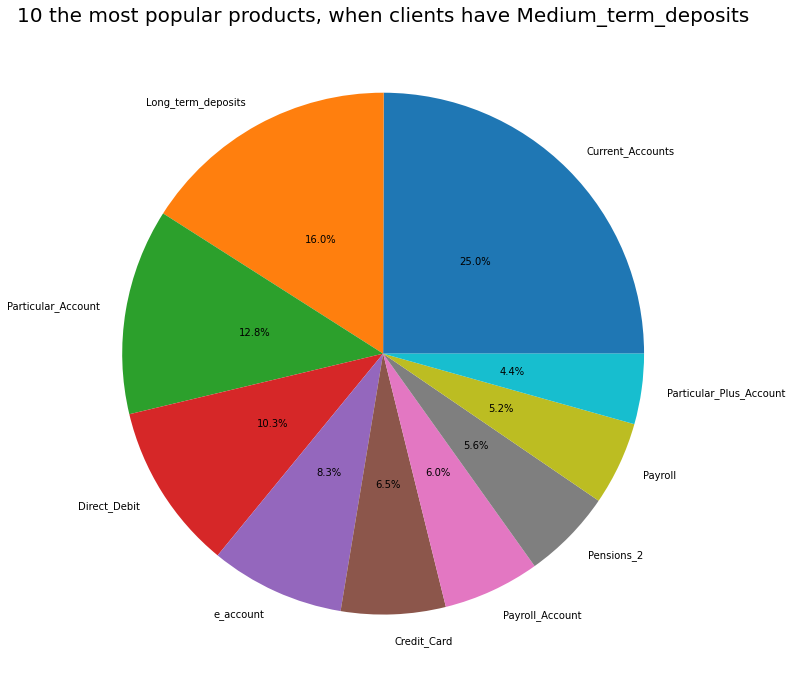

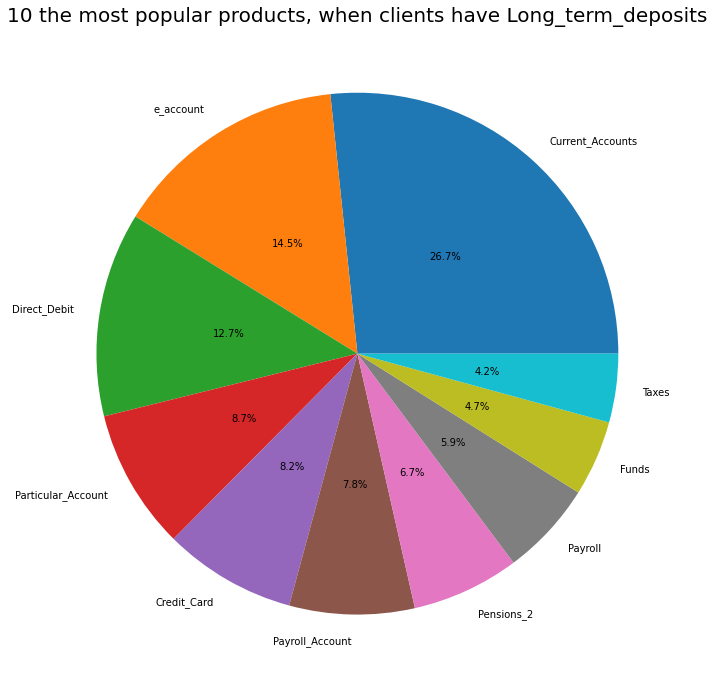

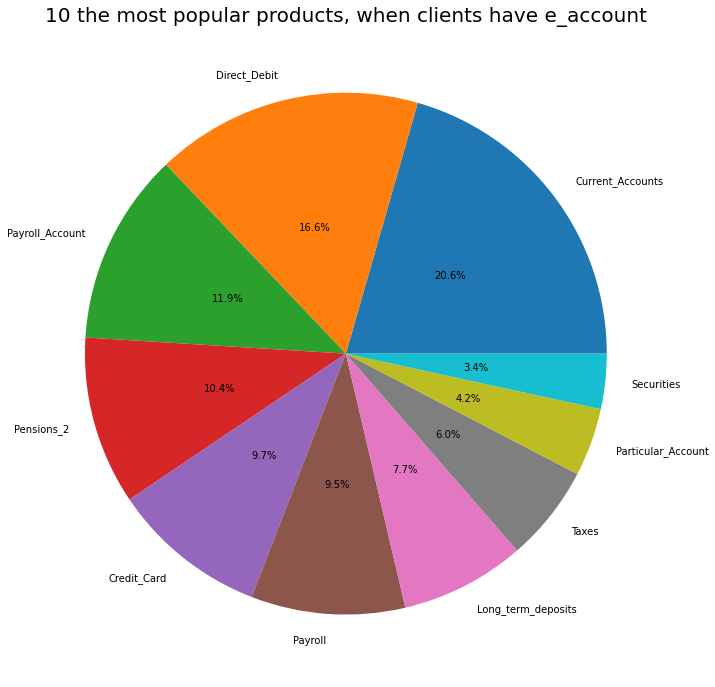

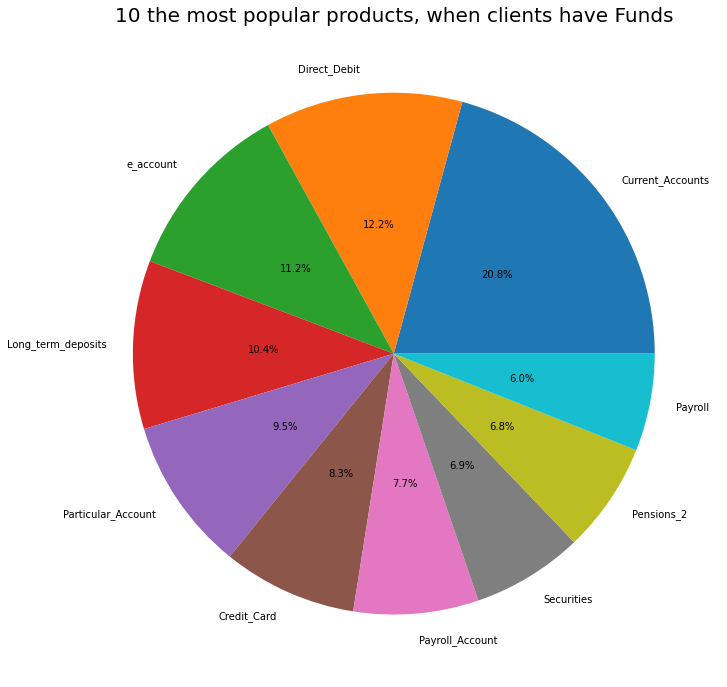

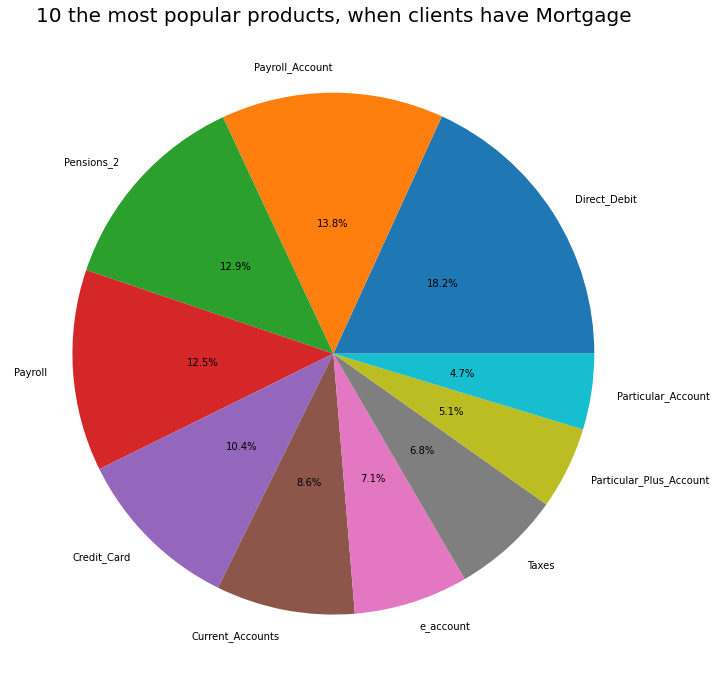

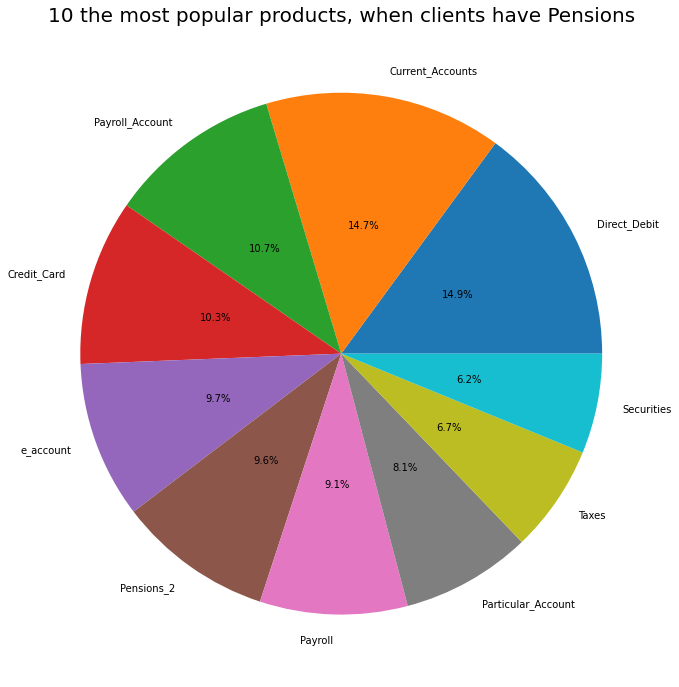

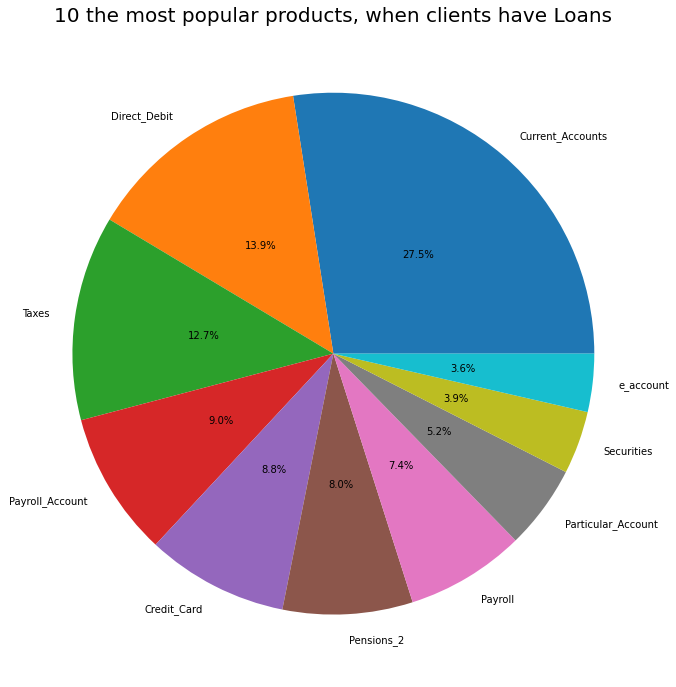

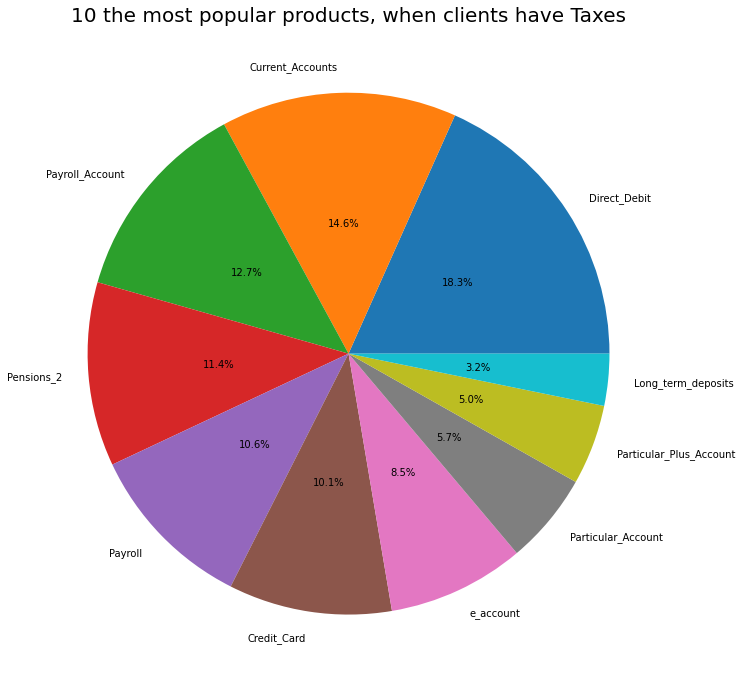

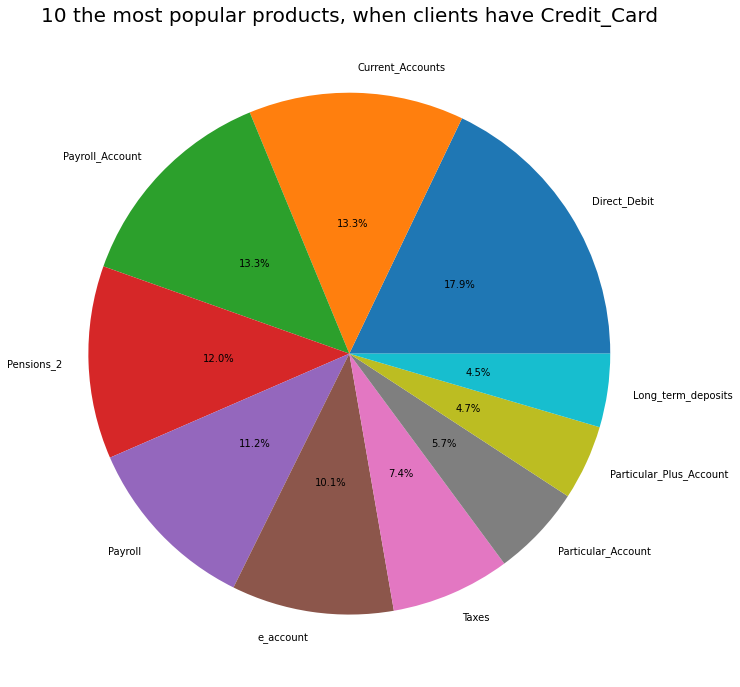

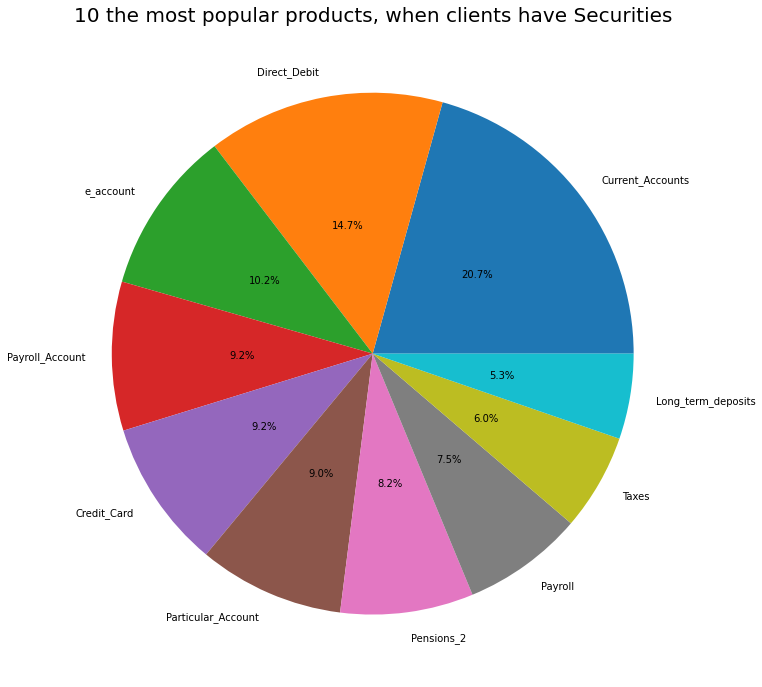

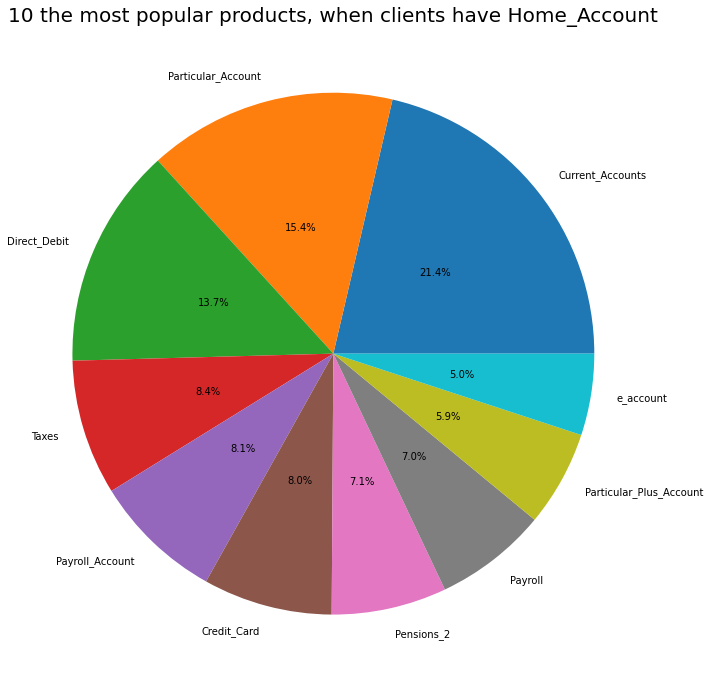

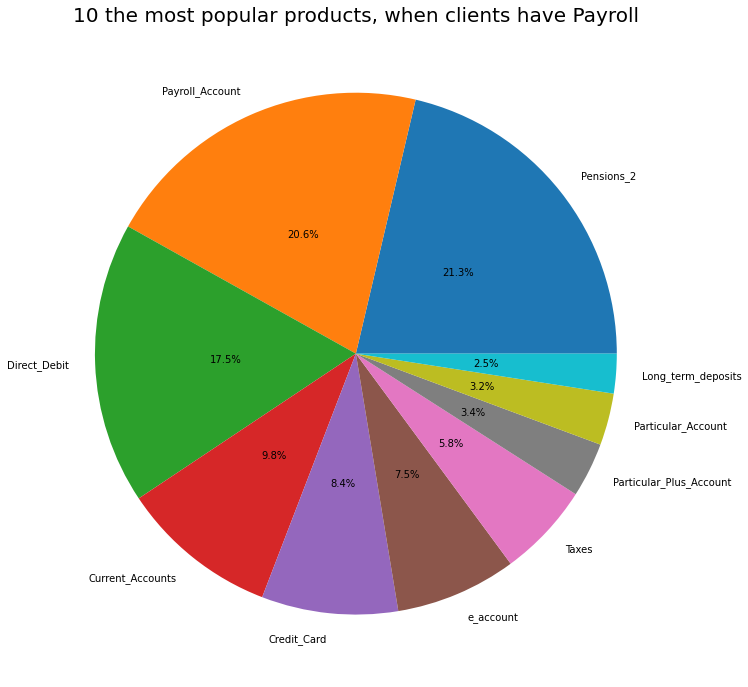

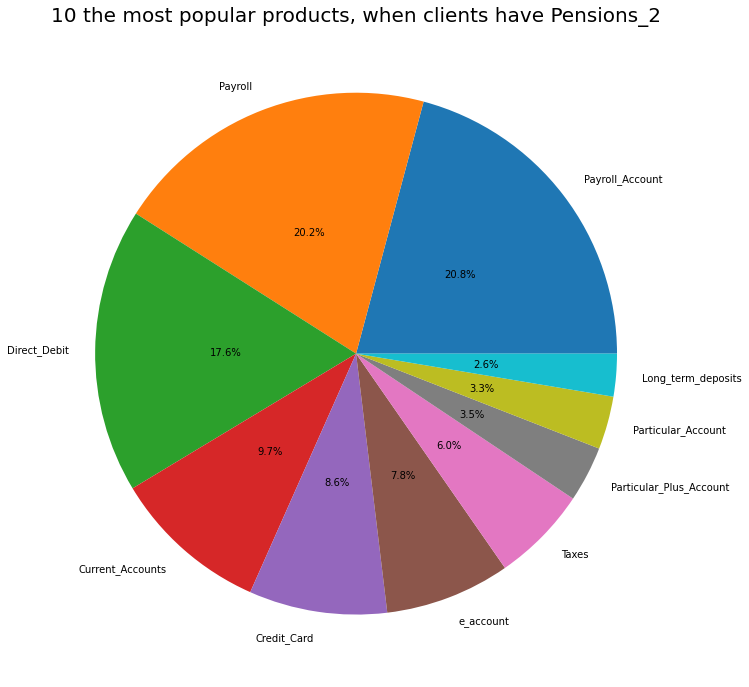

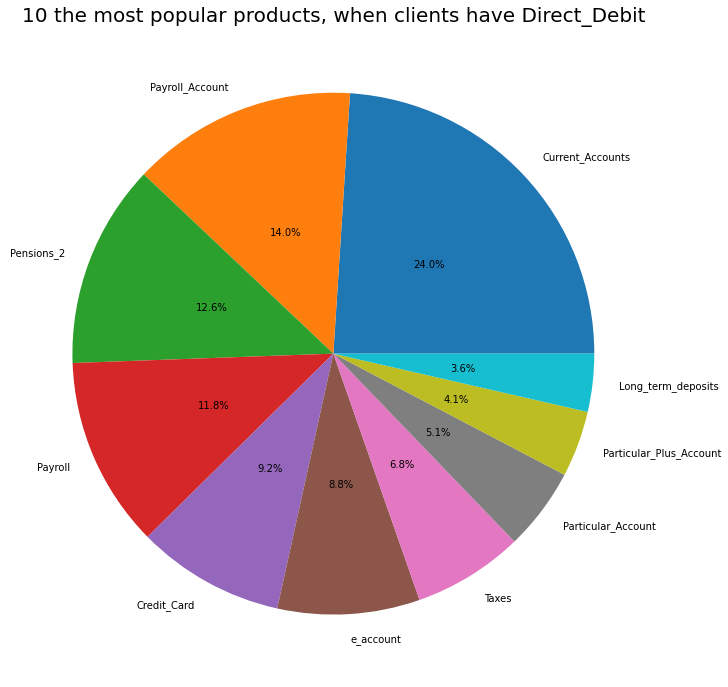

In [37]:
for num, prod in enumerate(products):
    data = total_prod_by_cust[total_prod_by_cust[prod] == 1][products[:num]+products[num+1:]].sum().sort_values(ascending=False).head(10)
    pie_plot(data, [20,12], f'10 the most popular products, when clients have {prod}', 20)

Cramer's V is a measure of the strength of association between two nominal variables. It ranges from 0 to 1 where: 0 indicates no association between the two variables. 1 indicates a perfect association between the two variables

In [39]:
import scipy.stats as ss

categorical_columns = ['employee_ind', 'cust_country_residence',
       'sex','new_cust_index',
       'indrel', 'indrel_1mes', 'tiprel_1mes', 'residence_ind',
       'foreigner_ind', 'channel', 'deceased_ind', 'province_name',
       'activity_index', 'segment', 'Saving_Account', 'Guarantees',
       'Current_Accounts', 'Derivada_Account', 'Payroll_Account',
       'Junior_Account', 'Más_particular_Account', 'Particular_Account',
       'Particular_Plus_Account', 'Short_term_deposits',
       'Medium_term_deposits', 'Long_term_deposits', 'e_account', 'Funds',
       'Mortgage', 'Pensions', 'Loans', 'Taxes', 'Credit_Card', 'Securities',
       'Home_Account', 'Payroll', 'Pensions_2', 'Direct_Debit',
       'total_products', 'age_group', 'income_group']

In [40]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for prod in products:
    for col in categorical_columns:
        if prod != col:
            confusion_matrix = pd.crosstab(train_df[col], train_df[prod])
            res = cramers_v(confusion_matrix.values)
            if res > 0.3: #I can see small correlation too
                print(f'Cramers V statistic for {prod} - {col} association = {res}')

Cramers V statistic for Current_Accounts - channel association = 0.3405830287010685
Cramers V statistic for Current_Accounts - segment association = 0.3013837416719589
Cramers V statistic for Current_Accounts - Payroll_Account association = 0.5952183253569236
Cramers V statistic for Current_Accounts - Payroll association = 0.44988562729887116
Cramers V statistic for Current_Accounts - Pensions_2 association = 0.47249413872399315
Cramers V statistic for Current_Accounts - total_products association = 0.36680349792374994
Cramers V statistic for Payroll_Account - tiprel_1mes association = 0.30188725367280544
Cramers V statistic for Payroll_Account - Current_Accounts association = 0.5952183253569236
Cramers V statistic for Payroll_Account - Taxes association = 0.3119463693569338
Cramers V statistic for Payroll_Account - Credit_Card association = 0.37774346266524617
Cramers V statistic for Payroll_Account - Payroll association = 0.7542492806795874
Cramers V statistic for Payroll_Account - P

## Final recommendations:

some cross-selling recommendations

*   For clients less than 20 years an employee can offer junior account, e_account, payroll and direct_debit
*  Clients from 21 to 65 years often have direct debit, payroll acount, pension, credic cards, e-account, particular account.
* clients over 65 years have long term geposits
* It is doesn't matter how much the client earns.
* Some products have dependences. For example: current-account - payroll account, pensions - payroll account and etc.
* I propose to build a recommendation system that will output product, based on customer data.


# Recommendation system

In [42]:
total_prod_by_cust = train_df.groupby('customer_code')[products].sum()
for prod in products:
    total_prod_by_cust[prod] = total_prod_by_cust[prod].apply(lambda x: 1 if x > 0 else 0)

del_rows = total_prod_by_cust[(total_prod_by_cust[products].sum(axis=1) == 0) | (total_prod_by_cust[products].sum(axis=1) == 1)].index 
total_prod_by_cust = total_prod_by_cust.drop(del_rows, axis = 0)
total_prod_by_cust.head()

Saving_Account  Guarantees  Current_Accounts  Derivada_Account  \
customer_code                                                                   
15889                       0           0                 1                 0   
15890                       0           0                 0                 0   
15892                       0           0                 1                 0   
15893                       0           0                 0                 0   
15894                       0           0                 1                 0   

               Payroll_Account  Junior_Account  Más_particular_Account  \
customer_code                                                            
15889                        0               0                       0   
15890                        1               0                       0   
15892                        1               0                       0   
15893                        0               0                       0   
15894                        1               0                       0   

               Particular_Account  Particular_Plus_Account  \
customer_code                                                
15889                           0                        1   
15890                           0                        1   
15892                           0                        0   
15893                           0                        0   
15894                           0                        0   

               Short_term_deposits  Medium_term_deposits  Long_term_deposits  \
customer_code                                                                  
15889                            0                     0                   0   
15890                            0                     0                   0   
15892                            0                     0                   1   
15893                            0                     0                   1   
15894                            0                     0                   1   

               e_account  Funds  Mortgage  Pensions  Loans  Taxes  \
customer_code                                                       
15889                  0      0         0         0      0      0   
15890                  1      0         0         1      0      0   
15892                  1      0         0         0      0      1   
15893                  0      0         0         0      0      0   
15894                  1      0         0         0      0      1   

               Credit_Card  Securities  Home_Account  Payroll  Pensions_2  \
customer_code                                                               
15889                    1           1             0        0           0   
15890                    1           0             0        1           1   
15892                    1           1             0        0           0   
15893                    0           1             0        0           0   
15894                    1           1             0        1           1   

               Direct_Debit  
customer_code                
15889                     0  
15890                     1  
15892                     1  
15893                     0  
15894                     1

i will use cosine similarity for recommendation

In [43]:
df = pd.melt(total_prod_by_cust.reset_index(), id_vars=['customer_code'])
df = df.sample(frac=1, axis=0).reset_index(drop=True)
df.columns = ['customer_id', 'product_name', 'is_purchase']

In [44]:
pivot_df = pd.pivot_table(df,index = 'customer_id',columns = 'product_name',values = 'is_purchase')
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.drop('customer_id', axis=1)
pivot_df.head()

product_name  Credit_Card  Current_Accounts  Derivada_Account  Direct_Debit  \
0                       1                 1                 0             0   
1                       1                 0                 0             1   
2                       1                 1                 0             1   
3                       0                 0                 0             0   
4                       1                 1                 0             1   

product_name  Funds  Guarantees  Home_Account  Junior_Account  Loans  \
0                 0           0             0               0      0   
1                 0           0             0               0      0   
2                 0           0             0               0      0   
3                 0           0             0               0      0   
4                 0           0             0               0      0   

product_name  Long_term_deposits  Medium_term_deposits  Mortgage  \
0                              0                     0         0   
1                              0                     0         0   
2                              1                     0         0   
3                              1                     0         0   
4                              1                     0         0   

product_name  Más_particular_Account  Particular_Account  \
0                                  0                   0   
1                                  0                   0   
2                                  0                   0   
3                                  0                   0   
4                                  0                   0   

product_name  Particular_Plus_Account  Payroll  Payroll_Account  Pensions  \
0                                   1        0                0         0   
1                                   1        1                1         1   
2                                   0        0                1         0   
3                                   0        0                0         0   
4                                   0        1                1         0   

product_name  Pensions_2  Saving_Account  Securities  Short_term_deposits  \
0                      0               0           1                    0   
1                      1               0           0                    0   
2                      0               0           1                    0   
3                      0               0           1                    0   
4                      1               0           1                    0   

product_name  Taxes  e_account  
0                 0          0  
1                 0          1  
2                 1          1  
3                 0          0  
4                 1          1

In [45]:
co_matrix = pivot_df.T.dot(pivot_df)
np.fill_diagonal(co_matrix.values, 0)

In [46]:
cos_score_df = pd.DataFrame(cosine_similarity(co_matrix))
cos_score_df.index = co_matrix.index
cos_score_df.columns = np.array(co_matrix.index)
cos_score_df

Credit_Card  Current_Accounts  Derivada_Account  \
product_name                                                               
Credit_Card                 1.000000          0.818598          0.849372   
Current_Accounts            0.818598          1.000000          0.694528   
Derivada_Account            0.849372          0.694528          1.000000   
Direct_Debit                0.795940          0.473216          0.852986   
Funds                       0.867765          0.742952          0.961019   
Guarantees                  0.911690          0.827427          0.833591   
Home_Account                0.862381          0.750180          0.955360   
Junior_Account              0.594361          0.405574          0.578993   
Loans                       0.839605          0.586132          0.930092   
Long_term_deposits          0.840277          0.644840          0.952654   
Medium_term_deposits        0.785195          0.662855          0.910398   
Mortgage                    0.936436          0.842122          0.801474   
Más_particular_Account      0.784310          0.510605          0.848371   
Particular_Account          0.738559          0.424973          0.892565   
Particular_Plus_Account     0.930682          0.770884          0.923816   
Payroll                     0.865322          0.730669          0.719431   
Payroll_Account             0.851371          0.742109          0.730426   
Pensions                    0.931319          0.832118          0.937304   
Pensions_2                  0.857778          0.736003          0.720001   
Saving_Account              0.798596          0.676300          0.937516   
Securities                  0.907075          0.763219          0.939606   
Short_term_deposits         0.643172          0.345208          0.806202   
Taxes                       0.931599          0.810781          0.873984   
e_account                   0.887339          0.700333          0.894768   

                         Direct_Debit     Funds  Guarantees  Home_Account  \
product_name                                                                
Credit_Card                  0.795940  0.867765    0.911690      0.862381   
Current_Accounts             0.473216  0.742952    0.827427      0.750180   
Derivada_Account             0.852986  0.961019    0.833591      0.955360   
Direct_Debit                 1.000000  0.857852    0.792507      0.841592   
Funds                        0.857852  1.000000    0.843838      0.935217   
Guarantees                   0.792507  0.843838    1.000000      0.827593   
Home_Account                 0.841592  0.935217    0.827593      1.000000   
Junior_Account               0.626113  0.646653    0.583980      0.484315   
Loans                        0.874306  0.889556    0.807200      0.936004   
Long_term_deposits           0.872331  0.930364    0.811960      0.925680   
Medium_term_deposits         0.817451  0.959069    0.706527      0.907354   
Mortgage                     0.774415  0.819390    0.961520      0.834042   
Más_particular_Account       0.827414  0.876014    0.721627      0.778547   
Particular_Account           0.839361  0.873148    0.656928      0.843518   
Particular_Plus_Account      0.860494  0.928833    0.907467      0.929672   
Payroll                      0.726652  0.740098    0.847609      0.736573   
Payroll_Account              0.705712  0.752550    0.870800      0.754138   
Pensions                     0.851293  0.938956    0.950478      0.929692   
Pensions_2                   0.715283  0.735901    0.853999      0.740552   
Saving_Account               0.777427  0.911575    0.715788      0.972119   
Securities                   0.874000  0.953281    0.873950      0.956256   
Short_term_deposits          0.766632  0.831162    0.521437      0.737049   
Taxes                        0.814907  0.891503    0.912921      0.878375   
e_account                    0.845737  0.897503    0.839630      0.905648   

                         Junior_Account     L

In [47]:
product_recs = []
for i in cos_score_df.index:
    product_recs.append(cos_score_df[cos_score_df.index!=i][i].sort_values(ascending = False)[0:5].index)
    
product_recs_df = pd.DataFrame(product_recs)
product_recs_df.index = cos_score_df.index

In [48]:
product_recs_df

0                       1  \
product_name                                                               
Credit_Card                             Mortgage                   Taxes   
Current_Accounts                        Mortgage                Pensions   
Derivada_Account                           Funds            Home_Account   
Direct_Debit                               Loans              Securities   
Funds                           Derivada_Account    Medium_term_deposits   
Guarantees                              Mortgage                Pensions   
Home_Account                      Saving_Account              Securities   
Junior_Account            Más_particular_Account      Long_term_deposits   
Loans                    Particular_Plus_Account            Home_Account   
Long_term_deposits                    Securities        Derivada_Account   
Medium_term_deposits                       Funds              Securities   
Mortgage                              Guarantees                   Taxes   
Más_particular_Account        Long_term_deposits     Short_term_deposits   
Particular_Account           Short_term_deposits                   Loans   
Particular_Plus_Account                 Pensions               e_account   
Payroll                                 Mortgage                   Taxes   
Payroll_Account                         Mortgage              Guarantees   
Pensions                 Particular_Plus_Account              Securities   
Pensions_2                              Mortgage                   Taxes   
Saving_Account                      Home_Account        Derivada_Account   
Securities               Particular_Plus_Account                Pensions   
Short_term_deposits           Particular_Account  Más_particular_Account   
Taxes                                   Mortgage                Pensions   
e_account                Particular_Plus_Account                   Loans   

                                               2                        3  \
product_name                                                                
Credit_Card                             Pensions  Particular_Plus_Account   
Current_Accounts                      Guarantees              Credit_Card   
Derivada_Account              Long_term_deposits               Securities   
Direct_Debit                  Long_term_deposits  Particular_Plus_Account   
Funds                                 Securities                 Pensions   
Guarantees                                 Taxes              Credit_Card   
Home_Account                    Derivada_Account                    Loans   
Junior_Account               Short_term_deposits                    Funds   
Loans                         Particular_Account         Derivada_Account   
Long_term_deposits        Más_particular_Account                    Funds   
Medium_term_deposits            Derivada_Account           Saving_Account   
Mortgage                                Pensions              Credit_Card   
Más_particular_Account        Particular_Account                    Funds   
Particular_Account            Long_term_deposits   Más_particular_Account   
Particular_Plus_Account               Securities                    Taxes   
Payroll                              Credit_Card  Particular_Plus_Account   
Payroll_Account                            Taxes  Particular_Plus_Account   
Pensions                                   Taxes               Guarantees   
Pensions_2                           Credit_Card               Guarantees   
Saving_Account                             Funds     Medium_term_deposits   
Securities                    Long_term_deposits             Home_Account   
Short_term_deposits           Long_term_deposits     Medium_term_deposits   
Taxes                    Particular_Plus_Account               Securities   
e_account                             Securities                 Pensions   

                                               4  
product_name    

Here we can see recommendation by cosine similarity